## 사용할 패키지

In [32]:
import pandas as pd
from pandas import DataFrame, Series
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
    
import keras
from keras import models
from keras.models import Sequential
from keras.models import Model
from keras.models import load_model
from keras import backend as K
from keras import layers
from keras.layers import Layer
from keras.layers import Input,Dense,Flatten,Embedding,Permute,Dot,Reshape
from keras.layers.convolutional import Conv1D,MaxPooling1D,MaxPooling2D
from keras.layers import Dropout
from keras.layers import LSTM,GRU
from keras.callbacks import Callback
from keras.preprocessing import sequence
from keras.utils import np_utils
 
import tensorflow as tf
from tensorflow.python.framework import function
import math
 
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score,accuracy_score

import lightgbm as lgb
import xgboost as xgb 

from bs4 import BeautifulSoup
    
import scipy

import statsmodels.api
import statsmodels as sm
 
import copy
import random
import time
from time import sleep

import re
import os
import lightgbm as lgb

# 1. Data Load

## 1) 데이터 불러오기

In [33]:
dangjin_fcst = pd.read_csv("data/dangjin_fcst_data.csv")
dangjin_obs = pd.read_csv("data/dangjin_obs_data.csv")
energy = pd.read_csv("data/energy.csv")
site_info = pd.read_csv("data/site_info.csv")
ulsan_fcst = pd.read_csv("data/ulsan_fcst_data.csv")
ulsan_obs = pd.read_csv("data/ulsan_obs_data.csv")

## 2)API

### (1) 출몰시각 API

In [3]:
site_info

,Id,Capacity,Address,InstallationAngle,IncidentAngle,Latitude,Longitude
0,당진수상태양광,1.0,충남 당진시 석문면 교로길 30,30.0,30.0,37.050753,126.510299
1,당진자재창고태양광,0.7,충남 당진시 석문면 교로길 30,30.0,30.0,37.050753,126.510299
2,당진태양광,1.0,충남 당진시 석문면 교로길 30,30.0,30.0,37.050753,126.510299
3,울산태양광,0.5,울산광역시 남구 용잠로 623,20.0,20.0,35.477651,129.380778


In [4]:
times = pd.to_datetime(dangjin_fcst["Forecast time"]).dt.date.astype("str").str.split("-").apply(lambda x : x[0]+x[1]+x[2]).unique()

In [ ]:
from urllib.parse import urlencode, unquote
import requests
import json

sun_result = DataFrame()

for i in times:

    #url = "http://apis.data.go.kr/B090041/openapi/service/RiseSetInfoService/getLCRiseSetInfo"

    queryParams = '?' + urlencode({'serviceKey' : 'jmtM76yEqj6tyGa/Ld/fC5bQUOEZNRE7sh5Q+twbCQegPZf1MAvH4vKEBVNgvUtlt6u0fVqBWvFyaBr/wfq0Tg==', 
                                   'locdate' : i,
                                   'longitude' : '126.510299', 
                                   'latitude' : '37.050753',
                                   'dnYn' : 'Y'})

    queryURL = url + queryParams
    response = requests.get(queryURL)

    soup = BeautifulSoup(response.text, "html.parser")

    sunset_time = i + ' ' + soup.find("sunset").text[0:2] + ":00:00"
    
    sunrise_time = i + ' ' + soup.find("sunrise").text[0:2] + ":00:00"
    
    temp = DataFrame([0 for j in range(0,24)], 
                 columns = ["sun"],
                 index = pd.date_range(i, i + ' 23:00:00', freq = "H"))
    
    temp.loc[sunrise_time : sunset_time, "sun"] = 1
    
    sun_result = pd.concat([sun_result,temp])
    
sun_result = sun_result.reset_index()

sun_result.columns = ["Forecast_time","sun"]

sun_result.to_csv("sun_result_dangjin.csv", index = False)

In [487]:
from urllib.parse import urlencode, unquote
import requests
import json

sun_result = DataFrame()

for i in times:

    #url = "http://apis.data.go.kr/B090041/openapi/service/RiseSetInfoService/getLCRiseSetInfo"

    queryParams = '?' + urlencode({'serviceKey' : 'jmtM76yEqj6tyGa/Ld/fC5bQUOEZNRE7sh5Q+twbCQegPZf1MAvH4vKEBVNgvUtlt6u0fVqBWvFyaBr/wfq0Tg==', 
                                   'locdate' : i,
                                   'longitude' : '129.380778', 
                                   'latitude' : '35.477651',
                                   'dnYn' : 'Y'})

    queryURL = url + queryParams
    response = requests.get(queryURL)

    soup = BeautifulSoup(response.text, "html.parser")

    sunset_time = i + ' ' + soup.find("sunset").text[0:2] + ":00:00"
    
    sunrise_time = i + ' ' + soup.find("sunrise").text[0:2] + ":00:00"
    
    temp = DataFrame([0 for j in range(0,24)], 
                 columns = ["sun"],
                 index = pd.date_range(i, i + ' 23:00:00', freq = "H"))
    
    temp.loc[sunrise_time : sunset_time, "sun"] = 1
    
    sun_result = pd.concat([sun_result,temp])
    
sun_result = sun_result.reset_index()

sun_result.columns = ["Forecast time","sun"]

sun_result.to_csv("sun_result_ulsan.csv", index = False)

### (2) 미세먼지 API

In [865]:
from urllib.parse import urlencode, unquote
import requests
import json

url = "http://apis.data.go.kr/B552584/ArpltnInforInqireSvc/getMinuDustFrcstDspth"

queryParams = '?' + urlencode({'serviceKey' : 'jmtM76yEqj6tyGa/Ld/fC5bQUOEZNRE7sh5Q+twbCQegPZf1MAvH4vKEBVNgvUtlt6u0fVqBWvFyaBr/wfq0Tg==', 
                               'returnType' : 'json', 
                               'numOfRows' : '100', 
                               'pageNo' : '1',
                               'InformCode' : 'PM10' })

queryURL = url + queryParams
response = requests.get(queryURL)
print("=== response json data start ===")
print(response.text)
print("=== response json data end ===")
print()

=== response json data start ===
{"response":{"body":{"totalCount":674,"items":[{"informCode":"O3","dataTime":"2021-04-29"},{"informCode":"PM25","dataTime":"2021-04-29"},{"informCode":"PM10","dataTime":"2021-04-29"},{"informCode":"PM25","dataTime":"2021-04-29"},{"informCode":"PM25","dataTime":"2021-04-29"},{"informCode":"O3","dataTime":"2021-04-29"},{"informCode":"PM10","dataTime":"2021-04-29"},{"informCode":"PM10","dataTime":"2021-04-29"},{"informCode":"PM25","dataTime":"2021-04-29"},{"informCode":"PM25","dataTime":"2021-04-29"},{"informCode":"O3","dataTime":"2021-04-29"},{"informCode":"PM10","dataTime":"2021-04-29"},{"informCode":"PM10","dataTime":"2021-04-29"},{"informCode":"PM10","dataTime":"2021-04-29"},{"informCode":"PM25","dataTime":"2021-04-29"},{"informCode":"PM25","dataTime":"2021-04-29"},{"informCode":"PM10","dataTime":"2021-04-29"},{"informCode":"O3","dataTime":"2021-04-28"},{"informCode":"PM25","dataTime":"2021-04-28"},{"informCode":"PM10","dataTime":"2021-04-28"},{"inform

In [ ]:
result = {}
for item in r_item:
        if(item.get("category") == "T1H"):
                result = item
                break
for item in r_item:
        if(item.get("category") == "RN1"):
                result2 = item
                break

print("=== response dictionary(python object) data start ===")
print(result.get("baseTime")[:-2] +" temp : " + result.get("obsrValue") + "C")
print(result2.get("baseTime")[:-2] +" rain : " + result2.get("obsrValue") + "mm")
print("=== response dictionary(python object) data end ===")
print()

In [213]:
#from urllib3 import request, urlopen
from urllib3 import urlencode, quote_plus

url = 'http://apis.data.go.kr/B552584/ArpltnInforInqireSvc/getMinuDustFrcstDspth'


request = Request(url + queryParams)
request.get_method = lambda: 'GET'
response_body = urlopen(request).read()

ImportError: cannot import name 'urlencode' from 'urllib3' (C:\Users\User\anaconda3\lib\site-packages\urllib3\__init__.py)

# 2. EDA

## 1) 기초 통계 및 결측, 이상치 확인

### (1) 결측치

In [214]:
print(dangjin_fcst.isna().apply(lambda x : x.value_counts()))
print(dangjin_obs.isna().apply(lambda x : x.value_counts()))
print(energy.isna().apply(lambda x : x.value_counts()))
print(site_info.isna().apply(lambda x : x.value_counts()))
print(ulsan_fcst.isna().apply(lambda x : x.value_counts()))
print(ulsan_obs.isna().apply(lambda x : x.value_counts()))

       Forecast time  forecast  Temperature  Humidity  WindSpeed  \
False         162208    162208       162208    162208     162208   

       WindDirection   Cloud  
False         162208  162208  
            지점      지점명       일시  기온(°C)  풍속(m/s)  풍향(16방위)  습도(%)  전운량(10분위)
False  25626.0  25626.0  25626.0   25589    25590     25590  25591      21656
True       NaN      NaN      NaN      37       36        36     35       3970
          time  dangjin_floating  dangjin_warehouse  dangjin    ulsan
False  25632.0             25608              25584  25632.0  25632.0
True       NaN                24                 48      NaN      NaN
       Id  Capacity  Address  InstallationAngle  IncidentAngle  Latitude  \
False   4         4        4                  4              4         4   

       Longitude  
False          4  
       Forecast time  forecast  Temperature  Humidity  WindSpeed  \
False         162208    162208       162208    162208     162208   

       WindDirection   Cloud 

Forecast엔 결측치가 없고, obs엔 결측치가 소수 존재한다. Energy 결측치는 이유에 대한 탐색이 필요해보인다.

#### - Energy 결측 탐색

In [215]:
energy.loc[energy["dangjin_warehouse"].isna()]

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
384,2018-03-17 1:00:00,0.0,NaN,0,0
385,2018-03-17 2:00:00,0.0,NaN,0,0
386,2018-03-17 3:00:00,0.0,NaN,0,0
387,2018-03-17 4:00:00,0.0,NaN,0,0
388,2018-03-17 5:00:00,0.0,NaN,0,0
389,2018-03-17 6:00:00,0.0,NaN,0,0
390,2018-03-17 7:00:00,0.0,NaN,0,0
391,2018-03-17 8:00:00,24.0,NaN,16,13
392,2018-03-17 9:00:00,162.0,NaN,177,57
393,2018-03-17 10:00:00,363.0,NaN,348,206


In [216]:
energy.loc[energy["dangjin_floating"].isna()]

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
20352,2020-06-26 1:00:00,NaN,0.0,0,0
20353,2020-06-26 2:00:00,NaN,0.0,0,0
20354,2020-06-26 3:00:00,NaN,0.0,0,0
20355,2020-06-26 4:00:00,NaN,0.0,0,0
20356,2020-06-26 5:00:00,NaN,0.0,0,0
20357,2020-06-26 6:00:00,NaN,0.0,0,0
20358,2020-06-26 7:00:00,NaN,7.0,2,7
20359,2020-06-26 8:00:00,NaN,20.0,18,50
20360,2020-06-26 9:00:00,NaN,148.0,175,161
20361,2020-06-26 10:00:00,NaN,242.0,330,170


Enegry 내부에선 상관성이 있는 변수가 없어보인다.

정확히 하루 단위로 데이터가 NA이므로, 삭제해도 무방할 것으로 판단됨

In [217]:
energy = energy.dropna().reset_index(drop = True)

#### - obs 결측 탐색

In [218]:
dangjin_obs.isna().apply(lambda x : x.value_counts())

,지점,지점명,일시,기온(°C),풍속(m/s),풍향(16방위),습도(%),전운량(10분위)
False,25626.0,25626.0,25626.0,25589,25590,25590,25591,21656
True,NaN,NaN,NaN,37,36,36,35,3970


In [219]:
dangjin_fcst[dangjin_fcst["Forecast time"] == '2019-01-31 11:00:00']

,Forecast time,forecast,Temperature,Humidity,WindSpeed,WindDirection,Cloud
49728,2019-01-31 11:00:00,4.0,-1.0,40.0,9.0,328.0,4.0
49729,2019-01-31 11:00:00,7.0,-3.0,45.0,9.2,323.0,3.0
49730,2019-01-31 11:00:00,10.0,-3.0,50.0,10.9,320.0,3.0
49731,2019-01-31 11:00:00,13.0,-4.0,50.0,10.1,319.0,2.0
49732,2019-01-31 11:00:00,16.0,-2.0,60.0,8.8,320.0,3.0
49733,2019-01-31 11:00:00,19.0,-2.0,70.0,5.9,318.0,3.0
49734,2019-01-31 11:00:00,22.0,-2.0,70.0,2.9,252.0,3.0
49735,2019-01-31 11:00:00,25.0,2.0,45.0,7.5,284.0,2.0
49736,2019-01-31 11:00:00,28.0,4.0,45.0,8.1,275.0,2.0
49737,2019-01-31 11:00:00,31.0,1.0,65.0,7.5,269.0,1.0


In [220]:
dangjin_obs[dangjin_obs["일시"].str.slice(0,10) == '2019-01-31']

,지점,지점명,일시,기온(°C),풍속(m/s),풍향(16방위),습도(%),전운량(10분위)
8058,129,서산,2019-01-31 00:00,1.4,0.1,0.0,85.0,10.0
8059,129,서산,2019-01-31 01:00,1.3,0.4,0.0,87.0,10.0
8060,129,서산,2019-01-31 02:00,2.3,1.3,20.0,88.0,10.0
8061,129,서산,2019-01-31 03:00,1.8,1.0,20.0,80.0,10.0
8062,129,서산,2019-01-31 04:00,1.6,2.5,360.0,56.0,10.0
8063,129,서산,2019-01-31 05:00,1.0,1.9,360.0,51.0,10.0
8064,129,서산,2019-01-31 06:00,0.6,1.4,360.0,48.0,10.0
8065,129,서산,2019-01-31 07:00,0.3,2.9,360.0,48.0,10.0
8066,129,서산,2019-01-31 08:00,-0.3,2.4,360.0,45.0,10.0
8067,129,서산,2019-01-31 09:00,-0.6,2.7,360.0,44.0,10.0


기온, 풍속, 풍향, 습도 결측치는 서로 밀접한 연관이 있는 것으로 보인다.

활용이 불가능하므로 제외한다.

In [221]:
dangjin_obs = dangjin_obs.dropna(axis = 0, subset = ["기온(°C)","풍속(m/s)", "풍향(16방위)", "습도(%)"]).reset_index(drop = True)

### - 전운량 결측 탐색

In [222]:
dangjin_obs["전운량(10분위)"].isna().value_counts()

False    21618
True      3970
Name: 전운량(10분위), dtype: int64

In [233]:
dangjin_obs["일시"] = pd.to_datetime(dangjin_obs["일시"])
dangjin_obs["date"] = dangjin_obs["일시"].dt.date
dangjin_obs["hour"] = dangjin_obs["date"].astype("str") + " " + dangjin_obs["일시"].dt.hour.astype("str")

<AxesSubplot:>

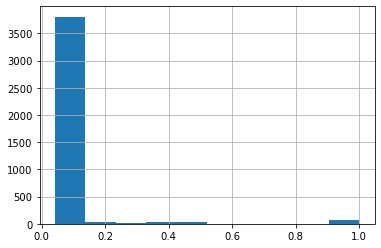

In [234]:
# 하루 중 전운량이 NA인 비율

k = dangjin_obs[dangjin_obs["전운량(10분위)"].isna()].groupby("date").apply(lambda x : x["전운량(10분위)"].isna() / len(x))

k.hist()

최초 예상으로는 전운량이 Na인 경우 하루 전체가 다 그럴것이라는 가설을 세웠지만

그 가설은 사실이 아닌것으로 판명되었다.

<AxesSubplot:>

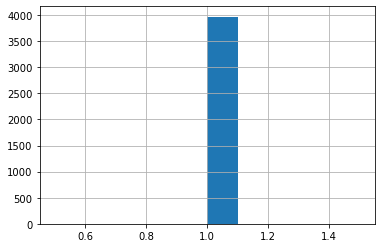

In [235]:
# 시간 중 전운량이 NA인 비율

k = dangjin_obs[dangjin_obs["전운량(10분위)"].isna()].groupby("hour").apply(lambda x : x["전운량(10분위)"].isna() / len(x))

k.hist()

## 2) 파생 변수 생성 전략 탐색

### (1) 실제 값과 가장 유사한 예측 발표 탐색

#### - 데이터 Merge

In [9]:
dangjin_obs = dangjin_obs.rename(columns = {"일시" : "Forecast time"})
ulsan_obs = ulsan_obs.rename(columns = {"일시" : "Forecast time"})

dangjin_obs["Forecast time"] = pd.to_datetime(dangjin_obs["Forecast time"])
ulsan_obs["Forecast time"] = pd.to_datetime(ulsan_obs["Forecast time"])

In [10]:
dangjin_obs_eda = dangjin_obs[["Forecast time","기온(°C)", "풍속(m/s)", "풍향(16방위)", "습도(%)", "전운량(10분위)"]]
ulsan_obs_eda = ulsan_obs[["Forecast time","기온(°C)", "풍속(m/s)", "풍향(16방위)", "습도(%)", "전운량(10분위)"]]

In [11]:
dangjin_fcst_eda = dangjin_fcst.copy()
ulsan_fcst_eda = ulsan_fcst.copy()

In [12]:
#dangjin_fcst_eda["forecast"] = pd.to_datetime(dangjin_fcst_eda["Forecast time"]) + dangjin_fcst_eda["forecast"].apply(
#    lambda x : pd.Timedelta(x, unit = "H"))

In [13]:
#ulsan_fcst_eda["forecast"] = pd.to_datetime(ulsan_fcst_eda["Forecast time"]) + ulsan_fcst_eda["forecast"].apply(
#    lambda x : pd.Timedelta(x, unit = "H"))

In [14]:
dangjin_fcst_eda["Forecast time"] = pd.to_datetime(dangjin_fcst_eda["Forecast time"])
ulsan_fcst_eda["Forecast time"] = pd.to_datetime(ulsan_fcst_eda["Forecast time"])

In [15]:
#result = pd.merge(dangjin_obs, dangjin_fcst_eda, on = "forecast", how = "left")

#### - 2시

In [16]:
dangjin_fcst_eda["Forecast time"].dt.hour.unique()

array([11, 14, 17, 20, 23,  2,  5,  8], dtype=int64)

예측 시간은 2시, 5시, 8시, 11시, 14시, 17시, 20시, 23시이다.

In [17]:
def to_date(x):
    return pd.DateOffset(hours=x)

def corr_time(x):
    
    dangjin_fcst_ = dangjin_fcst_eda[dangjin_fcst_eda['Forecast time'].dt.hour==x]
    ulsan_fcst_ = ulsan_fcst_eda[ulsan_fcst_eda['Forecast time'].dt.hour==x]

    dangjin_fcst_['Forecast time'] = dangjin_fcst_['Forecast time'] + dangjin_fcst_['forecast'].map(to_date)
    ulsan_fcst_['Forecast time'] = ulsan_fcst_['Forecast time'] + ulsan_fcst_['forecast'].map(to_date)

    dangjin_fcst_ = dangjin_fcst_[(dangjin_fcst_['forecast']>=(24 - x))&(dangjin_fcst_['forecast']<=(48 - 1 - x))]
    ulsan_fcst_ = ulsan_fcst_[(ulsan_fcst_['forecast']>=(24 - x))&(ulsan_fcst_['forecast']<=(48 - 1 - x))]

    dangjin_fcst_ = dangjin_fcst_[['Forecast time', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]
    ulsan_fcst_ = ulsan_fcst_[['Forecast time', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]

    dangjin_fcst__ = pd.DataFrame()
    dangjin_fcst__['Forecast time'] = pd.date_range(start='2018-03-02 00:00:00', end='2021-03-01 23:00:00', freq='H')

    ulsan_fcst__ = pd.DataFrame()
    ulsan_fcst__['Forecast time'] = pd.date_range(start='2018-03-02 00:00:00', end='2021-03-01 23:00:00', freq='H')

    dangjin_fcst__ = pd.merge(dangjin_fcst__, dangjin_fcst_, on='Forecast time', how='outer')
    ulsan_fcst__ = pd.merge(ulsan_fcst__, ulsan_fcst_, on='Forecast time', how='outer')

    dangjin_fcst_2 = dangjin_fcst__.interpolate()
    ulsan_fcst_2 = ulsan_fcst__.interpolate()
    
    corr_mat = pd.merge(dangjin_obs_eda, 
         dangjin_fcst_2).corr().loc[["기온(°C)","습도(%)","풍속(m/s)","풍향(16방위)","전운량(10분위)"],
                  ["Temperature","Humidity","WindSpeed","WindDirection","Cloud"]]
    merge_mat = pd.merge(dangjin_obs_eda, dangjin_fcst_2)
    
    
    rmse = np.mean([np.sqrt(np.sum(merge_mat["기온(°C)"] - merge_mat["Temperature"]) ** 2 / len(merge_mat)),
            np.sqrt(np.sum(merge_mat["풍속(m/s)"] - merge_mat["WindSpeed"]) ** 2 / len(merge_mat)),
            np.sqrt(np.sum(merge_mat["습도(%)"]- merge_mat["Humidity"]) ** 2 / len(merge_mat)),
            np.sqrt(np.sum(merge_mat["풍향(16방위)"]- merge_mat["WindDirection"]) ** 2 / len(merge_mat)),
            np.sqrt(np.sum(merge_mat["전운량(10분위)"]- merge_mat["Cloud"]) ** 2 / len(merge_mat))])
    return corr_mat, rmse, merge_mat

In [18]:
import warnings

for i in dangjin_fcst_eda["Forecast time"].dt.hour.unique():
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        print("")
        print("-----",i,"------")
        print(np.diag(corr_time(i)[0]))
        print(np.mean(np.diag(corr_time(i)[0])))
        print(corr_time(i)[1])


----- 11 ------
[0.98634421 0.81470739 0.49819866 0.298511   0.56113393]
0.6317790387767681
1935.4800217957454

----- 14 ------
[0.98634356 0.81470739 0.4987788  0.29850249 0.56125562]
0.631917571183174
1935.8197585250382

----- 17 ------
[0.98678963 0.82448646 0.50901956 0.31367375 0.57823784]
0.6424414470274791
1877.6647384944747

----- 20 ------
[0.9867945  0.82448646 0.51133724 0.31367218 0.57917227]
0.6430925305661161
1878.068389393836

----- 23 ------
[0.98666258 0.82390135 0.51060017 0.3091708  0.58352974]
0.6427729256975112
1895.9558781812016

----- 2 ------
[0.98569126 0.80881067 0.48035121 0.28565814 0.53906584]
0.6199154233952878
1891.6983986336647

----- 5 ------
[0.98627971 0.81565241 0.49724967 0.29819593 0.55911793]
0.631299129384184
1931.300435038914

----- 8 ------
[0.98629066 0.8146324  0.49500076 0.29819593 0.55916644]
0.6306572382014146
1931.658546046726


20시의 경우가 가장 상관도가 높고 RMSE가 낮다.

#### - 오차값(잔차) 확인

잔차를 확인하면 이를 이용하여 예측값에서 실제 정답값을 유사하게라도 보정할 수 있지 않을까?

히스토그램을 그려 잔차가 정규분포를 따르는지 확인하고, 실제 정규성 검정을 수행해본다.

(array([ 4267., 10232., 22770., 29142.,  9112.,  7611., 13987., 23917.,
         5448.,  6340.]),
 array([-9. , -7.7, -6.4, -5.1, -3.8, -2.5, -1.2,  0.1,  1.4,  2.7,  4. ]),
 <BarContainer object of 10 artists>)

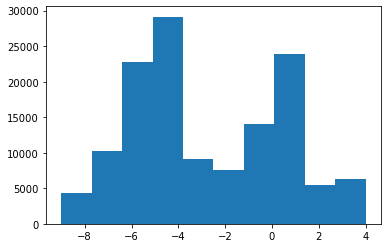

In [246]:
plt.hist(result["Cloud"] - result["전운량(10분위)"])

쌍봉 분포를 보인다. 

차이가 전혀 없는 경우(평균이 0인 정규분포)와 차이가 5~6정도 나는 경우(평균이 5인 정규분포)로 나뉘는 것으로 보인다.

In [1141]:
scipy.stats.kstest((result["Cloud"] - result["전운량(10분위)"]).dropna(), "norm")

KstestResult(statistic=0.6030162321799689, pvalue=0.0)

아쉽게도, 잔차는 정규분포를 따르지 않는다.

In [1142]:
result[(result["Cloud"] - result["전운량(10분위)"]) == -5]

,지점,지점명,forecast,기온(°C),풍속(m/s),풍향(16방위),습도(%),전운량(10분위),Forecast time,Temperature,Humidity,WindSpeed,WindDirection,Cloud
25226,129,서산,2018-08-03 15:00:00,34.6,3.6,250.0,54.0,6.0,2018-08-01 05:00:00,34.0,55.0,4.1,269.0,1.0
25227,129,서산,2018-08-03 15:00:00,34.6,3.6,250.0,54.0,6.0,2018-08-01 08:00:00,34.0,55.0,4.1,269.0,1.0
25228,129,서산,2018-08-03 15:00:00,34.6,3.6,250.0,54.0,6.0,2018-08-01 11:00:00,33.0,55.0,4.1,269.0,1.0
25229,129,서산,2018-08-03 15:00:00,34.6,3.6,250.0,54.0,6.0,2018-08-01 14:00:00,33.0,55.0,4.1,269.0,1.0
25230,129,서산,2018-08-03 15:00:00,34.6,3.6,250.0,54.0,6.0,2018-08-01 17:00:00,33.0,55.0,2.4,294.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174822,129,서산,2021-01-31 18:00:00,7.8,2.0,200.0,70.0,8.0,2021-01-30 02:00:00,6.0,75.0,2.9,180.0,3.0
174831,129,서산,2021-01-31 18:00:00,7.8,2.0,200.0,70.0,8.0,2021-01-31 05:00:00,6.0,75.0,3.3,168.0,3.0
174832,129,서산,2021-01-31 18:00:00,7.8,2.0,200.0,70.0,8.0,2021-01-31 08:00:00,6.0,75.0,3.3,168.0,3.0
174833,129,서산,2021-01-31 18:00:00,7.8,2.0,200.0,70.0,8.0,2021-01-31 11:00:00,6.0,75.0,3.3,168.0,3.0


<AxesSubplot:>

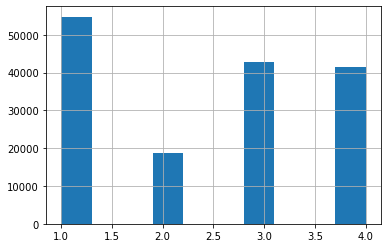

In [1143]:
result["Cloud"].hist()

<AxesSubplot:>

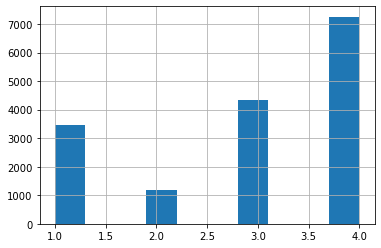

In [1144]:
result[(result["Cloud"] - result["전운량(10분위)"]) == -5]["Cloud"].hist()

<AxesSubplot:>

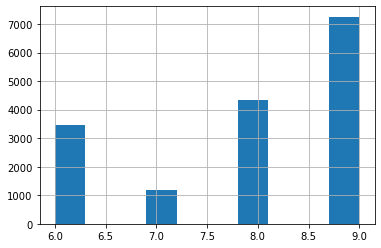

In [1145]:
result[(result["Cloud"] - result["전운량(10분위)"]) == -5]["전운량(10분위)"].hist()

전운량의 예측은 1 ~ 4밖에 없다. 

예측 오차가 크게 나는 경우는 실제 전운량이 6 이상으로 나타나는 경우였다.

## 2) 변수 선별

### (1) 변수 선별용 데이터 전처리

#### - X, y 데이터 생성

In [29]:
temp = corr_time(14)[2]

C:\Users\User\anaconda3\lib\site-packages\pandas\core\arrays\datetimelike.py:1342: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  warnings.warn(
<ipython-input-17-b2453c6ebcae>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dangjin_fcst_['Forecast time'] = dangjin_fcst_['Forecast time'] + dangjin_fcst_['forecast'].map(to_date)
<ipython-input-17-b2453c6ebcae>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ulsan_fcst_['Forecast time'] = ulsan_fcst_['Forecast t

In [30]:
energy["time"] = pd.to_datetime(energy["time"])

In [31]:
energy_obs = pd.merge(energy, temp, left_on = "time", right_on = "Forecast time", how = "left")

In [32]:
energy_obs = energy_obs.dropna().reset_index(drop = True)

In [33]:
energy_obs['date'] = energy_obs['Forecast time'].dt.date
energy_obs['hour'] = energy_obs['Forecast time'].dt.hour

energy_obs['year'] = energy_obs['Forecast time'].dt.year
energy_obs["year"] = energy_obs["year"].astype("str").apply(lambda x : x[2:4]).astype("int")
energy_obs['month'] =energy_obs['Forecast time'].dt.month
energy_obs['day'] = energy_obs['Forecast time'].dt.day

In [34]:
energy_obs = energy_obs[["Forecast time","dangjin","dangjin_warehouse","dangjin_floating","ulsan","hour","year","month","day","Temperature","Humidity","WindSpeed","WindDirection","Cloud"]]

In [35]:
sun_result = pd.merge(pd.read_csv("sun_result_dangjin.csv", names = ["Forecast_time", "sun_dangjin"], header = 0),
         pd.read_csv("sun_result_ulsan.csv", names = ["Forecast_time", "sun_ulsan"], header = 0))

In [36]:
sun_result_boruta = sun_result.copy()
sun_result_boruta.columns = ["Forecast time","sun_dangjin","sun_ulsan"]
sun_result_boruta["Forecast time"] = pd.to_datetime(sun_result_boruta["Forecast time"])

In [37]:
energy_obs = pd.merge(energy_obs, sun_result_boruta, how = "left")

#### - 일출 일몰 정보 생성

### (2) Boruta 알고리즘 활용

In [39]:
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy

sites = ["dangjin","dangjin_warehouse","dangjin_floating","ulsan"]
sun_target = ["sun_dangjin","sun_dangjin","sun_dangjin","sun_ulsan"]

Boruta_col = DataFrame()

for i , j in zip(sites, sun_target):

    forest = RandomForestRegressor(n_jobs=-1, max_depth=5, random_state = 42)
    forest.fit(energy_obs[["hour","year","month","day","Temperature","Humidity","WindSpeed", "Cloud",j]], 
               energy_obs[i].to_numpy())

    feat_selector = BorutaPy(forest, 
                             n_estimators='auto',
                             verbose=2, 
                             random_state=42)

    # find all relevant features
    feat_selector.fit(energy_obs[["hour","year","month","day","Temperature","Humidity","WindSpeed","Cloud",j]].to_numpy(), 
                      energy_obs[i].to_numpy())

    # check selected features
    feat_selector.support_

    # check ranking of features
    feat_selector.ranking_

    # call transform() on X to filter it down to selected features
    X_filtered = feat_selector.transform(energy_obs[["hour","year","month","day","Temperature","Humidity","WindSpeed", "Cloud",j]].to_numpy())
    
    temp = DataFrame(list(feat_selector.support_)).T
    temp.columns = ["hour","year","month","day","Temperature","Humidity","WindSpeed", "Cloud",j]

    Boruta_col = pd.concat([Boruta_col, temp])
    
Boruta_col.index = sites

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	6
Tentative: 	2
Rejected: 	1
Iteration: 	9 / 100
Confirmed: 	6
Tentative: 	2
Rejected: 	1
Iteration: 	10 / 100
Confirmed: 	6
Tentative: 	2
Rejected: 	1
Iteration: 	11 / 100
Confirmed: 	6
Tentative: 	2
Rejected: 	1
Iteration: 	12 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	2
Iteration: 	13 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	2
Iteration: 	14 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	2
Iteration: 	15 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	2
Iteration: 	16 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	2
Iteration: 	17 / 

Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	2
Iteration: 	9 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	2
Iteration: 	10 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	2
Iteration: 	11 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	2
Iteration: 	12 / 100
Confirmed: 	6
Tentative: 	0
Rejected: 	3


BorutaPy finished running.

Iteration: 	13 / 100
Confirmed: 	6
Tentative: 	0
Rejected: 	3


In [40]:
Boruta_col = Boruta_col.fillna(False)

In [41]:
Boruta_col

,hour,year,month,day,Temperature,Humidity,WindSpeed,Cloud,sun_dangjin,sun_ulsan
dangjin,True,False,True,False,True,True,True,True,True,False
dangjin_warehouse,True,False,True,False,True,True,False,True,True,False
dangjin_floating,True,False,True,True,True,True,False,True,True,False
ulsan,True,False,True,False,True,True,False,True,False,True


공통적으로 활용 가능한 변수는 Hour, Month, Temperature, Humidity, Cloud, Sun_dangjin, Sun_ulsan 이다.

## 3) 기타

### (1) 위치 정보

In [70]:
site_info

,Id,Capacity,Address,InstallationAngle,IncidentAngle,Latitude,Longitude
0,당진수상태양광,1.0,충남 당진시 석문면 교로길 30,30.0,30.0,37.050753,126.510299
1,당진자재창고태양광,0.7,충남 당진시 석문면 교로길 30,30.0,30.0,37.050753,126.510299
2,당진태양광,1.0,충남 당진시 석문면 교로길 30,30.0,30.0,37.050753,126.510299
3,울산태양광,0.5,울산광역시 남구 용잠로 623,20.0,20.0,35.477651,129.380778


## (2) 월별 발전량

In [310]:
energy[["time","dangjin_warehouse"]]

,time,dangjin_warehouse
0,2018-03-01 1:00:00,0.0
1,2018-03-01 2:00:00,0.0
2,2018-03-01 3:00:00,0.0
3,2018-03-01 4:00:00,0.0
4,2018-03-01 5:00:00,0.0
...,...,...
25627,2021-01-31 20:00:00,0.0
25628,2021-01-31 21:00:00,0.0
25629,2021-01-31 22:00:00,0.0
25630,2021-01-31 23:00:00,0.0


## (3) 오토인코더 스무딩

In [50]:
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_fcst, target='dangjin', 
                                              sun_target = "sun_dangjin")

In [51]:
class auto_encoder(tf.keras.Model):
    def __init__(self, 
                 dense_dim):        
        super(auto_encoder, self).__init__()
        self.dense_dim = dense_dim
     
    def build(self, input_shape):
    
        self.input_dense = tf.keras.layers.Dense(self.dense_dim, 
                                      activation = "relu")
        self.dense_input_1 = tf.keras.layers.Dense(int(self.dense_dim / 2),
                                                  activation = "relu")
        self.dense_input_2 = tf.keras.layers.Dense(int(self.dense_dim / 4),
                                                  activation = "relu")
        self.dense_embedding = tf.keras.layers.Dense(int(self.dense_dim / 6),
                                                    activation = "relu")
        self.dense_output_1 = tf.keras.layers.Dense(int(self.dense_dim / 4),
                                                  activation = "relu")
        self.dense_output_2 = tf.keras.layers.Dense(int(self.dense_dim / 2),
                                          activation = "relu")
        self.output_dense = tf.keras.layers.Dense(self.dense_dim,
                                                 activation = "relu")
        self.ae_output = tf.keras.layers.Dense(1,
                                      activation = "relu")
    
    def call(self, input_tensor):       
        input_output = self.input_dense(input_tensor)        
        output = self.dense_input_1(input_output)
        output = self.dense_input_2(output)
        output = self.dense_embedding(output)        
        output = self.dense_output_1(output)        
        output = self.dense_output_2(output)        
        output = self.output_dense(output)        
        output = self.ae_output(output)        
        return output

In [52]:
Auto_Encoder = auto_encoder(100)

In [53]:
def nmae_10(y_true, y_pred):
    
    y_true = y_true * (train_max - train_min) + train_min
    y_pred = y_pred * (train_max - train_min) + train_min
    
    absolute_error = abs(y_true - y_pred)
    
    return absolute_error

In [54]:
@tf.function()
def training_auto_encoder(inp , tar):
    with tf.GradientTape() as tape:
        
        output = Auto_Encoder(inp)

        loss =  loss_function(tar, output)
    
    gradients = tape.gradient(loss, Auto_Encoder.trainable_variables)
    optimizer.apply_gradients(zip(gradients, Auto_Encoder.trainable_variables))
  
    train_loss(loss)
    train_accuracy(tf.numpy_function(nmae_10, 
                                     [tar, output], 
                                     tf.float32))

In [55]:
def val_accuracy(inp, tar, Models):
    output = Auto_Encoder(inp)
    
    test_accuracy(tf.numpy_function(nmae_10, 
                                     [tar, output], 
                                     tf.float32))

In [56]:
EPOCHS = 200
batch_size = 50

In [57]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name = "test_loss")
test_accuracy = tf.keras.metrics.Mean(name = "test_accuracy")
 
loss_function = tf.keras.losses.MeanAbsoluteError(reduction = tf.keras.losses.Reduction.NONE)
accuracy_function = tf.keras.metrics.MeanAbsoluteError()
 
optimizer = tf.keras.optimizers.Adam()

train_max = 100
train_min = -9

training_auto_encoder(tf.Variable(train_x[1:2,:], dtype = tf.float32), 
                      tf.Variable(train_y[1:2], dtype = tf.float32))

In [101]:
Auto_Encoder.load_weights("Auto_Encoder.h5")

In [102]:
'Temperature',
'Humidity', 
'WindSpeed', 
'Cloud',
'sun_target'

'sun_target'

In [103]:
dangjin_obs_eda = dangjin_obs[["일시","기온(°C)","풍속(m/s)","풍향(16방위)","습도(%)","전운량(10분위)"]]

dangjin_obs_eda.columns = ["Forecast_time","기온","풍속","풍향","습도","전운량"]

In [104]:
dangjin_fcst_eda = dangjin_fcst.copy()

In [105]:
dangjin_fcst_eda["Forecast_time"] = pd.to_datetime(dangjin_fcst_eda["Forecast_time"])

In [106]:
dangjin_obs_eda["Forecast_time"] = pd.to_datetime(dangjin_obs_eda["Forecast_time"])

<ipython-input-106-beccd54eb847>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dangjin_obs_eda["Forecast_time"] = pd.to_datetime(dangjin_obs_eda["Forecast_time"])


In [107]:
test = pd.merge(dangjin_fcst_eda, dangjin_obs_eda, how = "left").dropna()

test["Forecast_time"] = test["Forecast_time"].astype("str")

test['date'] = test['Forecast_time'].str.split(' ').str[0]
test['hour'] = test['Forecast_time'].str.split(' ').str[1].str.split(':').str[0].astype(int)

test['year'] = test['date'].str.split('-').str[0].apply(lambda x : x[2:4]).astype(int)
test['month'] = test['date'].str.split('-').str[1].astype(int)
test['day'] = test['date'].str.split('-').str[2].astype(int)

In [108]:
train_x = test[["Forecast_time","year","month","day","hour","Temperature","Humidity","WindSpeed","Cloud"]]

train_x = train_x[train_x["Forecast_time"] > '2021-01-01']

train_x = pd.merge(train_x, sun_result[["Forecast_time","sun_dangjin"]])

train_x = train_x.drop("Forecast_time",axis = 1)

In [110]:
train_min_dangjin = -9
train_max_dangjin = 100

train_x_scaled = (np.array(train_x) - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)

In [111]:
ae_result = Auto_Encoder(train_x_scaled) * (train_max - train_min) + train_min


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [115]:
ae_result = pd.DataFrame(np.array(ae_result))

ae_result.columns = [#"Temperature",
                     #"WindSpeed",
                     #"Humidity",
                     "Cloud",
                     #"sun_dangjin"
]

ae_result = pd.concat([test.loc[test["Forecast_time"] > '2021-01-01', "Forecast_time"].reset_index(drop = True), 
                       ae_result], axis = 1)

ae_result = pd.merge(test[["Forecast_time",
                           "기온",
                           "풍속",
                           "습도",
                           "전운량"]], ae_result)

Real_Temperature
1.6155465949820789


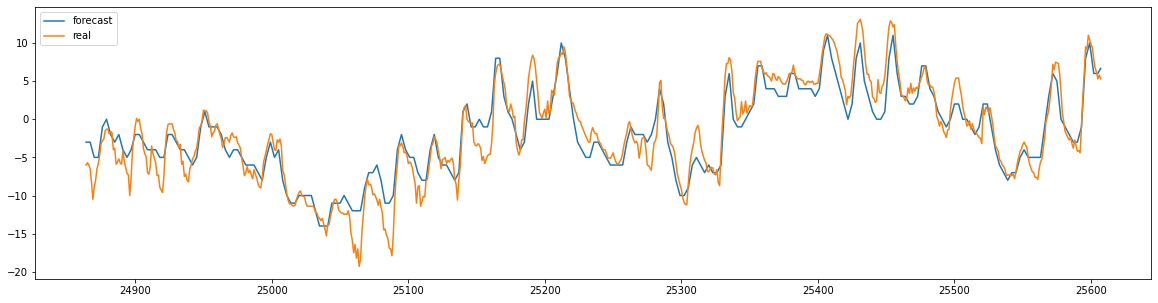

In [659]:
print("Real_Temperature")
print(np.mean(abs(test.loc[test["Forecast_time"] > '2021-01-01', "Temperature"] - (
    test.loc[test["Forecast_time"] > '2021-01-01', "기온"]))))

plt.figure(figsize = (20,5))
plt.plot(test.loc[test["Forecast_time"] > '2021-01-01', "Temperature"], label = "forecast")
plt.plot(test.loc[test["Forecast_time"] > '2021-01-01', "기온"], label = "real" )
plt.legend()
plt.show()

AE_Temperature
2.1987994041494168


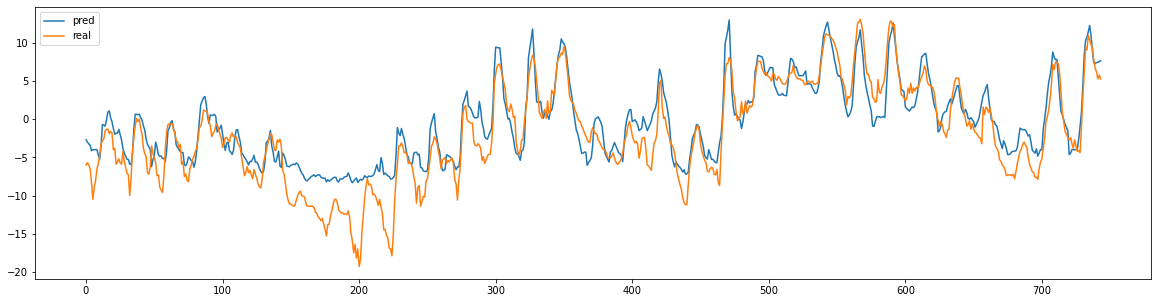

In [53]:
print("AE_Temperature")
print(np.mean(abs(ae_result["Temperature"] - ae_result["기온"])))

plt.figure(figsize = (20,5))
plt.plot(ae_result["Temperature"], label = "pred")
plt.plot(ae_result["기온"], label = "real")
plt.legend()
plt.show()

Real_WindSpeed
2.3500896057347687


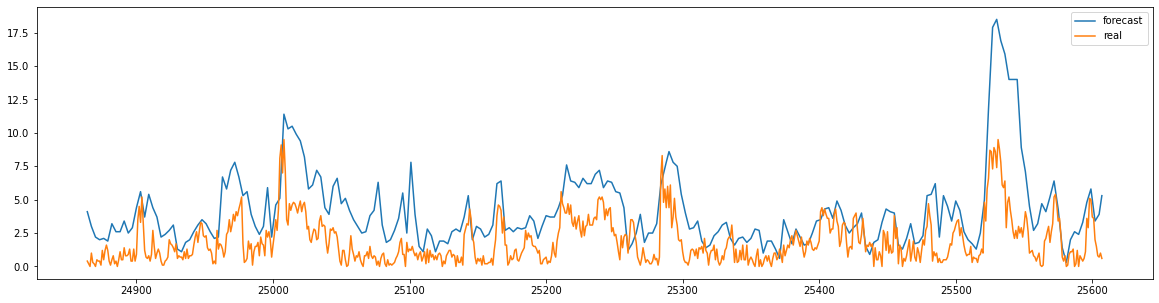

In [669]:
print("Real_WindSpeed")
print(np.mean(abs(test.loc[test["Forecast_time"] > '2021-01-01', "WindSpeed"] - (
    test.loc[test["Forecast_time"] > '2021-01-01', "풍속"]))))

plt.figure(figsize = (20,5))
plt.plot(test.loc[test["Forecast_time"] > '2021-01-01', "WindSpeed"], label = "forecast")
plt.plot(test.loc[test["Forecast_time"] > '2021-01-01', "풍속"], label = "real")
plt.legend()
plt.show()

AE_Windspeed
1.2327932914098103


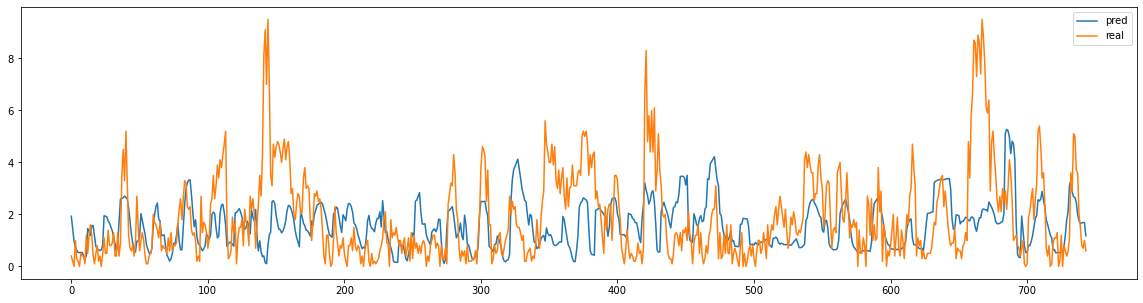

In [668]:
print("AE_Windspeed")
print(np.mean(abs(ae_result["풍속"] - ae_result["WindSpeed"])))
plt.figure(figsize = (20,5))
plt.plot(ae_result["WindSpeed"], label = "pred")
plt.plot(ae_result["풍속"], label = "real")
plt.legend()
plt.show()

Real_Humidity
10.404121863799283


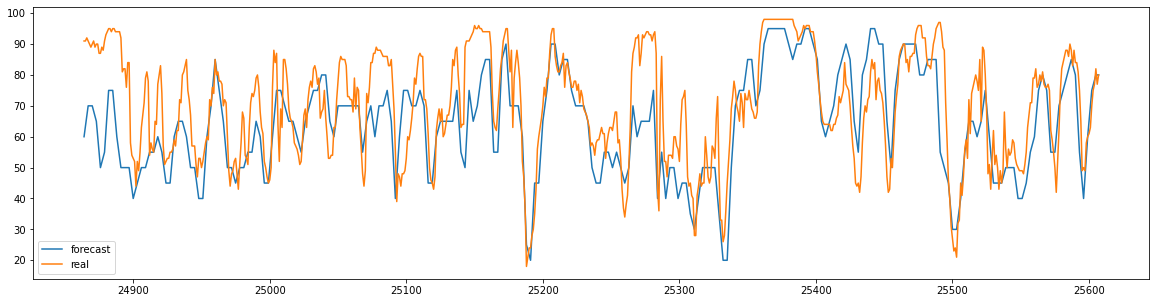

In [665]:
print("Real_Humidity")
print(np.mean(abs(test.loc[test["Forecast_time"] > '2021-01-01', "Humidity"] - (
    test.loc[test["Forecast_time"] > '2021-01-01', "습도"]))))

plt.figure(figsize = (20,5))
plt.plot(test.loc[test["Forecast_time"] > '2021-01-01', "Humidity"], label = "forecast")
plt.plot(test.loc[test["Forecast_time"] > '2021-01-01', "습도"], label = "real")
plt.legend()
plt.show()

Ae_Humidity
10.467136813748267


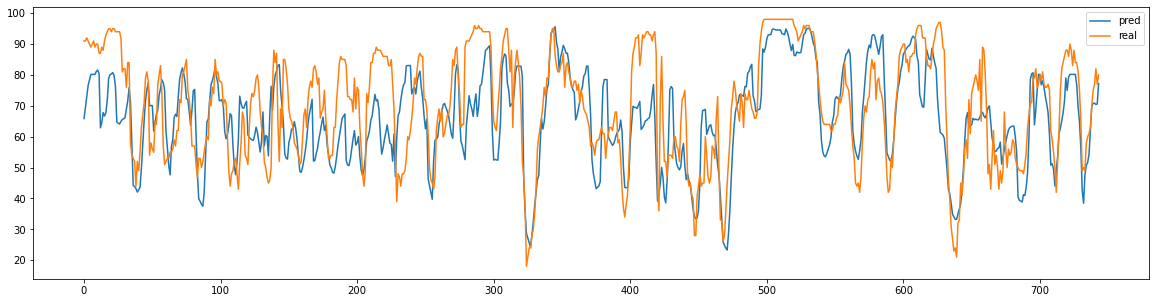

In [666]:
print("Ae_Humidity")
print(np.mean(abs(ae_result["습도"] - ae_result["Humidity"])))

plt.figure(figsize = (20,5))
plt.plot(ae_result["Humidity"], label = "pred")
plt.plot(ae_result["습도"], label = "real")
plt.legend()
plt.show()

In [147]:
i = 12

Real_Cloud
3.629480286738351


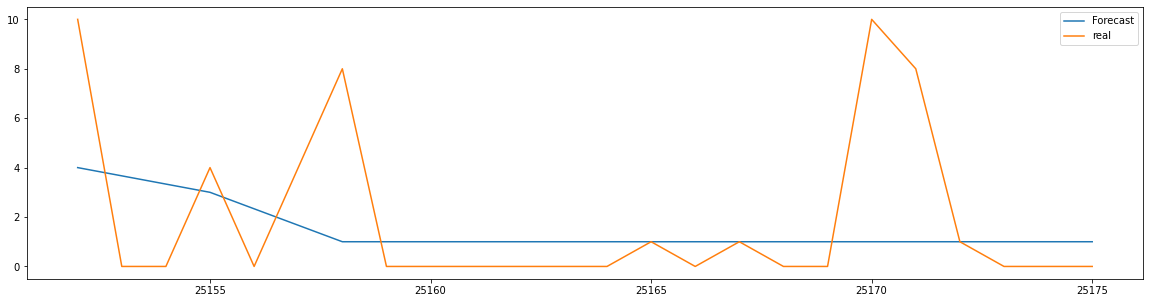

In [148]:
print("Real_Cloud")
print(np.mean(abs(test.loc[test["Forecast_time"] > '2021-01-01', "Cloud"] - (
    test.loc[test["Forecast_time"] > '2021-01-01', "전운량"]))))

plt.figure(figsize = (20,5))

plt.plot(test.loc[test["Forecast_time"] > '2021-01-01', "Cloud"][i * 24 : (i + 1) * 24], label = "Forecast")
plt.plot(test.loc[test["Forecast_time"] > '2021-01-01', "전운량"][i * 24 : (i + 1) * 24], label = "real")
plt.legend()

AE_cloud
2.6709070192870272


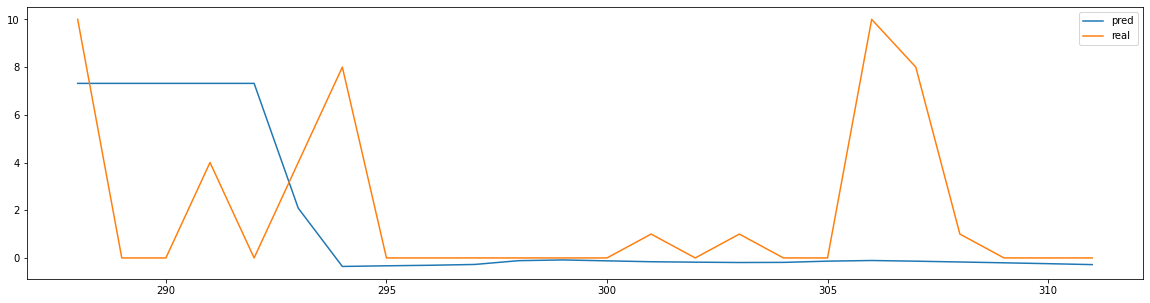

In [149]:
print("AE_cloud")
print(np.mean(abs(ae_result["전운량"] - ae_result["Cloud"])))

plt.figure(figsize = (20,5))
plt.plot(ae_result["Cloud"][i * 24 : (i + 1) * 24], label = "pred")
plt.plot(ae_result["전운량"][i * 24 : (i + 1) * 24], label = "real")
plt.legend()


In [146]:
ae_result[["전운량","Cloud"]].corr()

,전운량,Cloud
전운량,1.000000,0.514592
Cloud,0.514592,1.000000


# 3. 데이터 전처리

### (1) 데이터 시간형 처리

In [34]:
dangjin_fcst['Forecast_time'] = pd.to_datetime(dangjin_fcst['Forecast time'])
ulsan_fcst['Forecast_time'] = pd.to_datetime(ulsan_fcst['Forecast time'])

In [35]:
dangjin_obs['Forecast_time'] = pd.to_datetime(dangjin_obs['일시'])
ulsan_obs['Forecast_time'] = pd.to_datetime(ulsan_obs['일시'])

### (2)데이터 보간

#### - 20시 예보 데이터 선별

In [36]:
dangjin_fcst_14 = dangjin_fcst[dangjin_fcst['Forecast_time'].dt.hour==20]
ulsan_fcst_14 = ulsan_fcst[ulsan_fcst['Forecast_time'].dt.hour==20]

#### - 24시(자정) 부터 23시까지 데이터 선별

In [37]:
dangjin_fcst_14 = dangjin_fcst_14[(dangjin_fcst_14['forecast']>=(24 - 20))&(dangjin_fcst_14['forecast']<=(48 - 1 - 20))]
ulsan_fcst_14 = ulsan_fcst_14[(ulsan_fcst_14['forecast']>=(24 - 20))&(ulsan_fcst_14['forecast']<=(48 - 1 - 20))]

In [38]:
def to_date(x):
    return pd.DateOffset(hours=x)

dangjin_fcst_14['Forecast_time'] = dangjin_fcst_14['Forecast_time'] + dangjin_fcst_14['forecast'].map(to_date)
ulsan_fcst_14['Forecast_time'] = ulsan_fcst_14['Forecast_time'] + ulsan_fcst_14['forecast'].map(to_date)

C:\Users\User\anaconda3\lib\site-packages\pandas\core\arrays\datetimelike.py:1342: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  warnings.warn(


In [39]:
dangjin_fcst_14 = dangjin_fcst_14[['Forecast_time', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]
ulsan_fcst_14 = ulsan_fcst_14[['Forecast_time', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]

#### - 세 시간 간격 데이터를 한 시간 간격으로 변환

In [40]:
dangjin_fcst_14_ = pd.DataFrame()
dangjin_fcst_14_['Forecast_time'] = pd.date_range(start='2018-03-02 00:00:00', end='2021-03-01 23:00:00', freq='H')

ulsan_fcst_14_ = pd.DataFrame()
ulsan_fcst_14_['Forecast_time'] = pd.date_range(start='2018-03-02 00:00:00', end='2021-03-01 23:00:00', freq='H')

In [41]:
dangjin_fcst_14_ = pd.merge(dangjin_fcst_14_, dangjin_fcst_14, on='Forecast_time', how='outer')
ulsan_fcst_14_ = pd.merge(ulsan_fcst_14_, ulsan_fcst_14, on='Forecast_time', how='outer')

#### - 보간법 적용(default = 선형 보간)

In [42]:
dangjin_fcst = dangjin_fcst_14_.interpolate()
ulsan_fcst = ulsan_fcst_14_.interpolate()

In [43]:
dangjin_fcst['Forecast_time'] = dangjin_fcst['Forecast_time'].astype(str)
ulsan_fcst['Forecast_time'] = ulsan_fcst['Forecast_time'].astype(str)

#### - 전운량 결측 대체

In [44]:
energy = energy.dropna().reset_index(drop = True)

In [45]:
dangjin_obs = dangjin_obs.dropna(axis = 0, subset = ["기온(°C)","풍속(m/s)", "습도(%)", "전운량(10분위)"]).reset_index(drop = True)

In [46]:
ulsan_obs = ulsan_obs.dropna(axis = 0, subset = ["기온(°C)","풍속(m/s)", "습도(%)", "전운량(10분위)"]).reset_index(drop = True)

In [47]:
dangjin_obs = dangjin_obs.rename(columns = {
                             "기온(°C)" : "Temperature",
                             "풍속(m/s)" : "WindSpeed",
                             "풍향(16방위)" : "WindDirection",
                             "습도(%)" : "Humidity",
                             "전운량(10분위)" : "Cloud"}).drop(["지점","지점명"], axis = 1)

In [48]:
ulsan_obs = ulsan_obs.rename(columns = {
                             "기온(°C)" : "Temperature",
                             "풍속(m/s)" : "WindSpeed",
                             "풍향(16방위)" : "WindDirection",
                             "습도(%)" : "Humidity",
                             "전운량(10분위)" : "Cloud"}).drop(["지점","지점명"], axis = 1)

### (3)학습 데이터 전처리

In [49]:
# 바람 방향 더미변수화

def direction_label(x):
    
    if x < 0:
        return 0
    if x <= 45  and x >= 0:
        return 0
    if x <= 90  and x > 45 :
        return 1
    if x <= 135  and x > 90 :
        return 2
    if x <= 180 and x > 135 :
        return 3
    if x <= 225 and x > 180 :
        return 4
    if x <= 270 and x > 225 :
        return 5
    if x <= 315 and x > 270 :
        return 6
    if x <= 360 and x > 315 :
        return 7   
    if x > 360:
        return 7

In [50]:
sun_result = pd.merge(pd.read_csv("sun_result_dangjin.csv", names = ["Forecast_time", "sun_dangjin"], header = 0),
         pd.read_csv("sun_result_ulsan.csv", names = ["Forecast_time", "sun_ulsan"], header = 0))

In [51]:
def zero_zero_replacer(x):
    x[0] = '0'
    x = x[0] + ":" + x[1] + ":" + x[2]
    return x

In [52]:
def train_datast(energy_df_, fcst, target, sun_target):
    
    energy_df = energy_df_.copy()
    # 일기 예보 있는 날짜만 선택
    #energy = energy_df.loc[24:]
    #energy.index = range(energy.shape[0])
    
    # 발전량 데이터가 있는 날짜만 선택
    #fcst = fcst_df.loc[:25608-1]
    #fcst.index = range(fcst.shape[0])
    
    # 발전량과 일기예보 연결
    
    index = energy["time"].str.split(" ").apply(lambda x : x[1]).str.split(":").apply(lambda x : x[0]) == '24'
    
    temp = energy_df.loc[index,"time"]

    energy_df.loc[index, "time"] = (pd.to_datetime(temp.str.split(" ").apply(lambda x : x[0])) + pd.Timedelta(1, unit = "d")).astype("str") + ' ' + (
        temp.str.split(" ").apply(lambda x : x[1]).str.split(":").apply(lambda x : zero_zero_replacer(x)))
    
    energy_df["Forecast_time"] = pd.to_datetime(energy_df["time"])
    fcst["Forecast_time"] = pd.to_datetime(fcst["Forecast_time"])
    
    concat_df = pd.merge(energy_df, fcst, how = "right").dropna()
    
    concat_df["Forecast_time"] = concat_df["Forecast_time"].astype("str")
    
    # 예보 시간 및 날짜 정보 feature로 추가
    concat_df['date'] = concat_df['Forecast_time'].str.split(' ').str[0]
    concat_df['hour'] = concat_df['Forecast_time'].str.split(' ').str[1].str.split(':').str[0].astype(int)
    
    concat_df['year'] = concat_df['date'].str.split('-').str[0].astype(int)
    concat_df['month'] = concat_df['date'].str.split('-').str[1].astype(int)
    concat_df['day'] = concat_df['date'].str.split('-').str[2].astype(int)
    
    concat_df["WindDirection"] = concat_df["WindDirection"].apply(lambda x : direction_label(x)).astype(int)
    
    concat_df = pd.get_dummies(concat_df, prefix = "WindDirection", columns = ["WindDirection"])
    
    concat_df = pd.merge(concat_df, sun_result, how = "left")
    
    # 예보 시간, 날짜, 기상 예보 및 발전량 선택
    feature_df = concat_df[['year', 
                            'month', 
                            'day', 
                            'hour', 
                            'Temperature',
                            'Humidity', 
                            'WindSpeed', 
                            'Cloud',
                            sun_target,
                            target]]
    
    # 마지막 30일을 검증데이터셋으로 나머지를 학습 데이터셋으로 선택
    
    train_df = feature_df.iloc[:-24*30]
    val_df = feature_df.iloc[-24*30:]
    
    # 발전량이 0인 데이터를 제외
    #train_df = train_df[train_df[target]!=0]
    
    train_x = train_df.loc[:, 'year':str(sun_target)].to_numpy()
    train_y = train_df[target].to_numpy()
    
    val_x = val_df.loc[:, 'year':str(sun_target)].to_numpy()
    val_y = val_df[target].to_numpy()
    
    return train_x, train_y, val_x, val_y

In [53]:
energy[energy["time"].str.slice(0,10) == '2020-03-01']

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
17496,2020-03-01 1:00:00,0.0,0.0,0,0
17497,2020-03-01 2:00:00,0.0,0.0,0,0
17498,2020-03-01 3:00:00,0.0,0.0,0,0
17499,2020-03-01 4:00:00,0.0,0.0,0,0
17500,2020-03-01 5:00:00,0.0,0.0,0,0
17501,2020-03-01 6:00:00,0.0,0.0,0,0
17502,2020-03-01 7:00:00,0.0,0.0,0,0
17503,2020-03-01 8:00:00,1.0,1.0,0,0
17504,2020-03-01 9:00:00,29.0,20.0,13,12
17505,2020-03-01 10:00:00,115.0,77.0,104,32


# 4. 모델링 

## 1) XGBOOST

In [133]:
import xgboost as xgb

### (1) 파라미터 튜닝

#### - 당진 태양광

In [72]:
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_fcst, target='dangjin')

In [162]:
def XGB_cv(learning_rate, 
           min_child_weight,
           subsample,
           colsample_bytree,
           reg_alpha,
           reg_lambda,
           silent=True, 
           nthread=-1):
    
    model = xgb.XGBRegressor(booster = "gbtree",
              objective = "reg:squarederror",
              n_jobs = -1,
              random_state = 42,
              learning_rate = learning_rate,
              min_child_weight = min_child_weight,
              subsample = subsample,
              colsample_bytree = colsample_bytree,
              reg_alpha = reg_alpha,
              reg_lambda = reg_lambda)
    
    model.fit(train_x, train_y)

    y_pred = model.predict(val_x)

    mae = np.mean(nmae_10(val_y, y_pred))

    return 1/mae

In [163]:
import scipy.optimize as optimize
from bayes_opt import BayesianOptimization

params = {"learning_rate": (0.0001, 0.2),
            "min_child_weight" : (1, 100),
            "subsample" : (0, 1),
           "colsample_bytree" : (0, 1),
           "reg_alpha" : (0 , 1),
           "reg_lambda" : (0 , 1),
            }

capacity = 1000
train_max = 1
train_min = 0

bo=BayesianOptimization(f=XGB_cv, 
                        pbounds=params, 
                        verbose=2, 
                        random_state=42)

bo.maximize(init_points=2, n_iter=300, acq='ei', xi=0.01)

print(bo.max)

|   iter    |  target   | colsam... | learni... | min_ch... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------
|  1        |  0.09653  |  0.3745   |  0.1901   |  73.47    |  0.5987   |  0.156    |  0.156    |
|  2        |  0.07826  |  0.05808  |  0.1732   |  60.51    |  0.7081   |  0.02058  |  0.9699   |
|  3        |  0.09919  |  0.5739   |  0.09841  |  73.59    |  0.5667   |  0.2716   |  0.1455   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  4        |  0.02544  |  1.0      |  0.0001   |  74.61    |  0.1952   |  1.0      |  0.4726   |
|  5        |  0.02518  |  0.9597   |  0.0001   |  73.16    |  0.7785   |  0.06238  |  0.0      |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  6        |  0.09563  |  0.7896   |  0.1071   |  89.58    |  0.4574   |  0.4225   |  0.6538   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  7        |  0.1031   |  0.5869   |  0.1249   |  89.67    |  0.3559   |  0.3239   |  0.4545   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  8        |  0.1021   |  0.7282   |  0.08741  |  42.76    |  0.03042  |  0.07563  |  0.6663   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  9        |  0.09406  |  0.4255   |  0.1867   |  73.68    |  0.243    |  0.2251   |  0.364    |
|  10       |  0.09467  |  0.7374   |  0.1583   |  58.06    |  0.3905   |  0.5723   |  0.07446  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  11       |  0.08616  |  0.136    |  0.1502   |  73.81    |  0.6679   |  0.4682   |  0.2588   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  12       |  0.09994  |  0.8755   |  0.06698  |  34.26    |  0.9408   |  0.5476   |  0.2241   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  13       |  0.09159  |  0.2926   |  0.09341  |  89.69    |  0.4671   |  0.6019   |  0.2073   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  14       |  0.09267  |  0.8136   |  0.1952   |  89.92    |  0.226    |  0.3371   |  0.2037   |
|  15       |  0.09938  |  0.3473   |  0.1355   |  49.24    |  0.09166  |  0.01519  |  0.2208   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  16       |  0.09793  |  0.8351   |  0.08964  |  89.57    |  0.4606   |  0.3907   |  0.4481   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  17       |  0.09945  |  0.5041   |  0.05526  |  89.28    |  0.1284   |  0.08711  |  0.4      |
|  18       |  0.06615  |  0.2258   |  0.0212   |  16.63    |  0.5356   |  0.7926   |  0.7528   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  19       |  0.09758  |  0.7793   |  0.08363  |  42.22    |  0.1759   |  0.2928   |  0.6832   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  20       |  0.08763  |  0.2732   |  0.06349  |  42.65    |  0.03843  |  0.3251   |  0.3497   |
|  21       |  0.09064  |  0.9144   |  0.02664  |  50.44    |  0.775    |  0.5035   |  0.08215  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  22       |  0.09609  |  1.0      |  0.2      |  42.69    |  0.3793   |  0.0      |  1.0      |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  23       |  0.02539  |  0.2297   |  0.0001   |  89.8     |  0.2427   |  0.0      |  0.6942   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  24       |  0.09587  |  0.6122   |  0.2      |  89.41    |  0.1994   |  0.4216   |  0.3122   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  25       |  0.09298  |  0.8934   |  0.1879   |  43.02    |  0.2873   |  0.2566   |  0.7405   |
|  26       |  0.07015  |  0.0655   |  0.0637   |  43.87    |  0.9987   |  0.06431  |  0.6962   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  27       |  0.09909  |  0.8219   |  0.04917  |  89.64    |  0.3873   |  0.4799   |  0.6528   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  28       |  0.09313  |  0.9406   |  0.1548   |  42.53    |  0.3344   |  0.1793   |  0.3494   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  29       |  0.08508  |  0.4654   |  0.02551  |  42.31    |  0.1292   |  0.01779  |  0.9471   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  30       |  0.08227  |  0.419    |  0.02701  |  88.79    |  0.2708   |  0.2041   |  0.3578   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  31       |  0.09561  |  0.6791   |  0.2      |  89.84    |  0.3755   |  0.7277   |  0.4805   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  32       |  0.08277  |  0.7197   |  0.01854  |  42.69    |  0.0919   |  0.6225   |  0.7594   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  33       |  0.02544  |  0.9054   |  0.0001   |  89.36    |  0.03985  |  0.03466  |  0.2861   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  34       |  0.04802  |  0.694    |  0.006947 |  89.63    |  0.5677   |  0.508    |  0.224    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  35       |  0.09986  |  0.9144   |  0.04293  |  42.57    |  0.09628  |  0.1662   |  0.6679   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  36       |  0.06895  |  0.8298   |  0.01291  |  61.62    |  0.2701   |  0.5606   |  0.389    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  37       |  0.04214  |  0.1818   |  0.007194 |  61.15    |  0.436    |  0.005691 |  0.2758   |
|  38       |  0.09438  |  0.3675   |  0.0929   |  79.19    |  0.5605   |  0.1476   |  0.09186  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  39       |  0.08874  |  0.173    |  0.1589   |  54.97    |  0.414    |  0.2327   |  0.5347   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  40       |  0.09234  |  0.8142   |  0.02388  |  42.81    |  0.1865   |  0.06429  |  0.6706   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  41       |  0.1005   |  0.5669   |  0.1934   |  42.59    |  0.1473   |  0.08762  |  0.4689   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  42       |  0.09628  |  0.8388   |  0.09972  |  89.72    |  0.2922   |  0.4028   |  0.5517   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  43       |  0.09847  |  0.5124   |  0.07293  |  89.39    |  0.1537   |  0.3737   |  0.5302   |
|  44       |  0.04698  |  0.7234   |  0.006811 |  50.15    |  0.9884   |  0.2663   |  0.0855   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  45       |  0.09602  |  0.8047   |  0.1578   |  9.976    |  0.04523  |  0.9082   |  0.6259   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  46       |  0.1006   |  0.9797   |  0.05516  |  16.51    |  0.7192   |  0.3153   |  0.8364   |
|  47       |  0.06755  |  0.1028   |  0.04498  |  99.38    |  0.8928   |  0.5614   |  0.8006   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  48       |  0.08431  |  0.1632   |  0.1662   |  7.232    |  0.4755   |  0.9014   |  0.6507   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  49       |  0.09932  |  0.5716   |  0.2      |  89.62    |  0.2473   |  0.5222   |  0.5187   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  50       |  0.08678  |  0.34     |  0.05383  |  6.161    |  0.9637   |  0.7775   |  0.07568  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  51       |  0.1003   |  0.7983   |  0.1841   |  42.61    |  0.1795   |  0.2431   |  0.8236   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  52       |  0.09587  |  0.4772   |  0.121    |  93.04    |  0.9091   |  0.7368   |  0.2277   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  53       |  0.09651  |  0.9124   |  0.1618   |  42.43    |  0.4939   |  0.1994   |  0.7809   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  54       |  0.09789  |  0.3696   |  0.2      |  89.3     |  0.2627   |  0.222    |  0.3799   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  55       |  0.09452  |  0.246    |  0.1629   |  28.52    |  0.7429   |  0.2182   |  0.2408   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  56       |  0.1014   |  1.0      |  0.0768   |  16.39    |  0.8291   |  0.02475  |  0.8812   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  57       |  0.05796  |  0.5265   |  0.01082  |  73.83    |  0.4733   |  0.07827  |  0.1145   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  58       |  0.08401  |  0.494    |  0.02621  |  73.54    |  0.5913   |  0.4442   |  0.5389   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  59       |  0.09186  |  0.4757   |  0.2      |  73.48    |  0.4478   |  0.4348   |  0.1405   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  60       |  0.0933   |  0.3599   |  0.07306  |  64.74    |  0.1573   |  0.6697   |  0.724    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  61       |  0.09981  |  0.5305   |  0.03785  |  8.896    |  0.5837   |  0.9471   |  0.5301   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  62       |  0.09849  |  0.7533   |  0.2      |  42.5     |  0.05332  |  0.02006  |  0.6635   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  63       |  0.09975  |  0.8596   |  0.1581   |  16.69    |  0.7492   |  0.00901  |  0.9364   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  64       |  0.08614  |  0.3322   |  0.1159   |  6.416    |  0.1573   |  0.598    |  0.03289  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  65       |  0.09882  |  0.987    |  0.04665  |  16.21    |  0.8077   |  0.1877   |  0.6442   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  66       |  0.09799  |  0.7689   |  0.07394  |  74.19    |  0.654    |  0.4506   |  0.9827   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  67       |  0.09559  |  0.9593   |  0.2      |  42.74    |  0.0      |  0.08151  |  0.8944   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  68       |  0.08891  |  0.9296   |  0.1907   |  16.35    |  0.9705   |  0.3303   |  0.6735   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  69       |  0.07859  |  0.05103  |  0.1607   |  95.5     |  0.7986   |  0.8876   |  0.1228   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  70       |  0.0816   |  0.1468   |  0.1163   |  6.473    |  0.05488  |  0.5567   |  0.8923   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  71       |  0.09316  |  0.7918   |  0.02498  |  27.93    |  0.5402   |  0.6932   |  0.8324   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  72       |  0.101    |  0.5825   |  0.07669  |  42.31    |  0.0315   |  0.1242   |  0.4697   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  73       |  0.0983   |  0.8301   |  0.057    |  42.49    |  0.04147  |  0.1653   |  0.6525   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  74       |  0.1004   |  0.6569   |  0.1234   |  68.51    |  0.1527   |  0.03206  |  0.8713   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  75       |  0.09239  |  0.4574   |  0.03979  |  84.08    |  0.9243   |  0.4203   |  0.2469   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  76       |  0.09374  |  0.9805   |  0.02482  |  16.06    |  0.6675   |  0.2165   |  0.9857   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  77       |  0.09432  |  0.2782   |  0.1955   |  97.9     |  0.4314   |  0.87     |  0.3273   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  78       |  0.1007   |  0.8265   |  0.05049  |  16.6     |  0.4382   |  0.02401  |  0.531    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  79       |  0.09739  |  0.8651   |  0.1404   |  42.72    |  0.1174   |  0.3167   |  0.8279   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  80       |  0.1017   |  0.9214   |  0.05907  |  16.2     |  0.3857   |  0.006979 |  0.6543   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  81       |  0.09567  |  0.4341   |  0.173    |  93.04    |  0.883    |  0.7862   |  0.09098  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  82       |  0.09681  |  0.5818   |  0.1646   |  16.28    |  0.693    |  0.03959  |  0.7493   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  83       |  0.09398  |  0.9769   |  0.1467   |  16.45    |  0.5342   |  0.05027  |  0.7712   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  84       |  0.09737  |  0.8099   |  0.1561   |  16.35    |  0.2978   |  0.1268   |  0.3909   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  85       |  0.072    |  0.3711   |  0.02021  |  67.3     |  0.4023   |  0.7602   |  0.6288   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  86       |  0.09918  |  0.7833   |  0.03367  |  16.66    |  0.6744   |  0.242    |  0.6962   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  87       |  0.09904  |  0.6307   |  0.05244  |  16.08    |  0.3515   |  0.03926  |  0.5454   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  88       |  0.1005   |  0.9203   |  0.1341   |  16.76    |  0.9042   |  0.05815  |  0.6537   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  89       |  0.0946   |  0.3209   |  0.1862   |  4.622    |  0.1924   |  0.7872   |  0.1922   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  90       |  0.07419  |  0.000191 |  0.1177   |  28.58    |  0.446    |  0.302    |  0.7434   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  91       |  0.09758  |  0.679    |  0.07973  |  91.06    |  0.9111   |  0.5613   |  0.2366   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  92       |  0.1003   |  0.5189   |  0.0755   |  3.047    |  0.7095   |  0.9733   |  0.9788   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  93       |  0.02543  |  0.8043   |  0.0001   |  16.31    |  0.6401   |  0.0      |  0.4416   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  94       |  0.0977   |  0.3957   |  0.1203   |  86.99    |  0.914    |  0.4891   |  0.1803   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  95       |  0.08048  |  0.1145   |  0.1971   |  95.8     |  0.6663   |  0.1749   |  0.5593   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  96       |  0.09942  |  0.918    |  0.05156  |  81.32    |  0.7921   |  0.4866   |  0.2784   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  97       |  0.09126  |  0.2174   |  0.1891   |  44.2     |  0.482    |  0.6663   |  0.7939   |
|  98       |  0.05931  |  0.3073   |  0.1195   |  75.44    |  0.4111   |  0.1409   |  0.008914 |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  99       |  0.09559  |  0.8541   |  0.1238   |  16.29    |  0.265    |  0.1687   |  0.5913   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  100      |  0.09886  |  0.7743   |  0.1093   |  16.47    |  0.8885   |  0.1983   |  0.9628   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  101      |  0.1027   |  0.5624   |  0.123    |  37.73    |  0.6909   |  0.4027   |  0.6819   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  102      |  0.09533  |  0.4141   |  0.1353   |  86.93    |  0.8721   |  0.5747   |  0.08683  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  103      |  0.0943   |  0.9966   |  0.0906   |  13.88    |  0.3136   |  0.9246   |  0.4663   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  104      |  0.09965  |  0.7118   |  0.1399   |  16.02    |  0.1743   |  0.1618   |  0.811    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  105      |  0.08114  |  0.9646   |  0.01734  |  50.45    |  0.8031   |  0.4135   |  0.05538  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  106      |  0.1005   |  0.902    |  0.08063  |  67.44    |  0.01773  |  0.7126   |  0.8323   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  107      |  0.08376  |  0.2316   |  0.0689   |  34.03    |  0.9538   |  0.4925   |  0.6866   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  108      |  0.09565  |  0.821    |  0.1252   |  16.75    |  0.3662   |  0.09312  |  0.6296   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  109      |  0.07528  |  0.0248   |  0.1284   |  92.64    |  0.78     |  0.9468   |  0.1891   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  110      |  0.09745  |  0.5124   |  0.1828   |  37.82    |  0.8675   |  0.4451   |  0.7891   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  111      |  0.09702  |  0.4435   |  0.1494   |  80.49    |  0.9805   |  0.762    |  0.6933   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  112      |  0.1006   |  0.9552   |  0.06976  |  16.04    |  0.3975   |  0.07179  |  0.8968   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  113      |  0.09895  |  0.9083   |  0.1358   |  42.08    |  0.3514   |  0.9974   |  0.9883   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  114      |  0.1033   |  0.5096   |  0.1155   |  16.39    |  0.2872   |  0.02795  |  0.7497   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  115      |  0.0962   |  0.5166   |  0.163    |  16.57    |  0.1703   |  0.2022   |  0.611    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  116      |  0.09855  |  0.6153   |  0.1355   |  16.53    |  0.1989   |  0.06012  |  0.3511   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  117      |  0.1039   |  0.7484   |  0.09322  |  16.42    |  0.5074   |  0.2279   |  0.8455   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  118      |  0.09511  |  0.4053   |  0.09849  |  16.44    |  0.6147   |  0.1259   |  0.8509   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  119      |  0.09808  |  0.5474   |  0.1767   |  16.28    |  0.2381   |  0.1857   |  0.4855   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  120      |  0.1008   |  0.5692   |  0.03674  |  16.49    |  0.3444   |  0.02489  |  0.9389   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  121      |  0.09892  |  0.673    |  0.1639   |  16.06    |  0.4437   |  0.2513   |  0.8066   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  122      |  0.1019   |  0.5941   |  0.07223  |  15.88    |  0.4516   |  0.08123  |  0.8977   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  123      |  0.09293  |  0.3269   |  0.05532  |  16.04    |  0.3438   |  0.1121   |  0.6892   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  124      |  0.1008   |  0.9722   |  0.03558  |  16.54    |  0.6079   |  0.2072   |  0.8473   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  125      |  0.1006   |  0.7737   |  0.1273   |  16.5     |  0.2021   |  0.07664  |  0.8818   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  126      |  0.09394  |  0.6543   |  0.1859   |  37.78    |  0.6017   |  0.6271   |  0.9128   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  127      |  0.1012   |  0.4276   |  0.1681   |  37.59    |  0.7041   |  0.5345   |  0.4794   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  128      |  0.09853  |  0.5146   |  0.07208  |  70.36    |  0.144    |  0.2653   |  0.7994   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  129      |  0.08885  |  0.1529   |  0.1399   |  63.19    |  0.4156   |  0.3722   |  0.08119  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  130      |  0.09593  |  0.8153   |  0.1629   |  15.94    |  0.3307   |  0.0      |  0.6929   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  131      |  0.0943   |  0.3025   |  0.1303   |  37.92    |  0.6903   |  0.4594   |  0.5865   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  132      |  0.1009   |  0.5711   |  0.1454   |  89.34    |  0.1564   |  0.4401   |  0.5159   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  133      |  0.07863  |  0.461    |  0.02478  |  34.87    |  0.6294   |  0.4312   |  0.01726  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  134      |  0.1024   |  0.6742   |  0.04819  |  16.26    |  0.2636   |  0.1174   |  0.9664   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  135      |  0.09497  |  0.3703   |  0.1745   |  37.56    |  0.7044   |  0.234    |  0.5249   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  136      |  0.09519  |  0.7895   |  0.1906   |  37.53    |  0.4711   |  0.5196   |  0.4969   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  137      |  0.1016   |  0.6965   |  0.1481   |  37.5     |  0.8707   |  0.6317   |  0.7419   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  138      |  0.02542  |  0.7583   |  0.0001   |  16.2     |  0.2626   |  0.0      |  0.7798   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  139      |  0.09389  |  0.7269   |  0.06186  |  39.09    |  0.7655   |  0.01462  |  0.08551  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  140      |  0.1038   |  0.6215   |  0.1257   |  16.37    |  0.31     |  0.1793   |  0.9651   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  141      |  0.08435  |  0.5258   |  0.02176  |  37.47    |  0.8732   |  0.5655   |  0.7264   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  142      |  0.09854  |  0.7786   |  0.171    |  16.44    |  0.5618   |  0.05366  |  0.9574   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  143      |  0.0653   |  0.1188   |  0.03444  |  73.21    |  0.1422   |  0.2791   |  0.6556   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  144      |  0.07396  |  0.0558   |  0.0926   |  42.87    |  0.05842  |  0.2727   |  0.3507   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  145      |  0.02809  |  0.5795   |  0.001176 |  16.29    |  0.3018   |  0.2653   |  0.8642   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  146      |  0.07619  |  0.1451   |  0.04926  |  74.84    |  0.8648   |  0.5006   |  0.3617   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  147      |  0.09965  |  0.7386   |  0.04955  |  15.98    |  0.541    |  0.1513   |  0.9819   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  148      |  0.09377  |  0.7722   |  0.1212   |  34.86    |  0.02521  |  0.9552   |  0.0269   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  149      |  0.07107  |  0.318    |  0.02001  |  34.24    |  0.8824   |  0.3871   |  0.1529   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  150      |  0.04965  |  0.15     |  0.01078  |  48.25    |  0.9138   |  0.9731   |  0.6787   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  151      |  0.09757  |  0.7079   |  0.08495  |  42.36    |  0.2014   |  0.1666   |  0.5031   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  152      |  0.09611  |  0.7357   |  0.1881   |  98.18    |  0.5259   |  0.3763   |  0.9924   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  153      |  0.09276  |  0.7102   |  0.1937   |  16.02    |  0.2707   |  0.2195   |  0.9062   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  154      |  0.0765   |  0.8639   |  0.01584  |  23.52    |  0.4389   |  0.7163   |  0.4974   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  155      |  0.1006   |  0.4687   |  0.1852   |  37.7     |  0.733    |  0.4633   |  0.5977   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  156      |  0.08982  |  0.3005   |  0.08677  |  20.57    |  0.4744   |  0.2486   |  0.7109   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  157      |  0.06742  |  0.5358   |  0.0698   |  84.64    |  0.869    |  0.8103   |  0.01485  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  158      |  0.02992  |  0.6327   |  0.001815 |  59.35    |  0.436    |  0.5098   |  0.7181   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  159      |  0.07508  |  0.09125  |  0.1374   |  12.92    |  0.9314   |  0.1012   |  0.6966   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  160      |  0.07308  |  0.278    |  0.02539  |  7.761    |  0.207    |  0.8862   |  0.5114   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  161      |  0.09787  |  0.4134   |  0.1691   |  86.91    |  0.9468   |  0.6031   |  0.07169  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  162      |  0.09817  |  0.4157   |  0.1492   |  65.8     |  0.617    |  0.3205   |  0.9456   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  163      |  0.02805  |  0.9949   |  0.001103 |  16.08    |  0.4863   |  0.1081   |  0.6162   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  164      |  0.09617  |  0.8557   |  0.1809   |  16.34    |  0.3198   |  0.1233   |  0.6718   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  165      |  0.1023   |  0.6125   |  0.1051   |  16.06    |  0.5539   |  0.2084   |  0.8859   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  166      |  0.08817  |  0.436    |  0.03918  |  79.13    |  0.5705   |  0.1779   |  0.1258   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  167      |  0.09835  |  0.9592   |  0.192    |  16.55    |  0.817    |  0.07575  |  0.7933   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  168      |  0.09891  |  0.5643   |  0.1273   |  66.69    |  0.7029   |  0.1465   |  0.9024   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  169      |  0.1003   |  0.7405   |  0.1335   |  68.5     |  0.5156   |  0.1395   |  0.982    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  170      |  0.09995  |  0.7234   |  0.03771  |  16.34    |  0.5867   |  0.1794   |  0.9741   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  171      |  0.1017   |  0.9618   |  0.11     |  32.32    |  0.9013   |  0.2343   |  0.5298   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  172      |  0.1043   |  0.6145   |  0.0927   |  10.99    |  0.8778   |  0.7313   |  0.7526   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  173      |  0.09979  |  0.9603   |  0.03205  |  16.7     |  0.9801   |  0.1384   |  0.8116   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  174      |  0.09572  |  0.3988   |  0.1659   |  95.03    |  0.7306   |  0.1835   |  0.2536   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  175      |  0.09453  |  0.6289   |  0.1811   |  37.66    |  0.7548   |  0.5279   |  0.6922   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  176      |  0.1007   |  0.8263   |  0.06994  |  72.29    |  0.4037   |  0.575    |  0.7196   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  177      |  0.1023   |  0.7183   |  0.1014   |  42.6     |  0.01978  |  0.1011   |  0.3859   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  178      |  0.1029   |  0.9444   |  0.1409   |  16.42    |  0.6368   |  0.1478   |  0.984    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  179      |  0.09619  |  0.8655   |  0.03665  |  97.58    |  0.1725   |  0.335    |  0.2171   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  180      |  0.0944   |  0.7993   |  0.08769  |  42.73    |  0.06934  |  0.1368   |  0.4988   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  181      |  0.1004   |  0.6953   |  0.1769   |  16.61    |  0.5493   |  0.2406   |  0.8491   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  182      |  0.09494  |  0.3832   |  0.05688  |  64.69    |  0.07506  |  0.595    |  0.6559   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  183      |  0.1013   |  0.7102   |  0.1065   |  16.68    |  0.5557   |  0.08634  |  0.6343   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  184      |  0.09717  |  0.7349   |  0.08058  |  89.49    |  0.3108   |  0.4737   |  0.5068   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  185      |  0.1005   |  0.6446   |  0.09365  |  42.51    |  0.04143  |  0.1035   |  0.5255   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  186      |  0.09994  |  0.5029   |  0.1596   |  49.37    |  0.1081   |  0.6996   |  0.8244   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  187      |  0.09962  |  0.5329   |  0.1051   |  70.4     |  0.2642   |  0.2845   |  0.7708   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  188      |  0.09792  |  0.9956   |  0.1066   |  16.6     |  0.8816   |  0.1991   |  0.9575   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  189      |  0.09655  |  0.6833   |  0.1779   |  16.0     |  0.3361   |  0.1508   |  0.5615   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  190      |  0.1      |  0.8504   |  0.08109  |  28.59    |  0.09007  |  0.106    |  0.1389   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  191      |  0.0926   |  0.2975   |  0.08904  |  16.89    |  0.7966   |  0.2486   |  0.1016   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  192      |  0.09849  |  0.454    |  0.174    |  43.48    |  0.6625   |  0.7081   |  0.8539   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  193      |  0.1      |  0.5693   |  0.04847  |  33.03    |  0.5824   |  0.9133   |  0.6562   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  194      |  0.09355  |  0.3026   |  0.1844   |  53.72    |  0.94     |  0.887    |  0.9309   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  195      |  0.1005   |  0.8084   |  0.1458   |  42.36    |  0.2295   |  0.1818   |  0.7003   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  196      |  0.09408  |  0.5841   |  0.1918   |  89.52    |  0.2835   |  0.3361   |  0.5012   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  197      |  0.09845  |  0.8539   |  0.08877  |  81.28    |  0.7394   |  0.4889   |  0.266    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  198      |  0.09713  |  0.7915   |  0.1003   |  27.91    |  0.5523   |  0.7339   |  0.8346   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  199      |  0.09414  |  0.8776   |  0.1733   |  16.4     |  0.6527   |  0.3329   |  0.9768   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  200      |  0.08943  |  0.2416   |  0.1467   |  96.31    |  0.1294   |  0.3246   |  0.5459   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  201      |  0.1006   |  0.8531   |  0.1156   |  88.38    |  0.6369   |  0.7432   |  0.8679   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  202      |  0.1015   |  0.868    |  0.06672  |  26.68    |  0.7172   |  0.1403   |  0.7754   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  203      |  0.08796  |  0.9696   |  0.01971  |  16.49    |  0.7362   |  0.07061  |  0.7806   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  204      |  0.1007   |  0.7799   |  0.09936  |  16.61    |  0.2997   |  0.1075   |  0.6328   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  205      |  0.09853  |  0.8073   |  0.1833   |  16.53    |  0.362    |  0.05043  |  0.9867   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  206      |  0.09836  |  0.6376   |  0.1805   |  16.23    |  0.6858   |  0.2766   |  0.7815   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  207      |  0.07903  |  0.01797  |  0.1639   |  99.97    |  0.04901  |  0.01402  |  0.0995   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  208      |  0.09982  |  0.9945   |  0.1767   |  31.36    |  0.6676   |  0.0155   |  0.5148   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  209      |  0.09504  |  0.6252   |  0.1558   |  16.52    |  0.4636   |  0.1608   |  0.7372   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  210      |  0.09413  |  0.9623   |  0.1597   |  16.41    |  0.9824   |  0.08761  |  0.885    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  211      |  0.08979  |  0.5713   |  0.02417  |  11.15    |  0.7921   |  0.7747   |  0.6934   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  212      |  0.0994   |  0.6245   |  0.05801  |  51.83    |  0.8527   |  0.3898   |  0.4658   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  213      |  0.1024   |  0.6287   |  0.1364   |  50.42    |  0.9649   |  0.604    |  0.4773   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  214      |  0.02711  |  0.7057   |  0.000750 |  72.91    |  0.6752   |  0.1381   |  0.6092   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  215      |  0.1012   |  0.6715   |  0.1197   |  15.93    |  0.4764   |  0.1202   |  0.7449   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  216      |  0.09719  |  0.5865   |  0.0351   |  53.44    |  0.2079   |  0.2318   |  0.6884   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  217      |  0.07813  |  0.2507   |  0.03254  |  89.52    |  0.01889  |  0.7549   |  0.157    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  218      |  0.0986   |  0.6054   |  0.1941   |  42.6     |  0.03636  |  0.1971   |  0.6436   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  219      |  0.09498  |  0.8741   |  0.09508  |  34.33    |  0.9284   |  0.4353   |  0.2034   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  220      |  0.09895  |  0.995    |  0.1071   |  16.65    |  0.578    |  0.2081   |  0.9399   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  221      |  0.09854  |  0.7342   |  0.1241   |  16.65    |  0.5778   |  0.02659  |  0.8547   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  222      |  0.1018   |  0.5621   |  0.06847  |  94.9     |  0.8551   |  0.9024   |  0.9064   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  223      |  0.0912   |  0.9437   |  0.1507   |  42.46    |  0.2285   |  0.3252   |  0.5696   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  224      |  0.0988   |  0.8339   |  0.08369  |  16.45    |  0.6446   |  0.2327   |  0.8396   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  225      |  0.08328  |  0.2306   |  0.06442  |  60.95    |  0.8475   |  0.3771   |  0.4531   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  226      |  0.09949  |  0.4997   |  0.07346  |  54.49    |  0.5851   |  0.3708   |  0.5648   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  227      |  0.1013   |  0.8342   |  0.1511   |  16.87    |  0.4074   |  0.1131   |  0.6478   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  228      |  0.09771  |  0.5214   |  0.1065   |  37.68    |  0.5631   |  0.4219   |  0.516    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  229      |  0.09647  |  0.8024   |  0.1293   |  56.93    |  0.8508   |  0.159    |  0.4278   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  230      |  0.0725   |  0.05036  |  0.1114   |  11.76    |  0.53     |  0.005372 |  0.5932   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  231      |  0.04362  |  0.9629   |  0.005614 |  87.5     |  0.8136   |  0.6431   |  0.989    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  232      |  0.06405  |  0.7396   |  0.01172  |  75.62    |  0.4474   |  0.9785   |  0.5593   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  233      |  0.09901  |  0.7807   |  0.0642   |  16.22    |  0.695    |  0.006422 |  0.9928   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  234      |  0.09958  |  0.965    |  0.07979  |  53.02    |  0.5866   |  0.06542  |  0.804    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  235      |  0.0917   |  0.2679   |  0.08626  |  13.86    |  0.2064   |  0.3351   |  0.1525   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  236      |  0.09514  |  0.2769   |  0.1242   |  57.28    |  0.1373   |  0.8804   |  0.2397   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  237      |  0.09022  |  0.3941   |  0.1496   |  31.19    |  0.7508   |  0.1894   |  0.04717  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  238      |  0.09827  |  0.7243   |  0.02881  |  16.73    |  0.7657   |  0.1207   |  0.8568   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  239      |  0.1014   |  0.4745   |  0.1246   |  16.11    |  0.3219   |  0.0372   |  0.449    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  240      |  0.06768  |  0.06117  |  0.04603  |  55.2     |  0.1878   |  0.4596   |  0.3638   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  241      |  0.09489  |  0.3689   |  0.1373   |  11.17    |  0.01706  |  0.5961   |  0.5452   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  242      |  0.09651  |  0.7611   |  0.1274   |  50.51    |  0.899    |  0.6708   |  0.3815   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  243      |  0.1016   |  0.931    |  0.0662   |  42.38    |  0.1232   |  0.001278 |  0.5978   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  244      |  0.1003   |  0.6471   |  0.1515   |  10.85    |  0.9509   |  0.6922   |  0.803    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  245      |  0.1003   |  0.675    |  0.1829   |  16.79    |  0.7795   |  0.06895  |  0.7517   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  246      |  0.09883  |  0.4419   |  0.1518   |  15.89    |  0.5556   |  0.1083   |  0.9285   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  247      |  0.09668  |  0.6704   |  0.1544   |  16.33    |  0.2848   |  0.08944  |  1.0      |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  248      |  0.1003   |  0.3363   |  0.172    |  2.474    |  0.1584   |  0.503    |  0.2571   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  249      |  0.07118  |  0.007929 |  0.1409   |  1.792    |  0.6907   |  0.6959   |  0.5182   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  250      |  0.101    |  0.8431   |  0.03593  |  16.38    |  0.6188   |  0.1178   |  0.9315   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  251      |  0.09362  |  0.5256   |  0.2      |  16.51    |  0.2676   |  0.02656  |  0.8172   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  252      |  0.1018   |  0.9033   |  0.03997  |  42.49    |  0.1999   |  0.2126   |  0.808    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  253      |  0.09988  |  0.8715   |  0.08616  |  42.28    |  0.1492   |  0.212    |  0.8794   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  254      |  0.0987   |  0.7879   |  0.0715   |  93.99    |  0.9218   |  0.9609   |  0.1187   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  255      |  0.09914  |  0.6872   |  0.08101  |  42.84    |  0.03567  |  0.08674  |  0.7019   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  256      |  0.07353  |  0.1991   |  0.03039  |  35.14    |  0.4486   |  0.309    |  0.3579   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  257      |  0.0999   |  0.663    |  0.07179  |  42.57    |  0.2025   |  0.1023   |  0.3041   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  258      |  0.0983   |  0.8839   |  0.1221   |  16.88    |  0.5666   |  0.1617   |  0.712    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  259      |  0.07032  |  0.001879 |  0.06296  |  57.03    |  0.2315   |  0.434    |  0.7703   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  260      |  0.09082  |  0.5877   |  0.02835  |  51.84    |  0.3144   |  0.6184   |  0.1801   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  261      |  0.09762  |  0.9694   |  0.09041  |  53.02    |  0.5284   |  0.01162  |  0.8368   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  262      |  0.0965   |  0.871    |  0.2      |  37.48    |  0.8501   |  0.7134   |  0.748    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  263      |  0.08843  |  0.6422   |  0.1738   |  35.54    |  0.749    |  0.891    |  0.1344   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  264      |  0.09936  |  0.7215   |  0.04063  |  42.61    |  0.03017  |  0.1782   |  0.836    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  265      |  0.09206  |  0.5301   |  0.03288  |  1.681    |  0.8429   |  0.5875   |  0.1051   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  266      |  0.08758  |  0.1713   |  0.1342   |  39.58    |  0.408    |  0.5761   |  0.6841   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  267      |  0.04557  |  0.4692   |  0.007138 |  69.95    |  0.404    |  0.03584  |  0.832    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  268      |  0.1041   |  0.606    |  0.09167  |  16.52    |  0.3535   |  0.05573  |  0.5447   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  269      |  0.09933  |  0.5668   |  0.1392   |  42.31    |  0.1206   |  0.02702  |  0.2085   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  270      |  0.1018   |  0.5996   |  0.08536  |  42.6     |  0.2155   |  0.02813  |  0.3382   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  271      |  0.08192  |  0.2029   |  0.05148  |  74.94    |  0.7535   |  0.8287   |  0.8851   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  272      |  0.07465  |  0.08336  |  0.1398   |  8.9      |  0.2629   |  0.8236   |  0.5602   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  273      |  0.09403  |  0.5554   |  0.1993   |  16.47    |  0.6703   |  0.208    |  0.9704   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  274      |  0.09532  |  0.9345   |  0.1448   |  42.47    |  0.1939   |  0.02834  |  0.8117   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  275      |  0.04056  |  0.7131   |  0.004929 |  87.33    |  0.3129   |  0.9249   |  0.7629   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  276      |  0.09721  |  0.4481   |  0.1732   |  16.39    |  0.3065   |  0.0      |  0.5863   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  277      |  0.09429  |  0.9836   |  0.1902   |  82.42    |  0.705    |  0.3529   |  0.4781   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  278      |  0.1001   |  0.8951   |  0.08458  |  44.17    |  0.1452   |  0.05665  |  0.3481   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  279      |  0.09391  |  0.4933   |  0.1699   |  16.64    |  0.39     |  0.003802 |  0.5726   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  280      |  0.1025   |  0.6766   |  0.1104   |  68.48    |  0.3599   |  0.1306   |  0.8115   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  281      |  0.09956  |  0.6723   |  0.2      |  16.04    |  0.5729   |  0.07533  |  0.8826   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  282      |  0.1022   |  0.5542   |  0.1774   |  16.69    |  0.3535   |  0.0366   |  0.5186   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  283      |  0.06019  |  0.143    |  0.02268  |  82.35    |  0.8503   |  0.2875   |  0.01811  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  284      |  0.09837  |  0.5192   |  0.1796   |  16.88    |  0.2607   |  0.2184   |  0.543    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  285      |  0.1016   |  0.7106   |  0.1744   |  42.43    |  0.07549  |  0.0      |  0.3671   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  286      |  0.09588  |  0.9814   |  0.1926   |  16.44    |  0.6141   |  0.166    |  0.9784   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  287      |  0.09647  |  0.8113   |  0.05686  |  38.22    |  0.007802 |  0.8801   |  0.9647   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  288      |  0.07752  |  0.09452  |  0.1458   |  87.88    |  0.7991   |  0.9206   |  0.9394   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  289      |  0.09542  |  0.9083   |  0.1896   |  58.36    |  0.937    |  0.6071   |  0.5369   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  290      |  0.09963  |  0.8006   |  0.1184   |  10.98    |  0.9082   |  0.7795   |  0.7838   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  291      |  0.09997  |  0.9316   |  0.04158  |  51.66    |  0.3897   |  0.2906   |  0.4007   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  292      |  0.1004   |  0.8605   |  0.04691  |  16.76    |  0.2886   |  0.2504   |  0.8672   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  293      |  0.09455  |  0.8654   |  0.2      |  16.76    |  0.8211   |  0.2257   |  0.7955   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  294      |  0.0932   |  0.6961   |  0.1987   |  16.15    |  0.2414   |  0.145    |  0.8116   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  295      |  0.08899  |  0.2019   |  0.1288   |  70.77    |  0.08114  |  0.2264   |  0.6659   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  296      |  0.09994  |  0.7166   |  0.05679  |  16.68    |  0.097    |  0.07569  |  0.4248   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  297      |  0.1002   |  0.8659   |  0.082    |  68.53    |  0.3192   |  0.1013   |  0.9373   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  298      |  0.1034   |  0.5849   |  0.09703  |  16.85    |  0.4702   |  0.1399   |  0.2786   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  299      |  0.09732  |  0.4605   |  0.09897  |  93.04    |  0.8617   |  0.8244   |  0.1189   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  300      |  0.09405  |  0.6368   |  0.1225   |  16.74    |  0.3463   |  0.1179   |  0.1713   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  301      |  0.09963  |  0.495    |  0.1431   |  38.27    |  0.9014   |  0.9345   |  0.2179   |
|  302      |  0.0737   |  0.07807  |  0.1209   |  9.677    |  0.6056   |  0.5369   |  0.8598   |
{'target': 0.10430456610376286, 'params': {'colsample_bytree': 0.6145454034725536, 'learning_rate': 0.0926999872689686, 'min_child_weight': 10.990017411405796, 'reg_alpha': 0.8777582779041353, 'reg_lambda': 0.7313497557382211, 'subsample': 0.7526008415170982}}


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [165]:
model = xgb.XGBRegressor(booster = "gbtree",
          objective = "reg:squarederror",
          n_jobs = -1,
          random_state = 42,
          learning_rate = 0.0926999872689686,
          min_child_weight = 10.990017411405796,
          subsample = 0.7526008415170982,
          colsample_bytree = 0.6145454034725536,
          reg_alpha = 0.8777582779041353,
          reg_lambda = 0.7313497557382211)

model.fit(train_x, train_y)

y_pred = model.predict(val_x)

np.mean(nmae_10(val_y, y_pred))

9.587307989999148

#### - 당진 자재창고

In [148]:
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_fcst, target='dangjin_warehouse')

In [149]:
def XGB_cv(learning_rate, 
           min_child_weight,
           subsample,
           colsample_bytree,
           reg_alpha,
           reg_lambda,
           silent=True, 
           nthread=-1):
    
    model = xgb.XGBRegressor(booster = "gbtree",
              objective = "reg:squarederror",
              n_jobs = -1,
              random_state = 42,
              learning_rate = learning_rate,
              min_child_weight = min_child_weight,
              subsample = subsample,
              colsample_bytree = colsample_bytree,
              reg_alpha = reg_alpha,
              reg_lambda = reg_lambda)
    
    model.fit(train_x, train_y)

    y_pred = model.predict(val_x)

    mae = np.mean(nmae_10(val_y, y_pred))

    return 1/mae

In [150]:
import scipy.optimize as optimize
from bayes_opt import BayesianOptimization

params = {"learning_rate": (0.0001, 0.2),
            "min_child_weight" : (1, 100),
            "subsample" : (0, 1),
           "colsample_bytree" : (0, 1),
           "reg_alpha" : (0 , 1),
           "reg_lambda" : (0 , 1),
            }

capacity = 700
train_max = 1
train_min = 0

bo=BayesianOptimization(f=XGB_cv, 
                        pbounds=params, 
                        verbose=2, 
                        random_state=42)

bo.maximize(init_points=2, n_iter=300, acq='ei', xi=0.01)

print(bo.max)

|   iter    |  target   | colsam... | learni... | min_ch... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  1        |  0.07875  |  0.3745   |  0.1901   |  73.47    |  0.5987   |  0.156    |  0.156    |
|  2        |  0.04649  |  0.05808  |  0.1732   |  60.51    |  0.7081   |  0.02058  |  0.9699   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  3        |  0.09334  |  0.5739   |  0.09841  |  73.59    |  0.5667   |  0.2716   |  0.1455   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  4        |  0.02866  |  0.8441   |  0.0001   |  73.77    |  0.5236   |  0.4278   |  0.131    |
|  5        |  0.06751  |  0.2015   |  0.04087  |  73.47    |  0.6672   |  0.1771   |  0.02589  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  6        |  0.1026   |  0.7896   |  0.1071   |  89.58    |  0.4574   |  0.4225   |  0.6538   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  7        |  0.09905  |  0.5869   |  0.1249   |  89.67    |  0.3559   |  0.3239   |  0.4545   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  8        |  0.1034   |  0.7282   |  0.08741  |  42.76    |  0.03042  |  0.07563  |  0.6663   |
|  9        |  0.09478  |  0.4188   |  0.1451   |  52.59    |  0.7417   |  0.07821  |  0.0327   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  10       |  0.09436  |  0.7374   |  0.1583   |  58.06    |  0.3905   |  0.5723   |  0.07446  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  11       |  0.09944  |  0.7938   |  0.1284   |  42.85    |  0.05418  |  0.1177   |  0.7948   |
|  12       |  0.09626  |  0.8755   |  0.06698  |  34.26    |  0.9408   |  0.5476   |  0.2241   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  13       |  0.103    |  0.7728   |  0.1576   |  42.96    |  0.08333  |  0.03293  |  0.6046   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  14       |  0.02965  |  0.6367   |  0.000528 |  42.87    |  0.2156   |  0.01534  |  0.4893   |
|  15       |  0.07731  |  0.3473   |  0.1355   |  49.24    |  0.09166  |  0.01519  |  0.2208   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  16       |  0.1024   |  0.8351   |  0.08964  |  89.57    |  0.4606   |  0.3907   |  0.4481   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  17       |  0.09929  |  0.9486   |  0.07439  |  89.59    |  0.3471   |  0.349    |  0.4754   |
|  18       |  0.09792  |  0.8727   |  0.1581   |  57.98    |  0.4039   |  0.554    |  0.02584  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  19       |  0.04541  |  0.222    |  0.1252   |  59.58    |  0.01277  |  0.8252   |  0.2697   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  20       |  0.1008   |  0.7277   |  0.05135  |  89.67    |  0.2032   |  0.2859   |  0.4647   |
|  21       |  0.08821  |  0.9144   |  0.02664  |  50.44    |  0.775    |  0.5035   |  0.08215  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  22       |  0.09858  |  0.727    |  0.07626  |  89.29    |  0.3973   |  0.2708   |  0.5379   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  23       |  0.1008   |  0.729    |  0.07349  |  89.5     |  0.2991   |  0.3945   |  0.5396   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  24       |  0.09943  |  0.8289   |  0.1693   |  89.57    |  0.1776   |  0.2717   |  0.7215   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  25       |  0.1013   |  0.893    |  0.1745   |  89.55    |  0.454    |  0.1842   |  0.8911   |
|  26       |  0.04258  |  0.0655   |  0.0637   |  43.87    |  0.9987   |  0.06431  |  0.6962   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  27       |  0.1024   |  0.8219   |  0.04917  |  89.64    |  0.3873   |  0.4799   |  0.6528   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  28       |  0.09995  |  0.9797   |  0.08669  |  89.86    |  0.3007   |  0.2711   |  0.8781   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  29       |  0.09684  |  0.7516   |  0.1484   |  89.68    |  0.6615   |  0.08888  |  0.8459   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  30       |  0.09743  |  0.8721   |  0.1833   |  89.88    |  0.4726   |  0.5385   |  0.4502   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  31       |  0.02871  |  0.7987   |  0.0001   |  89.71    |  0.4145   |  0.1754   |  0.6632   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  32       |  0.09542  |  0.8848   |  0.1479   |  89.56    |  0.3369   |  0.4965   |  0.6024   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  33       |  0.1018   |  0.7596   |  0.1236   |  89.68    |  0.3204   |  0.4503   |  0.4473   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  34       |  0.09951  |  0.8364   |  0.1963   |  43.0     |  0.08285  |  0.04472  |  0.6706   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  35       |  0.09729  |  0.8499   |  0.1866   |  89.77    |  0.1091   |  0.3015   |  0.4684   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  36       |  0.06798  |  0.8298   |  0.01291  |  61.62    |  0.2701   |  0.5606   |  0.389    |
|  37       |  0.0316   |  0.1818   |  0.007194 |  61.15    |  0.436    |  0.005691 |  0.2758   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  38       |  0.08309  |  0.3675   |  0.0929   |  79.19    |  0.5605   |  0.1476   |  0.09186  |
|  39       |  0.04635  |  0.173    |  0.1589   |  54.97    |  0.414    |  0.2327   |  0.5347   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  40       |  0.09921  |  0.8482   |  0.1426   |  89.55    |  0.06777  |  0.288    |  0.4976   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  41       |  0.09902  |  0.8666   |  0.1727   |  89.93    |  0.2902   |  0.5096   |  0.8723   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  42       |  0.1      |  0.687    |  0.1159   |  89.5     |  0.5268   |  0.6437   |  0.4422   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  43       |  0.08995  |  0.8794   |  0.02234  |  89.7     |  0.2803   |  0.4545   |  0.8791   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  44       |  0.04559  |  0.7234   |  0.006811 |  50.15    |  0.9884   |  0.2663   |  0.0855   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  45       |  0.1005   |  0.8047   |  0.1578   |  9.976    |  0.04523  |  0.9082   |  0.6259   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  46       |  0.1035   |  0.9797   |  0.05516  |  16.51    |  0.7192   |  0.3153   |  0.8364   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  47       |  0.04089  |  0.1028   |  0.04498  |  99.38    |  0.8928   |  0.5614   |  0.8006   |
|  48       |  0.04687  |  0.1632   |  0.1662   |  7.232    |  0.4755   |  0.9014   |  0.6507   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  49       |  0.1006   |  0.7131   |  0.1479   |  89.68    |  0.5258   |  0.5943   |  0.6472   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  50       |  0.07934  |  0.34     |  0.05383  |  6.161    |  0.9637   |  0.7775   |  0.07568  |
|  51       |  0.05491  |  0.1591   |  0.1808   |  81.12    |  0.02885  |  0.979    |  0.1239   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  52       |  0.09568  |  0.4772   |  0.121    |  93.04    |  0.9091   |  0.7368   |  0.2277   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  53       |  0.08246  |  0.4911   |  0.05408  |  89.58    |  0.1928   |  0.4833   |  0.4782   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  54       |  0.09766  |  0.8877   |  0.1783   |  89.63    |  0.6797   |  0.5906   |  0.4027   |
|  55       |  0.0479   |  0.246    |  0.1629   |  28.52    |  0.7429   |  0.2182   |  0.2408   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  56       |  0.09706  |  0.7241   |  0.03924  |  89.62    |  0.3802   |  0.4567   |  0.2716   |
|  57       |  0.09101  |  0.4663   |  0.06389  |  33.33    |  0.309    |  0.4919   |  0.04797  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  58       |  0.05001  |  0.8714   |  0.006705 |  89.38    |  0.6514   |  0.452    |  0.4127   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  59       |  0.1002   |  0.6906   |  0.169    |  89.65    |  0.09384  |  0.2992   |  0.4086   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  60       |  0.06973  |  0.3599   |  0.07306  |  64.74    |  0.1573   |  0.6697   |  0.724    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  61       |  0.0886   |  0.5305   |  0.03785  |  8.896    |  0.5837   |  0.9471   |  0.5301   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  62       |  0.09958  |  0.8823   |  0.1951   |  89.83    |  0.6288   |  0.2647   |  0.9565   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  63       |  0.1006   |  0.935    |  0.131    |  90.06    |  0.09816  |  0.2753   |  0.8182   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  64       |  0.08949  |  0.3322   |  0.1159   |  6.416    |  0.1573   |  0.598    |  0.03289  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  65       |  0.08796  |  0.983    |  0.02071  |  89.83    |  0.4666   |  0.6738   |  0.6309   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  66       |  0.1066   |  0.7689   |  0.07394  |  74.19    |  0.654    |  0.4506   |  0.9827   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  67       |  0.1031   |  0.8024   |  0.0859   |  89.51    |  0.6609   |  0.3717   |  0.9898   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  68       |  0.1017   |  0.8563   |  0.2      |  89.56    |  0.6696   |  0.1811   |  1.0      |
|  69       |  0.05364  |  0.05103  |  0.1607   |  95.5     |  0.7986   |  0.8876   |  0.1228   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  70       |  0.05652  |  0.1468   |  0.1163   |  6.473    |  0.05488  |  0.5567   |  0.8923   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  71       |  0.08836  |  0.7918   |  0.02498  |  27.93    |  0.5402   |  0.6932   |  0.8324   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  72       |  0.09592  |  0.6075   |  0.09608  |  89.41    |  0.4261   |  0.4019   |  0.9812   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  73       |  0.1006   |  0.8486   |  0.09121  |  89.55    |  0.565    |  0.4594   |  0.4037   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  74       |  0.09896  |  0.6569   |  0.1234   |  68.51    |  0.1527   |  0.03206  |  0.8713   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  75       |  0.07639  |  0.4574   |  0.03979  |  84.08    |  0.9243   |  0.4203   |  0.2469   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  76       |  0.1035   |  0.7794   |  0.05439  |  74.17    |  0.7394   |  0.5888   |  0.7829   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  77       |  0.08202  |  0.2782   |  0.1955   |  97.9     |  0.4314   |  0.87     |  0.3273   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  78       |  0.1004   |  0.6546   |  0.1244   |  74.13    |  0.9125   |  0.4348   |  0.8369   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  79       |  0.09808  |  0.7396   |  0.1399   |  74.01    |  0.9432   |  0.4123   |  0.8736   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  80       |  0.09956  |  0.9428   |  0.04795  |  74.27    |  0.8696   |  0.3616   |  0.8186   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  81       |  0.09915  |  0.9206   |  0.1775   |  89.46    |  0.274    |  0.5022   |  0.6256   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  82       |  0.09692  |  0.948    |  0.1731   |  89.3     |  0.2636   |  0.2461   |  0.8079   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  83       |  0.09669  |  0.8759   |  0.2      |  89.51    |  0.4817   |  0.4227   |  0.9188   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  84       |  0.1008   |  0.9787   |  0.07782  |  74.24    |  0.6328   |  0.4454   |  0.9417   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  85       |  0.04816  |  0.3711   |  0.02021  |  67.3     |  0.4023   |  0.7602   |  0.6288   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  86       |  0.09712  |  0.6175   |  0.1857   |  89.75    |  0.7163   |  0.3355   |  0.9409   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  87       |  0.1003   |  0.4432   |  0.1932   |  52.7     |  0.6533   |  0.03216  |  0.09474  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  88       |  0.04005  |  0.7039   |  0.004604 |  74.33    |  0.5641   |  0.3222   |  0.7645   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  89       |  0.0805   |  0.3209   |  0.1862   |  4.622    |  0.1924   |  0.7872   |  0.1922   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  90       |  0.04465  |  0.000191 |  0.1177   |  28.58    |  0.446    |  0.302    |  0.7434   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  91       |  0.09952  |  0.679    |  0.07973  |  91.06    |  0.9111   |  0.5613   |  0.2366   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  92       |  0.09732  |  0.5189   |  0.0755   |  3.047    |  0.7095   |  0.9733   |  0.9788   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  93       |  0.1018   |  0.844    |  0.2      |  42.81    |  0.0      |  0.03277  |  0.6137   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  94       |  0.09242  |  0.3957   |  0.1203   |  86.99    |  0.914    |  0.4891   |  0.1803   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  95       |  0.04755  |  0.1145   |  0.1971   |  95.8     |  0.6663   |  0.1749   |  0.5593   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  96       |  0.1006   |  0.918    |  0.05156  |  81.32    |  0.7921   |  0.4866   |  0.2784   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  97       |  0.04697  |  0.2174   |  0.1891   |  44.2     |  0.482    |  0.6663   |  0.7939   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  98       |  0.06474  |  0.3073   |  0.1195   |  75.44    |  0.4111   |  0.1409   |  0.008914 |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  99       |  0.07188  |  0.8757   |  0.01388  |  16.6     |  0.8732   |  0.1211   |  0.7146   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  100      |  0.0971   |  0.9495   |  0.1205   |  74.11    |  0.8188   |  0.4925   |  0.9859   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  101      |  0.09702  |  0.5624   |  0.123    |  37.73    |  0.6909   |  0.4027   |  0.6819   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  102      |  0.1014   |  0.6724   |  0.05627  |  89.46    |  0.309    |  0.507    |  0.5233   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  103      |  0.1051   |  0.9966   |  0.0906   |  13.88    |  0.3136   |  0.9246   |  0.4663   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  104      |  0.09649  |  0.6151   |  0.09186  |  89.16    |  0.2372   |  0.3048   |  0.5865   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  105      |  0.071    |  0.9646   |  0.01734  |  50.45    |  0.8031   |  0.4135   |  0.05538  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  106      |  0.09989  |  0.902    |  0.08063  |  67.44    |  0.01773  |  0.7126   |  0.8323   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  107      |  0.04291  |  0.2316   |  0.0689   |  34.03    |  0.9538   |  0.4925   |  0.6866   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  108      |  0.1028   |  0.8417   |  0.07859  |  16.32    |  0.5776   |  0.3569   |  0.942    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  109      |  0.04577  |  0.0248   |  0.1284   |  92.64    |  0.78     |  0.9468   |  0.1891   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  110      |  0.1019   |  0.7332   |  0.06898  |  74.04    |  0.88     |  0.9001   |  0.7431   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  111      |  0.08748  |  0.7976   |  0.02251  |  89.69    |  0.4921   |  0.4799   |  0.6834   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  112      |  0.09952  |  0.744    |  0.1829   |  74.21    |  0.654    |  0.7729   |  0.8556   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  113      |  0.1028   |  0.9083   |  0.1358   |  42.08    |  0.3514   |  0.9974   |  0.9883   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  114      |  0.09408  |  1.0      |  0.2      |  89.86    |  0.1587   |  0.2924   |  1.0      |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  115      |  0.1011   |  0.7753   |  0.1369   |  74.33    |  0.9512   |  0.7147   |  0.7179   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  116      |  0.09553  |  0.6132   |  0.2      |  89.44    |  0.4587   |  0.4537   |  0.6649   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  117      |  0.1006   |  0.8343   |  0.1745   |  73.97    |  0.8268   |  0.6916   |  0.6639   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  118      |  0.07885  |  0.8369   |  0.01794  |  13.99    |  0.2204   |  0.848    |  0.2929   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  119      |  0.09887  |  0.8499   |  0.1974   |  16.19    |  0.8979   |  0.4358   |  0.9274   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  120      |  0.1012   |  0.9837   |  0.0484   |  90.13    |  0.2877   |  0.4299   |  0.9594   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  121      |  0.0982   |  0.5974   |  0.1151   |  74.26    |  0.9282   |  0.7714   |  0.9406   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  122      |  0.1026   |  0.9831   |  0.07295  |  13.7     |  0.3626   |  0.8552   |  0.509    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  123      |  0.0876   |  0.7158   |  0.03311  |  74.08    |  0.7329   |  0.6209   |  1.0      |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  124      |  0.1003   |  0.6291   |  0.12     |  89.44    |  0.4958   |  0.4887   |  0.6439   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  125      |  0.06685  |  0.7646   |  0.01303  |  16.29    |  0.7907   |  0.6289   |  0.912    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  126      |  0.09871  |  0.8434   |  0.05429  |  50.48    |  0.6532   |  0.7775   |  0.1453   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  127      |  0.04285  |  0.08083  |  0.06793  |  33.84    |  0.7342   |  0.9942   |  0.7302   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  128      |  0.09507  |  0.5146   |  0.07208  |  70.36    |  0.144    |  0.2653   |  0.7994   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  129      |  0.06459  |  0.1529   |  0.1399   |  63.19    |  0.4156   |  0.3722   |  0.08119  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  130      |  0.094    |  0.9837   |  0.1919   |  13.7     |  0.1975   |  0.756    |  0.6698   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  131      |  0.1009   |  0.8338   |  0.2      |  74.1     |  0.6189   |  0.4067   |  1.0      |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  132      |  0.0922   |  0.9748   |  0.02365  |  16.57    |  0.3975   |  0.3374   |  0.8171   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  133      |  0.07869  |  0.461    |  0.02478  |  34.87    |  0.6294   |  0.4312   |  0.01726  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  134      |  0.1011   |  0.9567   |  0.05077  |  74.42    |  0.9454   |  0.584    |  0.9926   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  135      |  0.09458  |  1.0      |  0.2      |  16.33    |  0.6956   |  0.2745   |  0.951    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  136      |  0.09713  |  0.9727   |  0.1083   |  74.3     |  0.8161   |  0.8257   |  0.6796   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  137      |  0.09884  |  0.9018   |  0.03884  |  42.14    |  0.1511   |  0.9721   |  0.668    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  138      |  0.07951  |  0.8414   |  0.01901  |  42.17    |  0.566    |  0.8581   |  0.9268   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  139      |  0.09569  |  0.7269   |  0.06186  |  39.09    |  0.7655   |  0.01462  |  0.08551  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  140      |  0.09786  |  0.7042   |  0.2      |  89.66    |  0.5636   |  0.4738   |  0.3887   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  141      |  0.04682  |  0.8055   |  0.006269 |  89.31    |  0.2135   |  0.5184   |  0.7456   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  142      |  0.1012   |  0.6527   |  0.08869  |  89.37    |  0.7344   |  0.2867   |  0.8958   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  143      |  0.03937  |  0.1188   |  0.03444  |  73.21    |  0.1422   |  0.2791   |  0.6556   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  144      |  0.04404  |  0.0558   |  0.0926   |  42.87    |  0.05842  |  0.2727   |  0.3507   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  145      |  0.09862  |  0.6132   |  0.2      |  74.11    |  0.9032   |  0.7175   |  0.6877   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  146      |  0.102    |  0.8121   |  0.2      |  74.29    |  0.7893   |  0.5326   |  0.9503   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  147      |  0.1011   |  0.954    |  0.1005   |  74.06    |  0.9975   |  0.6821   |  0.5896   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  148      |  0.1015   |  1.0      |  0.169    |  13.84    |  0.4553   |  1.0      |  0.625    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  149      |  0.05172  |  0.318    |  0.02001  |  34.24    |  0.8824   |  0.3871   |  0.1529   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  150      |  0.03291  |  0.15     |  0.01078  |  48.25    |  0.9138   |  0.9731   |  0.6787   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  151      |  0.1013   |  0.9625   |  0.2      |  42.03    |  0.1003   |  1.0      |  0.934    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  152      |  0.101    |  0.7357   |  0.1881   |  98.18    |  0.5259   |  0.3763   |  0.9924   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  153      |  0.06834  |  0.6873   |  0.01508  |  42.07    |  0.1444   |  0.8464   |  0.8115   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  154      |  0.0287   |  0.7772   |  0.0001   |  74.28    |  1.0      |  0.4319   |  1.0      |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  155      |  0.09892  |  0.6939   |  0.1503   |  89.52    |  0.8567   |  0.04007  |  0.9404   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  156      |  0.1038   |  0.9788   |  0.122    |  13.7     |  0.2967   |  0.7202   |  0.6726   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  157      |  0.07041  |  0.5358   |  0.0698   |  84.64    |  0.869    |  0.8103   |  0.01485  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  158      |  0.03265  |  0.6327   |  0.001815 |  59.35    |  0.436    |  0.5098   |  0.7181   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  159      |  0.04565  |  0.09125  |  0.1374   |  12.92    |  0.9314   |  0.1012   |  0.6966   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  160      |  0.0516   |  0.278    |  0.02539  |  7.761    |  0.207    |  0.8862   |  0.5114   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  161      |  0.09351  |  0.8706   |  0.1924   |  57.96    |  0.4604   |  0.4519   |  0.1088   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  162      |  0.09643  |  0.4157   |  0.1492   |  65.8     |  0.617    |  0.3205   |  0.9456   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  163      |  0.09353  |  0.4967   |  0.1286   |  89.35    |  0.3317   |  0.2008   |  0.4858   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  164      |  0.09992  |  0.5384   |  0.1091   |  33.36    |  0.3089   |  0.5278   |  0.0476   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  165      |  0.09273  |  0.9987   |  0.2      |  89.65    |  0.4437   |  0.4538   |  0.276    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  166      |  0.1031   |  0.87     |  0.1722   |  89.56    |  0.5618   |  0.4986   |  0.9681   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  167      |  0.09839  |  0.9119   |  0.03252  |  13.92    |  0.5549   |  0.6917   |  0.6323   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  168      |  0.09898  |  0.5643   |  0.1273   |  66.69    |  0.7029   |  0.1465   |  0.9024   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  169      |  0.09797  |  0.7405   |  0.1335   |  68.5     |  0.5156   |  0.1395   |  0.982    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  170      |  0.1033   |  0.9603   |  0.2      |  89.36    |  0.2487   |  0.2649   |  0.5073   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  171      |  0.09887  |  1.0      |  0.2      |  90.09    |  0.3913   |  0.2522   |  0.9355   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  172      |  0.09836  |  0.8455   |  0.1849   |  74.14    |  0.7922   |  0.4451   |  0.7551   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  173      |  0.1017   |  0.9069   |  0.05656  |  13.64    |  0.5379   |  0.5038   |  0.5255   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  174      |  0.09691  |  0.3988   |  0.1659   |  95.03    |  0.7306   |  0.1835   |  0.2536   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  175      |  0.1025   |  0.9576   |  0.0632   |  13.65    |  0.2509   |  0.5191   |  0.4277   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  176      |  0.09666  |  0.6682   |  0.2      |  42.9     |  0.0      |  0.0      |  0.7192   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  177      |  0.09692  |  0.7143   |  0.186    |  33.48    |  0.4465   |  0.5402   |  0.2618   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  178      |  0.0967   |  0.6021   |  0.1749   |  74.43    |  0.9138   |  0.9578   |  0.8528   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  179      |  0.09852  |  0.8655   |  0.03665  |  97.58    |  0.1725   |  0.335    |  0.2171   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  180      |  0.09833  |  1.0      |  0.2      |  90.13    |  0.2354   |  0.4626   |  0.6831   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  181      |  0.02874  |  1.0      |  0.0001   |  13.81    |  0.3509   |  0.5885   |  0.5683   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  182      |  0.1011   |  0.9135   |  0.105    |  13.62    |  0.2792   |  0.6767   |  0.5965   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  183      |  0.102    |  0.8131   |  0.07834  |  13.68    |  0.3631   |  0.8821   |  0.6801   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  184      |  0.09137  |  0.7318   |  0.1982   |  13.98    |  0.603    |  0.8513   |  0.6014   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  185      |  0.0962   |  0.9033   |  0.1386   |  13.51    |  0.3275   |  0.5073   |  0.3934   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  186      |  0.09626  |  0.5029   |  0.1596   |  49.37    |  0.1081   |  0.6996   |  0.8244   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  187      |  0.09653  |  0.6107   |  0.06939  |  33.4     |  0.3361   |  0.5646   |  0.03985  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  188      |  0.1008   |  0.8854   |  0.04137  |  13.57    |  0.636    |  0.4356   |  0.4082   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  189      |  0.09731  |  0.5507   |  0.1914   |  89.55    |  0.6644   |  0.4228   |  0.9007   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  190      |  0.09934  |  0.8504   |  0.08109  |  28.59    |  0.09007  |  0.106    |  0.1389   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  191      |  0.08224  |  0.2975   |  0.08904  |  16.89    |  0.7966   |  0.2486   |  0.1016   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  192      |  0.1027   |  0.454    |  0.174    |  43.48    |  0.6625   |  0.7081   |  0.8539   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  193      |  0.09129  |  0.5693   |  0.04847  |  33.03    |  0.5824   |  0.9133   |  0.6562   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  194      |  0.08274  |  0.3026   |  0.1844   |  53.72    |  0.94     |  0.887    |  0.9309   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  195      |  0.1053   |  0.8191   |  0.06141  |  13.68    |  0.7259   |  0.6625   |  0.7725   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  196      |  0.1038   |  0.8557   |  0.06174  |  13.71    |  0.6842   |  0.6993   |  0.5297   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  197      |  0.09901  |  0.8539   |  0.08877  |  81.28    |  0.7394   |  0.4889   |  0.266    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  198      |  0.1038   |  0.7915   |  0.1003   |  27.91    |  0.5523   |  0.7339   |  0.8346   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  199      |  0.09113  |  0.9416   |  0.1856   |  13.64    |  0.4629   |  0.7617   |  0.7059   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  200      |  0.0458   |  0.2416   |  0.1467   |  96.31    |  0.1294   |  0.3246   |  0.5459   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  201      |  0.1027   |  0.8531   |  0.1156   |  88.38    |  0.6369   |  0.7432   |  0.8679   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  202      |  0.1012   |  0.868    |  0.06672  |  26.68    |  0.7172   |  0.1403   |  0.7754   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  203      |  0.09882  |  0.4614   |  0.1504   |  89.5     |  0.6959   |  0.1407   |  0.9663   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  204      |  0.1054   |  0.6514   |  0.06947  |  13.71    |  0.6236   |  0.4817   |  0.3764   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  205      |  0.09937  |  0.7912   |  0.2      |  27.84    |  0.5912   |  0.8648   |  0.8418   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  206      |  0.09881  |  0.7157   |  0.1308   |  13.46    |  0.5098   |  0.5118   |  0.5295   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  207      |  0.05789  |  0.01797  |  0.1639   |  99.97    |  0.04901  |  0.01402  |  0.0995   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  208      |  0.09551  |  0.9945   |  0.1767   |  31.36    |  0.6676   |  0.0155   |  0.5148   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  209      |  0.1005   |  0.739    |  0.04608  |  13.91    |  0.6342   |  0.5821   |  0.6595   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  210      |  0.101    |  0.941    |  0.06328  |  13.57    |  0.09091  |  0.5112   |  0.3516   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  211      |  0.09783  |  0.9461   |  0.1603   |  13.97    |  0.7704   |  0.7828   |  0.6165   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  212      |  0.09541  |  0.6245   |  0.05801  |  51.83    |  0.8527   |  0.3898   |  0.4658   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  213      |  0.09809  |  0.6287   |  0.1364   |  50.42    |  0.9649   |  0.604    |  0.4773   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  214      |  0.03015  |  0.7057   |  0.000750 |  72.91    |  0.6752   |  0.1381   |  0.6092   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  215      |  0.1009   |  0.7752   |  0.1156   |  13.57    |  0.7488   |  0.6174   |  0.3853   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  216      |  0.08678  |  0.5865   |  0.0351   |  53.44    |  0.2079   |  0.2318   |  0.6884   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  217      |  0.06059  |  0.2507   |  0.03254  |  89.52    |  0.01889  |  0.7549   |  0.157    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  218      |  0.1015   |  0.7504   |  0.08501  |  13.66    |  0.6966   |  0.4975   |  0.5893   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  219      |  0.0961   |  0.8741   |  0.09508  |  34.33    |  0.9284   |  0.4353   |  0.2034   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  220      |  0.09663  |  0.5805   |  0.2      |  74.01    |  0.8058   |  0.4802   |  0.8162   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  221      |  0.0964   |  0.8348   |  0.1512   |  13.9     |  0.7193   |  0.6579   |  0.8395   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  222      |  0.09545  |  0.5621   |  0.06847  |  94.9     |  0.8551   |  0.9024   |  0.9064   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  223      |  0.1015   |  0.7638   |  0.1052   |  89.5     |  0.7842   |  0.6231   |  0.9445   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  224      |  0.09811  |  1.0      |  0.1342   |  74.38    |  0.8222   |  0.6283   |  0.8823   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  225      |  0.0426   |  0.2306   |  0.06442  |  60.95    |  0.8475   |  0.3771   |  0.4531   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  226      |  0.09047  |  0.4997   |  0.07346  |  54.49    |  0.5851   |  0.3708   |  0.5648   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  227      |  0.09865  |  0.6253   |  0.1676   |  74.17    |  0.8417   |  0.7756   |  0.7606   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  228      |  0.1002   |  0.549    |  0.09105  |  13.67    |  0.6845   |  0.6923   |  0.4755   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  229      |  0.1026   |  0.8024   |  0.1293   |  56.93    |  0.8508   |  0.159    |  0.4278   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  230      |  0.04478  |  0.05036  |  0.1114   |  11.76    |  0.53     |  0.005372 |  0.5932   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  231      |  0.04545  |  0.9629   |  0.005614 |  87.5     |  0.8136   |  0.6431   |  0.989    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  232      |  0.06137  |  0.7396   |  0.01172  |  75.62    |  0.4474   |  0.9785   |  0.5593   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  233      |  0.09343  |  0.7436   |  0.03371  |  13.72    |  0.5253   |  0.6725   |  0.3335   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  234      |  0.09725  |  0.965    |  0.07979  |  53.02    |  0.5866   |  0.06542  |  0.804    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  235      |  0.07479  |  0.2679   |  0.08626  |  13.86    |  0.2064   |  0.3351   |  0.1525   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  236      |  0.07666  |  0.2769   |  0.1242   |  57.28    |  0.1373   |  0.8804   |  0.2397   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  237      |  0.09569  |  0.3941   |  0.1496   |  31.19    |  0.7508   |  0.1894   |  0.04717  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  238      |  0.1001   |  1.0      |  0.2      |  42.2     |  0.2531   |  1.0      |  0.827    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  239      |  0.09718  |  0.8776   |  0.2      |  74.13    |  0.9669   |  0.8036   |  0.8213   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  240      |  0.04108  |  0.06117  |  0.04603  |  55.2     |  0.1878   |  0.4596   |  0.3638   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  241      |  0.07715  |  0.3689   |  0.1373   |  11.17    |  0.01706  |  0.5961   |  0.5452   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  242      |  0.0955   |  0.6456   |  0.2      |  33.37    |  0.1402   |  0.5506   |  0.1877   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  243      |  0.1003   |  0.9194   |  0.1934   |  89.6     |  0.7262   |  0.5803   |  0.863    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  244      |  0.09559  |  0.6129   |  0.1794   |  27.91    |  0.6379   |  0.7552   |  0.7442   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  245      |  0.1014   |  0.7478   |  0.2      |  89.25    |  0.2014   |  0.1659   |  0.4171   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  246      |  0.09885  |  0.7452   |  0.1944   |  89.35    |  0.4049   |  0.1169   |  0.9742   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  247      |  0.02874  |  1.0      |  0.0001   |  16.3     |  0.5922   |  0.312    |  0.7552   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  248      |  0.08408  |  0.3363   |  0.172    |  2.474    |  0.1584   |  0.503    |  0.2571   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  249      |  0.06049  |  0.007929 |  0.1409   |  1.792    |  0.6907   |  0.6959   |  0.5182   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  250      |  0.09926  |  0.7865   |  0.114    |  74.05    |  0.8799   |  0.9761   |  0.6712   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  251      |  0.1015   |  0.8704   |  0.1314   |  16.52    |  0.6518   |  0.3419   |  0.9966   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  252      |  0.02871  |  0.8306   |  0.0001   |  13.84    |  0.6688   |  0.8179   |  0.7048   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  253      |  0.09029  |  0.8847   |  0.1887   |  13.87    |  0.6744   |  0.5944   |  0.5695   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  254      |  0.09577  |  0.7879   |  0.0715   |  93.99    |  0.9218   |  0.9609   |  0.1187   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  255      |  0.1059   |  0.6872   |  0.08101  |  42.84    |  0.03567  |  0.08674  |  0.7019   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  256      |  0.03864  |  0.1991   |  0.03039  |  35.14    |  0.4486   |  0.309    |  0.3579   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  257      |  0.09703  |  1.0      |  0.1516   |  41.96    |  0.2862   |  1.0      |  0.8181   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  258      |  0.1013   |  0.865    |  0.09621  |  13.7     |  0.7864   |  0.5975   |  0.9333   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  259      |  0.0425   |  0.001879 |  0.06296  |  57.03    |  0.2315   |  0.434    |  0.7703   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  260      |  0.0842   |  0.5877   |  0.02835  |  51.84    |  0.3144   |  0.6184   |  0.1801   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  261      |  0.09609  |  0.5425   |  0.112    |  33.3     |  0.2964   |  0.5247   |  0.01402  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  262      |  0.101    |  0.7021   |  0.06332  |  89.59    |  0.442    |  0.5325   |  0.5194   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  263      |  0.0887   |  0.6422   |  0.1738   |  35.54    |  0.749    |  0.891    |  0.1344   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  264      |  0.1018   |  0.8802   |  0.08514  |  13.57    |  0.7446   |  0.5924   |  0.7081   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  265      |  0.08804  |  0.5301   |  0.03288  |  1.681    |  0.8429   |  0.5875   |  0.1051   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  266      |  0.0453   |  0.1713   |  0.1342   |  39.58    |  0.408    |  0.5761   |  0.6841   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  267      |  0.03961  |  0.4692   |  0.007138 |  69.95    |  0.404    |  0.03584  |  0.832    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  268      |  0.09884  |  0.9313   |  0.08931  |  74.51    |  0.9365   |  0.7878   |  0.9967   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  269      |  0.09933  |  0.7638   |  0.1128   |  13.7     |  0.9158   |  0.632    |  0.7631   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  270      |  0.09623  |  0.5631   |  0.1507   |  33.31    |  0.3753   |  0.5275   |  0.07125  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  271      |  0.04159  |  0.2029   |  0.05148  |  74.94    |  0.7535   |  0.8287   |  0.8851   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  272      |  0.09773  |  0.6295   |  0.1357   |  13.63    |  0.3395   |  0.6246   |  0.7481   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  273      |  0.1007   |  0.8849   |  0.1908   |  89.28    |  0.6713   |  0.1094   |  0.8721   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  274      |  0.1031   |  0.7184   |  0.0595   |  13.88    |  0.8896   |  0.4881   |  0.9023   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  275      |  0.04099  |  0.7131   |  0.004929 |  87.33    |  0.3129   |  0.9249   |  0.7629   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  276      |  0.04293  |  0.8725   |  0.005148 |  13.59    |  0.2931   |  0.3058   |  0.2994   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  277      |  0.09778  |  0.9836   |  0.1902   |  82.42    |  0.705    |  0.3529   |  0.4781   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  278      |  0.1021   |  0.8951   |  0.08458  |  44.17    |  0.1452   |  0.05665  |  0.3481   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  279      |  0.09774  |  0.9041   |  0.1666   |  13.89    |  0.4117   |  0.926    |  0.4998   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  280      |  0.09806  |  0.8346   |  0.2      |  28.01    |  0.6162   |  0.7547   |  0.9048   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  281      |  0.1034   |  0.7672   |  0.07887  |  13.85    |  0.5701   |  0.4942   |  0.8321   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  282      |  0.1011   |  0.6748   |  0.127    |  89.62    |  0.6747   |  0.08306  |  0.8664   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  283      |  0.05757  |  0.143    |  0.02268  |  82.35    |  0.8503   |  0.2875   |  0.01811  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  284      |  0.1032   |  0.7664   |  0.04128  |  13.68    |  0.1452   |  0.9431   |  0.5863   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  285      |  0.09887  |  0.7751   |  0.1156   |  74.08    |  0.9017   |  0.5599   |  0.7296   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  286      |  0.1067   |  0.8151   |  0.06326  |  13.63    |  0.6721   |  0.363    |  0.3578   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  287      |  0.1042   |  0.8113   |  0.05686  |  38.22    |  0.007802 |  0.8801   |  0.9647   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  288      |  0.04561  |  0.09452  |  0.1458   |  87.88    |  0.7991   |  0.9206   |  0.9394   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  289      |  0.1002   |  0.9083   |  0.1896   |  58.36    |  0.937    |  0.6071   |  0.5369   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  290      |  0.04979  |  0.6039   |  0.009542 |  13.72    |  0.8397   |  0.468    |  0.2742   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  291      |  0.09812  |  0.9316   |  0.04158  |  51.66    |  0.3897   |  0.2906   |  0.4007   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  292      |  0.1022   |  0.8983   |  0.09829  |  13.96    |  0.7611   |  0.3408   |  0.9612   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  293      |  0.09317  |  0.7421   |  0.1924   |  13.53    |  0.4381   |  0.7696   |  0.4081   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  294      |  0.102    |  1.0      |  0.1299   |  16.64    |  0.744    |  0.3909   |  0.878    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  295      |  0.04522  |  0.2019   |  0.1288   |  70.77    |  0.08114  |  0.2264   |  0.6659   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  296      |  0.1019   |  0.6606   |  0.09733  |  13.74    |  0.5277   |  0.4659   |  0.6074   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  297      |  0.101    |  0.6988   |  0.1921   |  89.64    |  0.5335   |  0.7486   |  0.9838   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  298      |  0.09903  |  0.7269   |  0.04356  |  13.67    |  0.8015   |  0.3766   |  0.9142   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  299      |  0.06339  |  0.6727   |  0.01238  |  23.81    |  0.7972   |  0.01201  |  0.2577   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  300      |  0.1011   |  0.5097   |  0.1153   |  13.63    |  0.7586   |  0.6922   |  0.8911   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  301      |  0.09536  |  0.495    |  0.1431   |  38.27    |  0.9014   |  0.9345   |  0.2179   |
|  302      |  0.04487  |  0.07807  |  0.1209   |  9.677    |  0.6056   |  0.5369   |  0.8598   |
{'target': 0.1066568381278227, 'params': {'colsample_bytree': 0.8150840711746393, 'learning_rate': 0.06325623347309789, 'min_child_weight': 13.62970138330649, 'reg_alpha': 0.6720983056234202, 'reg_lambda': 0.36299006530806677, 'subsample': 0.35783784992611656}}


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [190]:
capacity = 700

model = xgb.XGBRegressor(booster = "gbtree",
          objective = "reg:squarederror",
          n_jobs = -1,
          random_state = 42,
          learning_rate = 0.06672044714047813,
          min_child_weight = 26.681840652774234,
          subsample = 0.775426459613071,
          colsample_bytree = 0.868028182019547,
          reg_alpha = 0.7172178386578542,
          reg_lambda = 0.1403059590843998)

model.fit(train_x, train_y)

y_pred = model.predict(val_x)

np.mean(nmae_10(val_y, y_pred))

9.253588558278315

#### - 당진 수상태양광

In [191]:
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_fcst, target='dangjin_floating')

In [192]:
def XGB_cv(learning_rate, 
           min_child_weight,
           subsample,
           colsample_bytree,
           reg_alpha,
           reg_lambda,
           silent=True, 
           nthread=-1):
    
    model = xgb.XGBRegressor(booster = "gbtree",
              objective = "reg:squarederror",
              n_jobs = -1,
              random_state = 42,
              learning_rate = learning_rate,
              min_child_weight = min_child_weight,
              subsample = subsample,
              colsample_bytree = colsample_bytree,
              reg_alpha = reg_alpha,
              reg_lambda = reg_lambda)
    
    model.fit(train_x, train_y)

    y_pred = model.predict(val_x)

    mae = np.mean(nmae_10(val_y, y_pred))

    return 1/mae

In [193]:
import scipy.optimize as optimize
from bayes_opt import BayesianOptimization

params = {"learning_rate": (0.0001, 0.2),
            "min_child_weight" : (1, 100),
            "subsample" : (0, 1),
           "colsample_bytree" : (0, 1),
           "reg_alpha" : (0 , 1),
           "reg_lambda" : (0 , 1),
            }

capacity = 1000
train_max = 1
train_min = 0

bo=BayesianOptimization(f=XGB_cv, 
                        pbounds=params, 
                        verbose=2, 
                        random_state=42)

bo.maximize(init_points=2, n_iter=300, acq='ei', xi=0.01)

print(bo.max)

|   iter    |  target   | colsam... | learni... | min_ch... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------
|  1        |  0.1108   |  0.3745   |  0.1901   |  73.47    |  0.5987   |  0.156    |  0.156    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  2        |  0.05642  |  0.05808  |  0.1732   |  60.51    |  0.7081   |  0.02058  |  0.9699   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  3        |  0.1057   |  0.5739   |  0.09841  |  73.59    |  0.5667   |  0.2716   |  0.1455   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  4        |  0.05742  |  0.0      |  0.2      |  72.02    |  0.963    |  0.0      |  0.2875   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  5        |  0.1048   |  0.0      |  0.2      |  73.97    |  0.4773   |  0.0      |  0.1092   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  6        |  0.07409  |  0.1615   |  0.1546   |  73.76    |  0.73     |  0.046    |  0.9222   |
|  7        |  0.03031  |  0.2672   |  0.2      |  73.46    |  0.0714   |  0.02896  |  0.0      |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  8        |  0.1059   |  0.7282   |  0.08741  |  42.76    |  0.03042  |  0.07563  |  0.6663   |
|  9        |  0.122    |  0.4188   |  0.1451   |  52.59    |  0.7417   |  0.07821  |  0.0327   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  10       |  0.1223   |  0.7374   |  0.1583   |  58.06    |  0.3905   |  0.5723   |  0.07446  |
|  11       |  0.123    |  0.6952   |  0.1037   |  58.03    |  0.232    |  0.7573   |  0.02159  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  12       |  0.1106   |  0.8755   |  0.06698  |  34.26    |  0.9408   |  0.5476   |  0.2241   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  13       |  0.1162   |  0.9237   |  0.1612   |  58.16    |  0.3919   |  0.9099   |  0.129    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  14       |  0.1048   |  0.6241   |  0.1624   |  58.08    |  0.2673   |  0.5852   |  0.3457   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  15       |  0.1086   |  0.3473   |  0.1355   |  49.24    |  0.09166  |  0.01519  |  0.2208   |
|  16       |  0.07682  |  0.1105   |  0.1825   |  73.94    |  0.341    |  0.05718  |  0.1353   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  17       |  0.1132   |  0.0      |  0.2      |  73.86    |  0.8999   |  0.01108  |  0.02121  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  18       |  0.04582  |  0.2258   |  0.0212   |  16.63    |  0.5356   |  0.7926   |  0.7528   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  19       |  0.03031  |  0.8856   |  0.0001   |  57.8     |  0.4295   |  0.7117   |  0.0      |
|  20       |  0.06055  |  0.1044   |  0.1484   |  58.76    |  0.9233   |  0.1886   |  0.1983   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  21       |  0.1073   |  0.9144   |  0.02664  |  50.44    |  0.775    |  0.5035   |  0.08215  |
|  22       |  0.07851  |  0.3146   |  0.1023   |  52.34    |  0.6918   |  0.2072   |  0.004533 |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  23       |  0.1032   |  0.8285   |  0.1405   |  12.56    |  0.4201   |  0.06838  |  0.03738  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  24       |  0.1139   |  0.5924   |  0.1404   |  57.92    |  0.1877   |  0.4493   |  0.1598   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  25       |  0.106    |  0.4299   |  0.1253   |  52.7     |  0.6809   |  0.01891  |  0.168    |
|  26       |  0.04427  |  0.0655   |  0.0637   |  43.87    |  0.9987   |  0.06431  |  0.6962   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  27       |  0.1152   |  0.7339   |  0.1502   |  58.01    |  0.4863   |  0.7321   |  0.06333  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  28       |  0.111    |  0.5647   |  0.1153   |  70.82    |  0.08061  |  0.144    |  0.143    |
|  29       |  0.1264   |  0.7139   |  0.08492  |  73.61    |  0.5832   |  0.387    |  0.0807   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  30       |  0.1135   |  0.5238   |  0.1599   |  52.75    |  0.838    |  0.1273   |  0.1787   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  31       |  0.1113   |  0.811    |  0.1301   |  73.75    |  0.4218   |  0.4136   |  0.2279   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  32       |  0.1137   |  0.6294   |  0.1699   |  58.06    |  0.4042   |  0.7115   |  0.1436   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  33       |  0.1061   |  0.8342   |  0.07944  |  58.19    |  0.07357  |  0.7322   |  0.2862   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  34       |  0.1101   |  0.8884   |  0.09813  |  73.62    |  0.6624   |  0.6178   |  0.1894   |
|  35       |  0.03031  |  0.5762   |  0.08893  |  58.16    |  0.1037   |  0.5095   |  0.000383 |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  36       |  0.0673   |  0.8298   |  0.01291  |  61.62    |  0.2701   |  0.5606   |  0.389    |
|  37       |  0.03377  |  0.1818   |  0.007194 |  61.15    |  0.436    |  0.005691 |  0.2758   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  38       |  0.1163   |  0.3675   |  0.0929   |  79.19    |  0.5605   |  0.1476   |  0.09186  |
|  39       |  0.07503  |  0.173    |  0.1589   |  54.97    |  0.414    |  0.2327   |  0.5347   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  40       |  0.1169   |  0.9278   |  0.04157  |  73.51    |  0.4608   |  0.2631   |  0.1094   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  41       |  0.09885  |  0.8609   |  0.05556  |  73.89    |  0.5872   |  0.3847   |  0.2364   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  42       |  0.121    |  0.8377   |  0.1202   |  73.55    |  0.5271   |  0.4229   |  0.1173   |
|  43       |  0.1158   |  0.7517   |  0.04807  |  73.53    |  0.4875   |  0.6122   |  0.1032   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  44       |  0.0499   |  0.7234   |  0.006811 |  50.15    |  0.9884   |  0.2663   |  0.0855   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  45       |  0.1031   |  0.8047   |  0.1578   |  9.976    |  0.04523  |  0.9082   |  0.6259   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  46       |  0.1099   |  0.9797   |  0.05516  |  16.51    |  0.7192   |  0.3153   |  0.8364   |
|  47       |  0.04072  |  0.1028   |  0.04498  |  99.38    |  0.8928   |  0.5614   |  0.8006   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  48       |  0.07629  |  0.1632   |  0.1662   |  7.232    |  0.4755   |  0.9014   |  0.6507   |
|  49       |  0.106    |  0.6965   |  0.1398   |  63.11    |  0.2187   |  0.2772   |  0.01359  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  50       |  0.1054   |  0.34     |  0.05383  |  6.161    |  0.9637   |  0.7775   |  0.07568  |
|  51       |  0.1044   |  0.1591   |  0.1808   |  81.12    |  0.02885  |  0.979    |  0.1239   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  52       |  0.102    |  0.4772   |  0.121    |  93.04    |  0.9091   |  0.7368   |  0.2277   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  53       |  0.03049  |  0.7992   |  0.0001   |  73.64    |  0.4941   |  0.4134   |  0.01118  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  54       |  0.1048   |  0.7408   |  0.07024  |  73.77    |  0.4714   |  0.4533   |  0.2706   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  55       |  0.08446  |  0.246    |  0.1629   |  28.52    |  0.7429   |  0.2182   |  0.2408   |
|  56       |  0.07886  |  0.6644   |  0.1542   |  58.23    |  0.4225   |  0.8862   |  0.008367 |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  57       |  0.1253   |  0.4663   |  0.06389  |  33.33    |  0.309    |  0.4919   |  0.04797  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  58       |  0.12     |  0.8129   |  0.1703   |  73.54    |  0.5143   |  0.2261   |  0.06579  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  59       |  0.1052   |  0.8837   |  0.1955   |  58.01    |  0.3268   |  0.6228   |  0.08683  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  60       |  0.09754  |  0.3599   |  0.07306  |  64.74    |  0.1573   |  0.6697   |  0.724    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  61       |  0.09408  |  0.5305   |  0.03785  |  8.896    |  0.5837   |  0.9471   |  0.5301   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  62       |  0.1064   |  0.6319   |  0.15     |  81.46    |  0.5732   |  0.8186   |  0.9479   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  63       |  0.1174   |  0.8746   |  0.1939   |  58.22    |  0.2302   |  0.9154   |  0.06796  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  64       |  0.1102   |  0.3322   |  0.1159   |  6.416    |  0.1573   |  0.598    |  0.03289  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  65       |  0.09096  |  0.7844   |  0.02668  |  73.52    |  0.4717   |  0.2716   |  0.3376   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  66       |  0.1054   |  0.7689   |  0.07394  |  74.19    |  0.654    |  0.4506   |  0.9827   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  67       |  0.1051   |  0.9066   |  0.1993   |  73.48    |  0.6346   |  0.3819   |  0.2887   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  68       |  0.1061   |  0.7813   |  0.1716   |  57.98    |  0.2329   |  0.6604   |  0.3001   |
|  69       |  0.07721  |  0.05103  |  0.1607   |  95.5     |  0.7986   |  0.8876   |  0.1228   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  70       |  0.08909  |  0.1468   |  0.1163   |  6.473    |  0.05488  |  0.5567   |  0.8923   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  71       |  0.08946  |  0.7918   |  0.02498  |  27.93    |  0.5402   |  0.6932   |  0.8324   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  72       |  0.1123   |  0.3873   |  0.1521   |  33.37    |  0.2293   |  0.3568   |  0.09895  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  73       |  0.1115   |  0.9514   |  0.1144   |  50.49    |  0.7045   |  0.574    |  0.1404   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  74       |  0.1059   |  0.6569   |  0.1234   |  68.51    |  0.1527   |  0.03206  |  0.8713   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  75       |  0.08767  |  0.4574   |  0.03979  |  84.08    |  0.9243   |  0.4203   |  0.2469   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  76       |  0.1216   |  0.5949   |  0.1021   |  58.02    |  0.1963   |  0.9075   |  0.055    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  77       |  0.1064   |  0.2782   |  0.1955   |  97.9     |  0.4314   |  0.87     |  0.3273   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  78       |  0.1162   |  0.7529   |  0.1579   |  73.63    |  0.3506   |  0.2514   |  0.1235   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  79       |  0.1231   |  0.6284   |  0.189    |  58.01    |  0.5211   |  0.81     |  0.1665   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  80       |  0.08758  |  0.5989   |  0.02941  |  57.92    |  0.469    |  0.878    |  0.2091   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  81       |  0.1049   |  0.6691   |  0.05848  |  81.5     |  0.5932   |  0.7138   |  0.9807   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  82       |  0.106    |  0.5838   |  0.05186  |  33.45    |  0.1358   |  0.3505   |  0.1738   |
|  83       |  0.1209   |  0.5229   |  0.05346  |  73.47    |  0.6077   |  0.3692   |  0.02949  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  84       |  0.09336  |  0.7519   |  0.03864  |  73.42    |  0.683    |  0.4706   |  0.1786   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  85       |  0.06002  |  0.3711   |  0.02021  |  67.3     |  0.4023   |  0.7602   |  0.6288   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  86       |  0.08863  |  0.09893  |  0.06216  |  84.19    |  0.5086   |  0.8302   |  0.04388  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  87       |  0.1092   |  0.4432   |  0.1932   |  52.7     |  0.6533   |  0.03216  |  0.09474  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  88       |  0.1084   |  0.6761   |  0.09219  |  73.58    |  0.7186   |  0.2636   |  0.1593   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  89       |  0.1045   |  0.3209   |  0.1862   |  4.622    |  0.1924   |  0.7872   |  0.1922   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  90       |  0.05215  |  0.000191 |  0.1177   |  28.58    |  0.446    |  0.302    |  0.7434   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  91       |  0.09746  |  0.679    |  0.07973  |  91.06    |  0.9111   |  0.5613   |  0.2366   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  92       |  0.1078   |  0.5189   |  0.0755   |  3.047    |  0.7095   |  0.9733   |  0.9788   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  93       |  0.1236   |  0.373    |  0.1062   |  73.43    |  0.6446   |  0.4909   |  0.07715  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  94       |  0.09558  |  0.3957   |  0.1203   |  86.99    |  0.914    |  0.4891   |  0.1803   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  95       |  0.05778  |  0.1145   |  0.1971   |  95.8     |  0.6663   |  0.1749   |  0.5593   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  96       |  0.1009   |  0.918    |  0.05156  |  81.32    |  0.7921   |  0.4866   |  0.2784   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  97       |  0.08723  |  0.2174   |  0.1891   |  44.2     |  0.482    |  0.6663   |  0.7939   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  98       |  0.07836  |  0.3073   |  0.1195   |  75.44    |  0.4111   |  0.1409   |  0.008914 |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  99       |  0.09761  |  0.2814   |  0.06736  |  73.43    |  0.6581   |  0.3776   |  0.1092   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  100      |  0.1192   |  0.7525   |  0.1922   |  73.47    |  0.4653   |  0.3449   |  0.08766  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  101      |  0.1042   |  0.5624   |  0.123    |  37.73    |  0.6909   |  0.4027   |  0.6819   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  102      |  0.1078   |  0.4845   |  0.1182   |  73.49    |  0.5608   |  0.3627   |  0.1413   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  103      |  0.1111   |  0.9966   |  0.0906   |  13.88    |  0.3136   |  0.9246   |  0.4663   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  104      |  0.1273   |  0.6772   |  0.1313   |  73.45    |  0.5665   |  0.6506   |  0.08512  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  105      |  0.09122  |  0.9646   |  0.01734  |  50.45    |  0.8031   |  0.4135   |  0.05538  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  106      |  0.1064   |  0.902    |  0.08063  |  67.44    |  0.01773  |  0.7126   |  0.8323   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  107      |  0.07006  |  0.2316   |  0.0689   |  34.03    |  0.9538   |  0.4925   |  0.6866   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  108      |  0.1174   |  0.5114   |  0.1454   |  73.65    |  0.6774   |  0.4754   |  0.119    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  109      |  0.05819  |  0.0248   |  0.1284   |  92.64    |  0.78     |  0.9468   |  0.1891   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  110      |  0.1025   |  0.7837   |  0.07492  |  80.33    |  0.5518   |  0.2551   |  0.334    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  111      |  0.1043   |  0.3607   |  0.1003   |  6.113    |  0.9725   |  0.8159   |  0.02258  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  112      |  0.1179   |  0.7038   |  0.0954   |  73.58    |  0.7158   |  0.5192   |  0.06326  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  113      |  0.1022   |  0.9083   |  0.1358   |  42.08    |  0.3514   |  0.9974   |  0.9883   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  114      |  0.1099   |  0.6277   |  0.08749  |  73.36    |  0.3228   |  0.7603   |  0.132    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  115      |  0.1054   |  0.6964   |  0.1056   |  73.43    |  0.3876   |  0.5808   |  0.01575  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  116      |  0.1124   |  0.7365   |  0.11     |  73.3     |  0.4158   |  0.6208   |  0.196    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  117      |  0.1044   |  0.6798   |  0.07171  |  73.47    |  0.5627   |  0.6277   |  0.1553   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  118      |  0.1122   |  0.7087   |  0.1741   |  73.58    |  0.5981   |  0.4124   |  0.1059   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  119      |  0.09469  |  0.5007   |  0.03301  |  33.35    |  0.3775   |  0.4122   |  0.1525   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  120      |  0.1063   |  0.734    |  0.153    |  58.05    |  0.2263   |  0.8506   |  0.09746  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  121      |  0.1086   |  0.4477   |  0.1007   |  33.35    |  0.213    |  0.495    |  0.00707  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  122      |  0.1153   |  0.6034   |  0.07928  |  73.38    |  0.5715   |  0.5683   |  0.1073   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  123      |  0.1114   |  0.8355   |  0.1987   |  73.69    |  0.4925   |  0.1442   |  0.1772   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  124      |  0.1184   |  0.4248   |  0.06836  |  33.25    |  0.2      |  0.579    |  0.05813  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  125      |  0.1161   |  0.6317   |  0.09723  |  33.37    |  0.2634   |  0.6541   |  0.09928  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  126      |  0.1237   |  0.5159   |  0.116    |  73.49    |  0.6365   |  0.5259   |  0.02574  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  127      |  0.04506  |  0.08083  |  0.06793  |  33.84    |  0.7342   |  0.9942   |  0.7302   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  128      |  0.1039   |  0.5146   |  0.07208  |  70.36    |  0.144    |  0.2653   |  0.7994   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  129      |  0.1191   |  0.1529   |  0.1399   |  63.19    |  0.4156   |  0.3722   |  0.08119  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  130      |  0.1206   |  0.648    |  0.05814  |  33.12    |  0.3138   |  0.6279   |  0.06514  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  131      |  0.1121   |  0.5674   |  0.1516   |  57.9     |  0.3081   |  0.6489   |  0.1137   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  132      |  0.09803  |  0.3517   |  0.03693  |  33.34    |  0.3603   |  0.4722   |  0.06925  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  133      |  0.1056   |  0.461    |  0.02478  |  34.87    |  0.6294   |  0.4312   |  0.01726  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  134      |  0.118    |  0.562    |  0.1889   |  33.22    |  0.3479   |  0.7272   |  0.1206   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  135      |  0.1251   |  0.6638   |  0.09408  |  33.04    |  0.2795   |  0.7703   |  0.0488   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  136      |  0.1175   |  0.9019   |  0.03757  |  33.05    |  0.2358   |  0.7778   |  0.05524  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  137      |  0.1129   |  0.5361   |  0.1584   |  73.6     |  0.4867   |  0.6308   |  0.1803   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  138      |  0.1258   |  0.529    |  0.08302  |  33.26    |  0.3198   |  0.5857   |  0.04175  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  139      |  0.1274   |  0.7269   |  0.06186  |  39.09    |  0.7655   |  0.01462  |  0.08551  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  140      |  0.1067   |  0.4914   |  0.04902  |  33.17    |  0.2649   |  0.3939   |  0.007527 |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  141      |  0.1194   |  0.6194   |  0.1663   |  58.04    |  0.5825   |  0.5499   |  0.1551   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  142      |  0.1224   |  0.8692   |  0.1018   |  73.49    |  0.4741   |  0.6673   |  0.04718  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  143      |  0.03847  |  0.1188   |  0.03444  |  73.21    |  0.1422   |  0.2791   |  0.6556   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  144      |  0.04881  |  0.0558   |  0.0926   |  42.87    |  0.05842  |  0.2727   |  0.3507   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  145      |  0.1097   |  0.7823   |  0.1512   |  33.07    |  0.2799   |  0.6004   |  0.1324   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  146      |  0.05187  |  0.1451   |  0.04926  |  74.84    |  0.8648   |  0.5006   |  0.3617   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  147      |  0.1157   |  0.971    |  0.1389   |  58.43    |  0.2233   |  0.8481   |  0.1795   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  148      |  0.1189   |  0.7722   |  0.1212   |  34.86    |  0.02521  |  0.9552   |  0.0269   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  149      |  0.06427  |  0.318    |  0.02001  |  34.24    |  0.8824   |  0.3871   |  0.1529   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  150      |  0.03537  |  0.15     |  0.01078  |  48.25    |  0.9138   |  0.9731   |  0.6787   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  151      |  0.1069   |  0.6046   |  0.02355  |  39.19    |  0.768    |  0.1201   |  0.01864  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  152      |  0.1039   |  0.7357   |  0.1881   |  98.18    |  0.5259   |  0.3763   |  0.9924   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  153      |  0.1162   |  0.8714   |  0.1245   |  73.36    |  0.3756   |  0.1674   |  0.1105   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  154      |  0.1181   |  0.487    |  0.04023  |  33.37    |  0.3601   |  0.6029   |  0.03341  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  155      |  0.1255   |  0.5291   |  0.1404   |  33.04    |  0.5001   |  0.7602   |  0.05056  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  156      |  0.08155  |  0.3005   |  0.08677  |  20.57    |  0.4744   |  0.2486   |  0.7109   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  157      |  0.08808  |  0.5358   |  0.0698   |  84.64    |  0.869    |  0.8103   |  0.01485  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  158      |  0.03431  |  0.6327   |  0.001815 |  59.35    |  0.436    |  0.5098   |  0.7181   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  159      |  0.05401  |  0.09125  |  0.1374   |  12.92    |  0.9314   |  0.1012   |  0.6966   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  160      |  0.05482  |  0.278    |  0.02539  |  7.761    |  0.207    |  0.8862   |  0.5114   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  161      |  0.1209   |  0.3687   |  0.07308  |  33.12    |  0.427    |  0.7754   |  0.01295  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  162      |  0.1041   |  0.4157   |  0.1492   |  65.8     |  0.617    |  0.3205   |  0.9456   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  163      |  0.1168   |  0.7381   |  0.2      |  73.49    |  0.5414   |  0.7225   |  0.02988  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  164      |  0.1196   |  0.5384   |  0.1091   |  33.36    |  0.3089   |  0.5278   |  0.0476   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  165      |  0.1059   |  0.4573   |  0.1014   |  33.34    |  0.3075   |  0.851    |  0.1548   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  166      |  0.08193  |  0.436    |  0.03918  |  79.13    |  0.5705   |  0.1779   |  0.1258   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  167      |  0.03031  |  0.9472   |  0.04111  |  58.38    |  0.196    |  0.9968   |  0.000599 |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  168      |  0.1044   |  0.5643   |  0.1273   |  66.69    |  0.7029   |  0.1465   |  0.9024   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  169      |  0.1052   |  0.7405   |  0.1335   |  68.5     |  0.5156   |  0.1395   |  0.982    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  170      |  0.1141   |  0.7724   |  0.1082   |  33.05    |  0.4099   |  0.836    |  0.2031   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  171      |  0.1092   |  0.9618   |  0.11     |  32.32    |  0.9013   |  0.2343   |  0.5298   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  172      |  0.1007   |  0.6145   |  0.0927   |  10.99    |  0.8778   |  0.7313   |  0.7526   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  173      |  0.1184   |  0.3653   |  0.1806   |  73.27    |  0.5396   |  0.4904   |  0.1186   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  174      |  0.1079   |  0.3988   |  0.1659   |  95.03    |  0.7306   |  0.1835   |  0.2536   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  175      |  0.1213   |  0.8057   |  0.1188   |  39.07    |  0.7213   |  0.08169  |  0.1522   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  176      |  0.1173   |  0.6617   |  0.04572  |  32.85    |  0.5994   |  0.7425   |  0.04559  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  177      |  0.1129   |  0.5041   |  0.1971   |  73.39    |  0.5769   |  0.6478   |  0.04365  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  178      |  0.1141   |  0.8315   |  0.1945   |  73.45    |  0.5119   |  0.5673   |  0.1184   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  179      |  0.09044  |  0.8655   |  0.03665  |  97.58    |  0.1725   |  0.335    |  0.2171   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  180      |  0.1103   |  0.7537   |  0.03766  |  38.96    |  0.8152   |  0.05224  |  0.102    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  181      |  0.1233   |  0.499    |  0.08119  |  73.18    |  0.6267   |  0.5291   |  0.05327  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  182      |  0.1089   |  0.8791   |  0.04541  |  33.14    |  0.2071   |  0.7716   |  0.1577   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  183      |  0.1007   |  0.2969   |  0.1327   |  32.92    |  0.4359   |  0.6909   |  0.1453   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  184      |  0.1116   |  0.8874   |  0.1654   |  73.6     |  0.5342   |  0.3152   |  0.2171   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  185      |  0.1093   |  0.7114   |  0.1274   |  39.1     |  0.7689   |  0.02861  |  0.1747   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  186      |  0.1016   |  0.5029   |  0.1596   |  49.37    |  0.1081   |  0.6996   |  0.8244   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  187      |  0.1277   |  0.6107   |  0.06939  |  33.4     |  0.3361   |  0.5646   |  0.03985  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  188      |  0.1118   |  0.5595   |  0.09363  |  32.98    |  0.701    |  0.847    |  0.1967   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  189      |  0.1078   |  0.8738   |  0.1454   |  58.45    |  0.4143   |  0.75     |  0.2918   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  190      |  0.1164   |  0.8504   |  0.08109  |  28.59    |  0.09007  |  0.106    |  0.1389   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  191      |  0.1063   |  0.2975   |  0.08904  |  16.89    |  0.7966   |  0.2486   |  0.1016   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  192      |  0.1084   |  0.454    |  0.174    |  43.48    |  0.6625   |  0.7081   |  0.8539   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  193      |  0.1022   |  0.5693   |  0.04847  |  33.03    |  0.5824   |  0.9133   |  0.6562   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  194      |  0.09134  |  0.3026   |  0.1844   |  53.72    |  0.94     |  0.887    |  0.9309   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  195      |  0.1141   |  0.9338   |  0.1965   |  73.46    |  0.4241   |  0.3179   |  0.1207   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  196      |  0.07524  |  0.588    |  0.01671  |  33.06    |  0.1119   |  0.8327   |  0.08634  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  197      |  0.1023   |  0.8539   |  0.08877  |  81.28    |  0.7394   |  0.4889   |  0.266    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  198      |  0.1026   |  0.7971   |  0.03573  |  33.08    |  0.2216   |  0.6443   |  0.1767   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  199      |  0.109    |  0.8904   |  0.1358   |  58.32    |  0.2961   |  0.7035   |  0.247    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  200      |  0.08773  |  0.2416   |  0.1467   |  96.31    |  0.1294   |  0.3246   |  0.5459   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  201      |  0.108    |  0.8531   |  0.1156   |  88.38    |  0.6369   |  0.7432   |  0.8679   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  202      |  0.108    |  0.868    |  0.06672  |  26.68    |  0.7172   |  0.1403   |  0.7754   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  203      |  0.1154   |  0.4531   |  0.1676   |  32.98    |  0.6919   |  0.6767   |  0.01622  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  204      |  0.1072   |  0.6524   |  0.06454  |  33.26    |  0.4596   |  0.7899   |  0.223    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  205      |  0.1228   |  0.5567   |  0.09104  |  33.19    |  0.5165   |  0.9604   |  0.06906  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  206      |  0.03031  |  0.4712   |  0.1173   |  73.32    |  0.6492   |  0.465    |  0.0      |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  207      |  0.09631  |  0.01797  |  0.1639   |  99.97    |  0.04901  |  0.01402  |  0.0995   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  208      |  0.105    |  0.9945   |  0.1767   |  31.36    |  0.6676   |  0.0155   |  0.5148   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  209      |  0.1126   |  0.7923   |  0.1569   |  88.62    |  0.7748   |  0.6781   |  0.1304   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  210      |  0.1223   |  0.6654   |  0.05181  |  38.93    |  0.6923   |  0.04202  |  0.06377  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  211      |  0.1153   |  0.6763   |  0.2      |  58.02    |  0.5544   |  0.6846   |  0.1794   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  212      |  0.1028   |  0.6245   |  0.05801  |  51.83    |  0.8527   |  0.3898   |  0.4658   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  213      |  0.1023   |  0.6287   |  0.1364   |  50.42    |  0.9649   |  0.604    |  0.4773   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  214      |  0.03208  |  0.7057   |  0.000750 |  72.91    |  0.6752   |  0.1381   |  0.6092   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  215      |  0.119    |  0.3132   |  0.161    |  52.68    |  0.7663   |  0.1684   |  0.04065  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  216      |  0.09625  |  0.5865   |  0.0351   |  53.44    |  0.2079   |  0.2318   |  0.6884   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  217      |  0.06405  |  0.2507   |  0.03254  |  89.52    |  0.01889  |  0.7549   |  0.157    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  218      |  0.09969  |  0.4985   |  0.1918   |  33.12    |  0.483    |  0.879    |  0.06389  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  219      |  0.09379  |  0.3639   |  0.05412  |  73.52    |  0.4894   |  0.6334   |  0.2241   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  220      |  0.1196   |  0.4164   |  0.09688  |  73.53    |  0.6292   |  0.5212   |  0.08617  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  221      |  0.09802  |  0.4447   |  0.07507  |  73.07    |  0.7267   |  0.6423   |  0.1817   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  222      |  0.1025   |  0.5621   |  0.06847  |  94.9     |  0.8551   |  0.9024   |  0.9064   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  223      |  0.1105   |  0.7504   |  0.1047   |  33.17    |  0.3554   |  0.8315   |  0.1373   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  224      |  0.07985  |  0.4703   |  0.02607  |  73.23    |  0.3679   |  0.5868   |  0.2813   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  225      |  0.07103  |  0.2306   |  0.06442  |  60.95    |  0.8475   |  0.3771   |  0.4531   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  226      |  0.1023   |  0.4997   |  0.07346  |  54.49    |  0.5851   |  0.3708   |  0.5648   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  227      |  0.1224   |  0.8923   |  0.08385  |  33.02    |  0.1297   |  0.8077   |  0.05415  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  228      |  0.0395   |  0.6337   |  0.003542 |  32.92    |  0.5195   |  0.7825   |  0.04454  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  229      |  0.1077   |  0.8024   |  0.1293   |  56.93    |  0.8508   |  0.159    |  0.4278   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  230      |  0.05142  |  0.05036  |  0.1114   |  11.76    |  0.53     |  0.005372 |  0.5932   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  231      |  0.04698  |  0.9629   |  0.005614 |  87.5     |  0.8136   |  0.6431   |  0.989    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  232      |  0.06333  |  0.7396   |  0.01172  |  75.62    |  0.4474   |  0.9785   |  0.5593   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  233      |  0.1139   |  0.8576   |  0.1331   |  73.43    |  0.4808   |  0.4633   |  0.2304   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  234      |  0.1107   |  0.965    |  0.07979  |  53.02    |  0.5866   |  0.06542  |  0.804    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  235      |  0.09054  |  0.2679   |  0.08626  |  13.86    |  0.2064   |  0.3351   |  0.1525   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  236      |  0.09792  |  0.2769   |  0.1242   |  57.28    |  0.1373   |  0.8804   |  0.2397   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  237      |  0.1159   |  0.3941   |  0.1496   |  31.19    |  0.7508   |  0.1894   |  0.04717  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  238      |  0.1179   |  0.8161   |  0.1924   |  73.58    |  0.3659   |  0.5479   |  0.2217   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  239      |  0.1113   |  0.4245   |  0.06602  |  33.0     |  0.3706   |  0.7063   |  0.09444  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  240      |  0.04099  |  0.06117  |  0.04603  |  55.2     |  0.1878   |  0.4596   |  0.3638   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  241      |  0.1021   |  0.3689   |  0.1373   |  11.17    |  0.01706  |  0.5961   |  0.5452   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  242      |  0.09632  |  0.5617   |  0.02223  |  33.14    |  0.2528   |  0.6724   |  0.02634  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  243      |  0.09484  |  0.2915   |  0.1619   |  61.38    |  0.699    |  0.2961   |  0.5375   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  244      |  0.1178   |  0.7308   |  0.1725   |  73.69    |  0.4659   |  0.5226   |  0.1607   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  245      |  0.09334  |  0.2794   |  0.05716  |  79.23    |  0.5076   |  0.2458   |  0.09741  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  246      |  0.1159   |  0.9029   |  0.103    |  73.44    |  0.3313   |  0.1364   |  0.2217   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  247      |  0.1158   |  0.7175   |  0.1294   |  33.35    |  0.3619   |  0.5666   |  0.05159  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  248      |  0.09937  |  0.3363   |  0.172    |  2.474    |  0.1584   |  0.503    |  0.2571   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  249      |  0.06176  |  0.007929 |  0.1409   |  1.792    |  0.6907   |  0.6959   |  0.5182   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  250      |  0.1168   |  0.9974   |  0.1499   |  73.49    |  0.3995   |  0.3559   |  0.1836   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  251      |  0.106    |  0.651    |  0.1727   |  58.11    |  0.4649   |  0.5381   |  0.2208   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  252      |  0.1137   |  0.7427   |  0.08666  |  33.49    |  0.3944   |  0.5238   |  0.1308   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  253      |  0.07692  |  0.6824   |  0.1261   |  33.12    |  0.6235   |  0.8332   |  0.002813 |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  254      |  0.1157   |  0.7879   |  0.0715   |  93.99    |  0.9218   |  0.9609   |  0.1187   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  255      |  0.1021   |  0.7362   |  0.1382   |  73.45    |  0.4161   |  0.5551   |  0.01521  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  256      |  0.0534   |  0.1991   |  0.03039  |  35.14    |  0.4486   |  0.309    |  0.3579   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  257      |  0.09525  |  0.666    |  0.194    |  33.27    |  0.3647   |  0.5297   |  0.005551 |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  258      |  0.1163   |  0.7916   |  0.07323  |  39.2     |  0.7663   |  0.1339   |  0.1731   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  259      |  0.04412  |  0.001879 |  0.06296  |  57.03    |  0.2315   |  0.434    |  0.7703   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  260      |  0.08519  |  0.6843   |  0.08095  |  73.64    |  0.6288   |  0.3893   |  0.01209  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  261      |  0.1211   |  0.5425   |  0.112    |  33.3     |  0.2964   |  0.5247   |  0.01402  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  262      |  0.09525  |  0.5538   |  0.0248   |  39.08    |  0.5848   |  0.09626  |  0.03797  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  263      |  0.1171   |  0.6422   |  0.1738   |  35.54    |  0.749    |  0.891    |  0.1344   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  264      |  0.1196   |  0.6751   |  0.05727  |  73.54    |  0.291    |  0.7215   |  0.07454  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  265      |  0.09872  |  0.5301   |  0.03288  |  1.681    |  0.8429   |  0.5875   |  0.1051   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  266      |  0.07147  |  0.1713   |  0.1342   |  39.58    |  0.408    |  0.5761   |  0.6841   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  267      |  0.04389  |  0.4692   |  0.007138 |  69.95    |  0.404    |  0.03584  |  0.832    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  268      |  0.1012   |  0.5466   |  0.09254  |  33.54    |  0.2625   |  0.6113   |  0.006796 |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  269      |  0.09723  |  0.2805   |  0.1352   |  52.57    |  0.7361   |  0.1324   |  0.1606   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  270      |  0.1138   |  0.5536   |  0.1566   |  73.23    |  0.5065   |  0.5157   |  0.1488   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  271      |  0.06385  |  0.2029   |  0.05148  |  74.94    |  0.7535   |  0.8287   |  0.8851   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  272      |  0.05427  |  0.08336  |  0.1398   |  8.9      |  0.2629   |  0.8236   |  0.5602   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  273      |  0.1205   |  0.8874   |  0.1039   |  73.52    |  0.3997   |  0.1877   |  0.122    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  274      |  0.104    |  0.6973   |  0.06553  |  73.71    |  0.5918   |  0.5229   |  0.2043   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  275      |  0.04341  |  0.7131   |  0.004929 |  87.33    |  0.3129   |  0.9249   |  0.7629   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  276      |  0.1219   |  0.6894   |  0.1895   |  58.01    |  0.3269   |  0.6747   |  0.0262   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  277      |  0.1079   |  0.9836   |  0.1902   |  82.42    |  0.705    |  0.3529   |  0.4781   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  278      |  0.1055   |  0.8951   |  0.08458  |  44.17    |  0.1452   |  0.05665  |  0.3481   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  279      |  0.09328  |  0.5922   |  0.02433  |  33.37    |  0.358    |  0.6235   |  0.06393  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  280      |  0.05856  |  0.5991   |  0.01186  |  73.56    |  0.5626   |  0.4052   |  0.1065   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  281      |  0.1145   |  0.9251   |  0.176    |  73.52    |  0.4932   |  0.7891   |  0.03237  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  282      |  0.1058   |  0.9231   |  0.08422  |  88.3     |  0.6066   |  0.7695   |  0.8275   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  283      |  0.07058  |  0.143    |  0.02268  |  82.35    |  0.8503   |  0.2875   |  0.01811  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  284      |  0.1185   |  0.3503   |  0.07741  |  33.01    |  0.4696   |  0.8584   |  0.008016 |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  285      |  0.1211   |  0.5351   |  0.05166  |  32.94    |  0.8453   |  0.8338   |  0.04333  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  286      |  0.105    |  0.6156   |  0.1425   |  81.45    |  0.5976   |  0.8779   |  0.9049   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  287      |  0.1084   |  0.8113   |  0.05686  |  38.22    |  0.007802 |  0.8801   |  0.9647   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  288      |  0.05464  |  0.09452  |  0.1458   |  87.88    |  0.7991   |  0.9206   |  0.9394   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  289      |  0.09907  |  0.9083   |  0.1896   |  58.36    |  0.937    |  0.6071   |  0.5369   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  290      |  0.1222   |  0.5726   |  0.1552   |  73.07    |  0.5562   |  0.5937   |  0.1041   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  291      |  0.1026   |  0.9316   |  0.04158  |  51.66    |  0.3897   |  0.2906   |  0.4007   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  292      |  0.1171   |  0.8279   |  0.09761  |  58.1     |  0.5348   |  0.5508   |  0.1205   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  293      |  0.07825  |  0.7933   |  0.1788   |  73.45    |  0.5911   |  0.6117   |  0.01003  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  294      |  0.1136   |  0.8407   |  0.09932  |  58.17    |  0.4742   |  0.5901   |  0.2121   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  295      |  0.08365  |  0.2019   |  0.1288   |  70.77    |  0.08114  |  0.2264   |  0.6659   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  296      |  0.04892  |  0.6564   |  0.1798   |  57.88    |  0.3471   |  0.7559   |  0.003915 |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  297      |  0.1137   |  0.7589   |  0.1926   |  73.54    |  0.4206   |  0.6894   |  0.2313   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  298      |  0.1152   |  0.9582   |  0.1286   |  73.38    |  0.4246   |  0.7166   |  0.221    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  299      |  0.06274  |  0.6727   |  0.01238  |  23.81    |  0.7972   |  0.01201  |  0.2577   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  300      |  0.1205   |  0.5792   |  0.1055   |  33.12    |  0.33     |  0.7184   |  0.06558  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  301      |  0.1093   |  0.495    |  0.1431   |  38.27    |  0.9014   |  0.9345   |  0.2179   |
|  302      |  0.05251  |  0.07807  |  0.1209   |  9.677    |  0.6056   |  0.5369   |  0.8598   |
{'target': 0.1276993923351699, 'params': {'colsample_bytree': 0.6106656477693415, 'learning_rate': 0.06938930556086559, 'min_child_weight': 33.40281721982964, 'reg_alpha': 0.33612925181944076, 'reg_lambda': 0.5645575067058499, 'subsample': 0.039850040839890744}}


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [194]:
capacity = 1000

model = xgb.XGBRegressor(booster = "gbtree",
          objective = "reg:squarederror",
          n_jobs = -1,
          random_state = 42,
          learning_rate = 0.06938930556086559,
          min_child_weight = 33.40281721982964,
          subsample = 0.039850040839890744,
          colsample_bytree = 0.6106656477693415,
          reg_alpha = 0.33612925181944076,
          reg_lambda = 0.5645575067058499)

model.fit(train_x, train_y)

y_pred = model.predict(val_x)

np.mean(nmae_10(val_y, y_pred))

7.83089082660097

#### - 울산 태양광

In [196]:
train_x, train_y, val_x, val_y = train_datast(energy, ulsan_fcst, target='ulsan')

In [197]:
def XGB_cv(learning_rate, 
           min_child_weight,
           subsample,
           colsample_bytree,
           reg_alpha,
           reg_lambda,
           silent=True, 
           nthread=-1):
    
    model = xgb.XGBRegressor(booster = "gbtree",
              objective = "reg:squarederror",
              n_jobs = -1,
              random_state = 42,
              learning_rate = learning_rate,
              min_child_weight = min_child_weight,
              subsample = subsample,
              colsample_bytree = colsample_bytree,
              reg_alpha = reg_alpha,
              reg_lambda = reg_lambda)
    
    model.fit(train_x, train_y)

    y_pred = model.predict(val_x)

    mae = np.mean(nmae_10(val_y, y_pred))

    return 1/mae

In [198]:
import scipy.optimize as optimize
from bayes_opt import BayesianOptimization

params = {"learning_rate": (0.0001, 0.2),
            "min_child_weight" : (1, 100),
            "subsample" : (0, 1),
           "colsample_bytree" : (0, 1),
           "reg_alpha" : (0 , 1),
           "reg_lambda" : (0 , 1),
            }

capacity = 500
train_max = 1
train_min = 0

bo=BayesianOptimization(f=XGB_cv, 
                        pbounds=params, 
                        verbose=2, 
                        random_state=42)

bo.maximize(init_points=2, n_iter=300, acq='ei', xi=0.01)

print(bo.max)

|   iter    |  target   | colsam... | learni... | min_ch... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------
|  1        |  0.1438   |  0.3745   |  0.1901   |  73.47    |  0.5987   |  0.156    |  0.156    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  2        |  0.09043  |  0.05808  |  0.1732   |  60.51    |  0.7081   |  0.02058  |  0.9699   |
|  3        |  0.1449   |  0.5739   |  0.09841  |  73.59    |  0.5667   |  0.2716   |  0.1455   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  4        |  0.02535  |  1.0      |  0.0001   |  80.22    |  0.0      |  1.0      |  0.0      |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  5        |  0.02535  |  1.0      |  0.0001   |  71.11    |  0.0      |  1.0      |  0.0      |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  6        |  0.09109  |  0.1185   |  0.1757   |  74.45    |  0.986    |  0.008269 |  0.5824   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  7        |  0.02535  |  0.2059   |  0.2      |  73.6     |  0.0      |  0.6348   |  0.0      |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  8        |  0.1498   |  0.5699   |  0.1175   |  73.55    |  0.7764   |  0.08681  |  0.211    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  9        |  0.1511   |  0.8909   |  0.03786  |  73.19    |  0.7157   |  0.02117  |  0.3312   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  10       |  0.152    |  0.6368   |  0.1151   |  73.19    |  0.8019   |  0.4497   |  0.8442   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  11       |  0.1526   |  0.6993   |  0.08159  |  73.48    |  0.5383   |  0.009475 |  0.7229   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  12       |  0.02563  |  1.0      |  0.0001   |  73.56    |  0.8995   |  0.4913   |  0.6358   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  13       |  0.1474   |  0.6627   |  0.1985   |  73.1     |  0.4022   |  0.02868  |  0.5544   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  14       |  0.1346   |  0.2939   |  0.07585  |  72.89    |  0.8536   |  0.1573   |  0.9793   |
|  15       |  0.1449   |  0.3473   |  0.1355   |  49.24    |  0.09166  |  0.01519  |  0.2208   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  16       |  0.1582   |  0.8969   |  0.05405  |  73.17    |  0.7616   |  0.06826  |  0.4631   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  17       |  0.1464   |  0.5874   |  0.126    |  73.15    |  0.787    |  0.0703   |  0.6171   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  18       |  0.1433   |  0.3922   |  0.07102  |  73.48    |  0.589    |  0.03078  |  0.1478   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  19       |  0.1544   |  0.8478   |  0.1911   |  72.58    |  0.6363   |  0.4364   |  0.6225   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  20       |  0.103    |  0.6262   |  0.01741  |  73.11    |  0.5628   |  0.2752   |  0.8574   |
|  21       |  0.141    |  0.9144   |  0.02664  |  50.44    |  0.775    |  0.5035   |  0.08215  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  22       |  0.1303   |  0.6079   |  0.03544  |  72.92    |  0.6804   |  0.3863   |  0.2183   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  23       |  0.1556   |  0.7452   |  0.07581  |  72.67    |  0.8644   |  0.5473   |  0.8635   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  24       |  0.157    |  0.7257   |  0.1072   |  72.6     |  0.9418   |  0.292    |  0.4963   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  25       |  0.1401   |  0.564    |  0.1578   |  73.06    |  0.9519   |  0.6449   |  0.5865   |
|  26       |  0.07605  |  0.0655   |  0.0637   |  43.87    |  0.9987   |  0.06431  |  0.6962   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  27       |  0.1514   |  0.534    |  0.09463  |  3.083    |  0.5785   |  0.6296   |  0.632    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  28       |  0.1596   |  0.9146   |  0.04044  |  72.77    |  0.7527   |  0.004428 |  0.66     |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  29       |  0.1212   |  0.2498   |  0.09803  |  72.97    |  0.7359   |  0.1584   |  0.9628   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  30       |  0.03617  |  0.6141   |  0.003899 |  3.097    |  0.6673   |  0.7165   |  0.6808   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  31       |  0.1358   |  0.4707   |  0.1664   |  3.071    |  0.5083   |  0.5609   |  0.5934   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  32       |  0.1501   |  0.7762   |  0.1179   |  72.64    |  0.8194   |  0.3859   |  0.6474   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  33       |  0.1501   |  0.7576   |  0.1575   |  72.84    |  0.865    |  0.2341   |  0.6159   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  34       |  0.1515   |  0.7268   |  0.1413   |  73.38    |  0.6126   |  0.08176  |  0.6465   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  35       |  0.152    |  0.6473   |  0.07428  |  73.38    |  0.6915   |  0.0543   |  0.3679   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  36       |  0.08792  |  0.8298   |  0.01291  |  61.62    |  0.2701   |  0.5606   |  0.389    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  37       |  0.04096  |  0.1818   |  0.007194 |  61.15    |  0.436    |  0.005691 |  0.2758   |
|  38       |  0.1353   |  0.3675   |  0.0929   |  79.19    |  0.5605   |  0.1476   |  0.09186  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  39       |  0.1059   |  0.173    |  0.1589   |  54.97    |  0.414    |  0.2327   |  0.5347   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  40       |  0.1603   |  0.8906   |  0.03823  |  72.72    |  0.9174   |  0.3558   |  0.5974   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  41       |  0.0662   |  0.863    |  0.00912  |  72.92    |  0.9728   |  0.02414  |  0.6343   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  42       |  0.1526   |  0.7609   |  0.1177   |  73.18    |  0.6376   |  0.05936  |  0.4805   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  43       |  0.1497   |  0.9447   |  0.1672   |  72.73    |  0.5657   |  0.2606   |  0.5319   |
|  44       |  0.05101  |  0.7234   |  0.006811 |  50.15    |  0.9884   |  0.2663   |  0.0855   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  45       |  0.1472   |  0.8047   |  0.1578   |  9.976    |  0.04523  |  0.9082   |  0.6259   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  46       |  0.1605   |  0.9797   |  0.05516  |  16.51    |  0.7192   |  0.3153   |  0.8364   |
|  47       |  0.07194  |  0.1028   |  0.04498  |  99.38    |  0.8928   |  0.5614   |  0.8006   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  48       |  0.1002   |  0.1632   |  0.1662   |  7.232    |  0.4755   |  0.9014   |  0.6507   |
|  49       |  0.08559  |  0.6965   |  0.1398   |  63.11    |  0.2187   |  0.2772   |  0.01359  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  50       |  0.1271   |  0.34     |  0.05383  |  6.161    |  0.9637   |  0.7775   |  0.07568  |
|  51       |  0.1175   |  0.1591   |  0.1808   |  81.12    |  0.02885  |  0.979    |  0.1239   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  52       |  0.1494   |  0.4772   |  0.121    |  93.04    |  0.9091   |  0.7368   |  0.2277   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  53       |  0.1541   |  0.7617   |  0.1785   |  72.99    |  0.5978   |  0.08385  |  0.5936   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  54       |  0.1517   |  0.9052   |  0.1124   |  72.89    |  0.6227   |  0.1638   |  0.6509   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  55       |  0.1315   |  0.246    |  0.1629   |  28.52    |  0.7429   |  0.2182   |  0.2408   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  56       |  0.1519   |  0.6582   |  0.05712  |  72.77    |  0.7801   |  0.1834   |  0.4163   |
|  57       |  0.1466   |  0.4663   |  0.06389  |  33.33    |  0.309    |  0.4919   |  0.04797  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  58       |  0.1528   |  0.7483   |  0.1557   |  72.38    |  0.7574   |  0.1446   |  0.6392   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  59       |  0.1549   |  0.9065   |  0.09329  |  72.97    |  0.6979   |  0.2154   |  0.3384   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  60       |  0.1418   |  0.3599   |  0.07306  |  64.74    |  0.1573   |  0.6697   |  0.724    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  61       |  0.1385   |  0.5305   |  0.03785  |  8.896    |  0.5837   |  0.9471   |  0.5301   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  62       |  0.1494   |  0.8108   |  0.1141   |  72.73    |  0.5865   |  0.1022   |  0.5857   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  63       |  0.1368   |  0.7426   |  0.02722  |  72.94    |  0.614    |  0.08659  |  0.4447   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  64       |  0.1396   |  0.3322   |  0.1159   |  6.416    |  0.1573   |  0.598    |  0.03289  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  65       |  0.1555   |  0.9635   |  0.05501  |  73.23    |  0.7267   |  0.02325  |  0.2294   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  66       |  0.1577   |  0.7689   |  0.07394  |  74.19    |  0.654    |  0.4506   |  0.9827   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  67       |  0.1573   |  0.8867   |  0.04843  |  72.61    |  0.8665   |  0.1263   |  0.5273   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  68       |  0.1571   |  0.7458   |  0.1849   |  72.78    |  0.7759   |  0.3853   |  0.5084   |
|  69       |  0.093    |  0.05103  |  0.1607   |  95.5     |  0.7986   |  0.8876   |  0.1228   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  70       |  0.1049   |  0.1468   |  0.1163   |  6.473    |  0.05488  |  0.5567   |  0.8923   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  71       |  0.1338   |  0.7918   |  0.02498  |  27.93    |  0.5402   |  0.6932   |  0.8324   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  72       |  0.1557   |  0.9607   |  0.09926  |  72.63    |  0.7287   |  0.1216   |  0.68     |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  73       |  0.1582   |  0.9514   |  0.1144   |  50.49    |  0.7045   |  0.574    |  0.1404   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  74       |  0.1538   |  0.6569   |  0.1234   |  68.51    |  0.1527   |  0.03206  |  0.8713   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  75       |  0.1282   |  0.4574   |  0.03979  |  84.08    |  0.9243   |  0.4203   |  0.2469   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  76       |  0.1591   |  0.9283   |  0.05557  |  72.43    |  0.7527   |  0.4251   |  0.4081   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  77       |  0.1414   |  0.2782   |  0.1955   |  97.9     |  0.4314   |  0.87     |  0.3273   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  78       |  0.1564   |  0.977    |  0.03391  |  72.85    |  0.7418   |  0.3503   |  0.5495   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  79       |  0.1309   |  0.8196   |  0.02247  |  72.47    |  0.8058   |  0.4664   |  0.5026   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  80       |  0.1467   |  0.9362   |  0.1491   |  72.64    |  0.8043   |  0.2967   |  0.4206   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  81       |  0.1376   |  0.4341   |  0.173    |  93.04    |  0.883    |  0.7862   |  0.09098  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  82       |  0.1517   |  0.9162   |  0.1533   |  72.7     |  0.7984   |  0.7023   |  0.7422   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  83       |  0.1572   |  0.7846   |  0.1999   |  73.38    |  0.7147   |  0.1562   |  0.3156   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  84       |  0.1413   |  1.0      |  0.04119  |  50.64    |  0.6193   |  0.6766   |  0.07987  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  85       |  0.08829  |  0.3711   |  0.02021  |  67.3     |  0.4023   |  0.7602   |  0.6288   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  86       |  0.1536   |  0.9865   |  0.08959  |  72.35    |  0.6496   |  0.2772   |  0.4393   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  87       |  0.1552   |  0.6938   |  0.1002   |  72.58    |  0.8883   |  0.4196   |  0.7053   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  88       |  0.1559   |  0.9916   |  0.1161   |  72.84    |  0.929    |  0.5324   |  0.7975   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  89       |  0.14     |  0.3209   |  0.1862   |  4.622    |  0.1924   |  0.7872   |  0.1922   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  90       |  0.0835   |  0.000191 |  0.1177   |  28.58    |  0.446    |  0.302    |  0.7434   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  91       |  0.1547   |  0.679    |  0.07973  |  91.06    |  0.9111   |  0.5613   |  0.2366   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  92       |  0.1489   |  0.5189   |  0.0755   |  3.047    |  0.7095   |  0.9733   |  0.9788   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  93       |  0.1528   |  0.8797   |  0.08519  |  72.91    |  0.9613   |  0.5401   |  0.418    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  94       |  0.1515   |  0.3957   |  0.1203   |  86.99    |  0.914    |  0.4891   |  0.1803   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  95       |  0.09242  |  0.1145   |  0.1971   |  95.8     |  0.6663   |  0.1749   |  0.5593   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  96       |  0.1537   |  0.918    |  0.05156  |  81.32    |  0.7921   |  0.4866   |  0.2784   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  97       |  0.1377   |  0.2174   |  0.1891   |  44.2     |  0.482    |  0.6663   |  0.7939   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  98       |  0.05985  |  0.3073   |  0.1195   |  75.44    |  0.4111   |  0.1409   |  0.008914 |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  99       |  0.1442   |  0.8038   |  0.1227   |  73.3     |  0.7561   |  0.2003   |  0.1329   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  100      |  0.1511   |  0.646    |  0.1988   |  72.98    |  0.6762   |  0.4621   |  0.5569   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  101      |  0.1534   |  0.5624   |  0.123    |  37.73    |  0.6909   |  0.4027   |  0.6819   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  102      |  0.1409   |  0.4141   |  0.1353   |  86.93    |  0.8721   |  0.5747   |  0.08683  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  103      |  0.1619   |  0.9966   |  0.0906   |  13.88    |  0.3136   |  0.9246   |  0.4663   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  104      |  0.1499   |  0.8746   |  0.174    |  72.61    |  0.5521   |  0.398    |  0.8663   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  105      |  0.1208   |  0.9646   |  0.01734  |  50.45    |  0.8031   |  0.4135   |  0.05538  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  106      |  0.1608   |  0.902    |  0.08063  |  67.44    |  0.01773  |  0.7126   |  0.8323   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  107      |  0.1085   |  0.2316   |  0.0689   |  34.03    |  0.9538   |  0.4925   |  0.6866   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  108      |  0.1468   |  0.8124   |  0.09186  |  16.71    |  0.7728   |  0.2759   |  0.7221   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  109      |  0.08648  |  0.0248   |  0.1284   |  92.64    |  0.78     |  0.9468   |  0.1891   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  110      |  0.1571   |  0.857    |  0.1269   |  73.19    |  0.4959   |  0.2483   |  0.467    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  111      |  0.1534   |  0.4435   |  0.1494   |  80.49    |  0.9805   |  0.762    |  0.6933   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  112      |  0.1532   |  0.7362   |  0.05852  |  72.41    |  0.7137   |  0.01688  |  0.4437   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  113      |  0.1468   |  0.9083   |  0.1358   |  42.08    |  0.3514   |  0.9974   |  0.9883   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  114      |  0.1509   |  0.7441   |  0.1871   |  73.06    |  0.6481   |  0.2982   |  0.4636   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  115      |  0.1522   |  0.5465   |  0.0638   |  72.52    |  0.8515   |  0.2425   |  0.8171   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  116      |  0.1479   |  0.8886   |  0.1276   |  67.45    |  0.03165  |  0.951    |  0.9219   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  117      |  0.1446   |  0.7484   |  0.09322  |  16.42    |  0.5074   |  0.2279   |  0.8455   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  118      |  0.1547   |  0.9608   |  0.05168  |  72.37    |  0.468    |  0.5762   |  0.3526   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  119      |  0.1549   |  0.8942   |  0.08047  |  13.95    |  0.2542   |  0.7431   |  0.4579   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  120      |  0.1446   |  0.5344   |  0.1812   |  72.7     |  0.9682   |  0.4111   |  0.4998   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  121      |  0.143    |  0.8112   |  0.1061   |  13.78    |  0.359    |  0.9132   |  0.3817   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  122      |  0.04351  |  0.9844   |  0.004948 |  16.62    |  0.698    |  0.2532   |  0.9832   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  123      |  0.1512   |  0.7848   |  0.0476   |  16.28    |  0.7568   |  0.2821   |  0.7557   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  124      |  0.07474  |  0.01572  |  0.0576   |  13.63    |  0.01293  |  0.7312   |  0.1155   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  125      |  0.1527   |  0.813    |  0.06814  |  16.46    |  0.7631   |  0.4788   |  0.7266   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  126      |  0.1498   |  1.0      |  0.1835   |  72.42    |  0.6424   |  0.4917   |  0.3426   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  127      |  0.07663  |  0.08083  |  0.06793  |  33.84    |  0.7342   |  0.9942   |  0.7302   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  128      |  0.1517   |  0.5146   |  0.07208  |  70.36    |  0.144    |  0.2653   |  0.7994   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  129      |  0.1128   |  0.1529   |  0.1399   |  63.19    |  0.4156   |  0.3722   |  0.08119  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  130      |  0.1519   |  0.9792   |  0.09737  |  16.45    |  0.7238   |  0.3315   |  0.7305   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  131      |  0.147    |  0.5671   |  0.1805   |  72.73    |  0.7885   |  0.4125   |  0.7629   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  132      |  0.1178   |  0.3517   |  0.03693  |  33.34    |  0.3603   |  0.4722   |  0.06925  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  133      |  0.1038   |  0.461    |  0.02478  |  34.87    |  0.6294   |  0.4312   |  0.01726  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  134      |  0.1376   |  0.9796   |  0.1997   |  73.18    |  0.6628   |  0.1421   |  0.4237   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  135      |  0.1394   |  0.9338   |  0.02489  |  16.4     |  0.7497   |  0.3984   |  0.8492   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  136      |  0.08484  |  0.8366   |  0.01201  |  72.71    |  0.9395   |  0.5735   |  0.7605   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  137      |  0.1568   |  0.8123   |  0.1392   |  72.32    |  0.7219   |  0.3433   |  0.3198   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  138      |  0.1522   |  0.6765   |  0.09172  |  72.71    |  0.748    |  0.6106   |  0.8942   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  139      |  0.148    |  0.7269   |  0.06186  |  39.09    |  0.7655   |  0.01462  |  0.08551  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  140      |  0.1546   |  0.8822   |  0.1285   |  72.58    |  0.7128   |  0.6069   |  0.9001   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  141      |  0.1518   |  0.7391   |  0.06169  |  73.43    |  0.4102   |  0.1248   |  0.4385   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  142      |  0.1579   |  0.6663   |  0.1122   |  72.55    |  0.6421   |  0.2966   |  0.8162   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  143      |  0.06848  |  0.1188   |  0.03444  |  73.21    |  0.1422   |  0.2791   |  0.6556   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  144      |  0.08088  |  0.0558   |  0.0926   |  42.87    |  0.05842  |  0.2727   |  0.3507   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  145      |  0.1271   |  0.7574   |  0.02103  |  72.71    |  0.7214   |  0.2199   |  0.8151   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  146      |  0.08495  |  0.1451   |  0.04926  |  74.84    |  0.8648   |  0.5006   |  0.3617   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  147      |  0.1471   |  0.8918   |  0.1982   |  73.02    |  0.7353   |  0.5229   |  0.836    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  148      |  0.1283   |  0.7722   |  0.1212   |  34.86    |  0.02521  |  0.9552   |  0.0269   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  149      |  0.08651  |  0.318    |  0.02001  |  34.24    |  0.8824   |  0.3871   |  0.1529   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  150      |  0.04814  |  0.15     |  0.01078  |  48.25    |  0.9138   |  0.9731   |  0.6787   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  151      |  0.1531   |  0.7991   |  0.1443   |  72.64    |  0.9385   |  0.4544   |  0.9753   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  152      |  0.152    |  0.7357   |  0.1881   |  98.18    |  0.5259   |  0.3763   |  0.9924   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  153      |  0.1597   |  0.7939   |  0.1598   |  72.29    |  0.5219   |  0.2902   |  0.5729   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  154      |  0.1574   |  0.7641   |  0.1019   |  72.45    |  0.5844   |  0.2791   |  0.4517   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  155      |  0.1522   |  0.7062   |  0.03408  |  72.31    |  0.7746   |  0.4092   |  0.9773   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  156      |  0.1356   |  0.3005   |  0.08677  |  20.57    |  0.4744   |  0.2486   |  0.7109   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  157      |  0.06908  |  0.5358   |  0.0698   |  84.64    |  0.869    |  0.8103   |  0.01485  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  158      |  0.0303   |  0.6327   |  0.001815 |  59.35    |  0.436    |  0.5098   |  0.7181   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  159      |  0.08618  |  0.09125  |  0.1374   |  12.92    |  0.9314   |  0.1012   |  0.6966   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  160      |  0.0877   |  0.278    |  0.02539  |  7.761    |  0.207    |  0.8862   |  0.5114   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  161      |  0.1265   |  0.4134   |  0.1691   |  86.91    |  0.9468   |  0.6031   |  0.07169  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  162      |  0.1477   |  0.4157   |  0.1492   |  65.8     |  0.617    |  0.3205   |  0.9456   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  163      |  0.1534   |  0.6915   |  0.1697   |  72.54    |  0.8046   |  0.483    |  0.8833   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  164      |  0.1515   |  0.7557   |  0.1853   |  64.22    |  0.2316   |  0.7747   |  0.5983   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  165      |  0.03984  |  0.9174   |  0.004093 |  72.22    |  0.4749   |  0.4948   |  0.6646   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  166      |  0.08162  |  0.08259  |  0.1019   |  14.92    |  0.0126   |  0.3346   |  0.1373   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  167      |  0.1531   |  0.626    |  0.1676   |  72.34    |  0.8123   |  0.3866   |  0.7462   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  168      |  0.152    |  0.5643   |  0.1273   |  66.69    |  0.7029   |  0.1465   |  0.9024   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  169      |  0.1561   |  0.7405   |  0.1335   |  68.5     |  0.5156   |  0.1395   |  0.982    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  170      |  0.158    |  0.9086   |  0.06686  |  88.8     |  0.2197   |  0.6634   |  0.2728   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  171      |  0.1479   |  0.9618   |  0.11     |  32.32    |  0.9013   |  0.2343   |  0.5298   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  172      |  0.1475   |  0.8644   |  0.1898   |  72.88    |  0.8058   |  0.4451   |  0.4689   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  173      |  0.1421   |  0.8278   |  0.193    |  68.54    |  0.3548   |  0.02993  |  0.8466   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  174      |  0.1509   |  0.3988   |  0.1659   |  95.03    |  0.7306   |  0.1835   |  0.2536   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  175      |  0.1545   |  0.6341   |  0.11     |  94.25    |  0.462    |  0.129    |  0.5934   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  176      |  0.1493   |  1.0      |  0.2      |  72.77    |  0.7711   |  0.5015   |  0.8159   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  177      |  0.137    |  0.6769   |  0.2      |  72.41    |  0.5602   |  0.2458   |  0.6265   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  178      |  0.1546   |  0.8141   |  0.03489  |  16.51    |  0.698    |  0.2906   |  0.7174   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  179      |  0.149    |  0.8655   |  0.03665  |  97.58    |  0.1725   |  0.335    |  0.2171   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  180      |  0.1477   |  0.6031   |  0.187    |  16.49    |  0.8221   |  0.3353   |  0.7238   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  181      |  0.1465   |  0.5812   |  0.1903   |  73.29    |  0.6037   |  0.2428   |  0.452    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  182      |  0.07091  |  0.06663  |  0.03838  |  82.33    |  0.7656   |  0.521    |  0.1006   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  183      |  0.1517   |  0.937    |  0.168    |  72.52    |  0.4249   |  0.568    |  0.3612   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  184      |  0.1578   |  0.9467   |  0.09866  |  72.44    |  0.3679   |  0.2765   |  0.1731   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  185      |  0.1512   |  0.9146   |  0.04817  |  72.36    |  0.7472   |  0.2974   |  0.1971   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  186      |  0.1492   |  0.5029   |  0.1596   |  49.37    |  0.1081   |  0.6996   |  0.8244   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  187      |  0.1311   |  0.5517   |  0.04348  |  73.84    |  0.1339   |  0.2089   |  0.04819  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  188      |  0.1449   |  0.8986   |  0.1927   |  72.47    |  0.5001   |  0.03665  |  0.4453   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  189      |  0.1552   |  0.8077   |  0.07987  |  72.57    |  0.5689   |  0.2521   |  0.2351   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  190      |  0.1533   |  0.8504   |  0.08109  |  28.59    |  0.09007  |  0.106    |  0.1389   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  191      |  0.1315   |  0.2975   |  0.08904  |  16.89    |  0.7966   |  0.2486   |  0.1016   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  192      |  0.1521   |  0.454    |  0.174    |  43.48    |  0.6625   |  0.7081   |  0.8539   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  193      |  0.1468   |  0.5693   |  0.04847  |  33.03    |  0.5824   |  0.9133   |  0.6562   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  194      |  0.1394   |  0.3026   |  0.1844   |  53.72    |  0.94     |  0.887    |  0.9309   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  195      |  0.1523   |  0.7378   |  0.2      |  72.5     |  0.9549   |  0.2591   |  0.7263   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  196      |  0.1526   |  0.9273   |  0.1048   |  67.44    |  0.08429  |  0.6586   |  0.9833   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  197      |  0.1496   |  0.4051   |  0.1809   |  92.3     |  0.7124   |  0.7624   |  0.3039   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  198      |  0.1534   |  0.7901   |  0.04291  |  52.75    |  0.7584   |  0.6753   |  0.9387   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  199      |  0.1514   |  0.9307   |  0.0296   |  47.41    |  0.5477   |  0.6349   |  0.6442   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  200      |  0.1304   |  0.2416   |  0.1467   |  96.31    |  0.1294   |  0.3246   |  0.5459   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  201      |  0.1587   |  0.8531   |  0.1156   |  88.38    |  0.6369   |  0.7432   |  0.8679   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  202      |  0.1526   |  0.868    |  0.06672  |  26.68    |  0.7172   |  0.1403   |  0.7754   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  203      |  0.1497   |  0.8009   |  0.09351  |  26.7     |  0.2047   |  0.8977   |  0.7992   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  204      |  0.1595   |  0.879    |  0.09099  |  72.32    |  0.5693   |  0.1234   |  0.3308   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  205      |  0.1493   |  0.9364   |  0.08734  |  72.23    |  0.5605   |  0.2438   |  0.134    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  206      |  0.1565   |  0.8686   |  0.07828  |  72.4     |  0.5078   |  0.3773   |  0.2836   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  207      |  0.09318  |  0.01797  |  0.1639   |  99.97    |  0.04901  |  0.01402  |  0.0995   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  208      |  0.1411   |  0.9945   |  0.1767   |  31.36    |  0.6676   |  0.0155   |  0.5148   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  209      |  0.1412   |  0.9103   |  0.1111   |  13.78    |  0.2754   |  0.7948   |  0.6225   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  210      |  0.1516   |  0.8439   |  0.1599   |  72.31    |  0.4785   |  0.3201   |  0.4275   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  211      |  0.1518   |  0.9733   |  0.07873  |  72.4     |  0.5227   |  0.5904   |  0.1663   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  212      |  0.1443   |  0.6245   |  0.05801  |  51.83    |  0.8527   |  0.3898   |  0.4658   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  213      |  0.1591   |  0.6287   |  0.1364   |  50.42    |  0.9649   |  0.604    |  0.4773   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  214      |  0.02737  |  0.7057   |  0.000750 |  72.91    |  0.6752   |  0.1381   |  0.6092   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  215      |  0.1556   |  0.8063   |  0.05905  |  72.6     |  0.6887   |  0.01549  |  0.3964   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  216      |  0.1351   |  0.5865   |  0.0351   |  53.44    |  0.2079   |  0.2318   |  0.6884   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  217      |  0.1005   |  0.2507   |  0.03254  |  89.52    |  0.01889  |  0.7549   |  0.157    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  218      |  0.1623   |  0.9641   |  0.08917  |  14.05    |  0.3135   |  0.9156   |  0.4531   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  219      |  0.06741  |  0.7718   |  0.009699 |  86.97    |  0.3299   |  0.6811   |  0.3213   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  220      |  0.1494   |  0.7042   |  0.2      |  73.26    |  0.8382   |  0.09614  |  0.4591   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  221      |  0.1564   |  0.881    |  0.09317  |  14.04    |  0.5108   |  0.8235   |  0.37     |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  222      |  0.1503   |  0.5621   |  0.06847  |  94.9     |  0.8551   |  0.9024   |  0.9064   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  223      |  0.1182   |  0.8405   |  0.01898  |  72.45    |  0.7261   |  0.2017   |  0.3794   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  224      |  0.148    |  0.9066   |  0.1085   |  13.94    |  0.2026   |  0.8903   |  0.2932   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  225      |  0.1088   |  0.2306   |  0.06442  |  60.95    |  0.8475   |  0.3771   |  0.4531   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  226      |  0.148    |  0.4997   |  0.07346  |  54.49    |  0.5851   |  0.3708   |  0.5648   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  227      |  0.1504   |  0.6475   |  0.04113  |  65.36    |  0.5978   |  0.8374   |  0.8519   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  228      |  0.1485   |  0.6462   |  0.138    |  72.77    |  0.6778   |  0.1667   |  0.2849   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  229      |  0.1486   |  0.8024   |  0.1293   |  56.93    |  0.8508   |  0.159    |  0.4278   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  230      |  0.083    |  0.05036  |  0.1114   |  11.76    |  0.53     |  0.005372 |  0.5932   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  231      |  0.0475   |  0.9629   |  0.005614 |  87.5     |  0.8136   |  0.6431   |  0.989    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  232      |  0.07673  |  0.7396   |  0.01172  |  75.62    |  0.4474   |  0.9785   |  0.5593   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  233      |  0.1512   |  0.6734   |  0.05695  |  73.43    |  0.4769   |  0.1171   |  0.1812   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  234      |  0.1547   |  0.965    |  0.07979  |  53.02    |  0.5866   |  0.06542  |  0.804    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  235      |  0.1336   |  0.2679   |  0.08626  |  13.86    |  0.2064   |  0.3351   |  0.1525   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  236      |  0.1352   |  0.2769   |  0.1242   |  57.28    |  0.1373   |  0.8804   |  0.2397   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  237      |  0.1489   |  0.3941   |  0.1496   |  31.19    |  0.7508   |  0.1894   |  0.04717  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  238      |  0.154    |  0.8005   |  0.08099  |  72.48    |  0.3087   |  0.1758   |  0.2481   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  239      |  0.09203  |  0.707    |  0.01416  |  72.59    |  0.7804   |  0.4366   |  0.9773   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  240      |  0.07208  |  0.06117  |  0.04603  |  55.2     |  0.1878   |  0.4596   |  0.3638   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  241      |  0.1334   |  0.3689   |  0.1373   |  11.17    |  0.01706  |  0.5961   |  0.5452   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  242      |  0.1499   |  0.6464   |  0.1529   |  72.37    |  0.4613   |  0.2374   |  0.1853   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  243      |  0.1441   |  0.8597   |  0.2      |  72.42    |  0.5145   |  0.2038   |  0.2369   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  244      |  0.05205  |  0.6567   |  0.007846 |  4.123    |  0.2207   |  0.8467   |  0.3045   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  245      |  0.1609   |  0.8237   |  0.1726   |  50.46    |  0.6926   |  0.55     |  0.3997   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  246      |  0.155    |  0.6773   |  0.181    |  72.6     |  0.7719   |  0.624    |  0.7271   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  247      |  0.1537   |  0.7128   |  0.09279  |  50.51    |  0.8288   |  0.6929   |  0.5346   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  248      |  0.1388   |  0.3363   |  0.172    |  2.474    |  0.1584   |  0.503    |  0.2571   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  249      |  0.09151  |  0.007929 |  0.1409   |  1.792    |  0.6907   |  0.6959   |  0.5182   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  250      |  0.1326   |  0.4676   |  0.04182  |  67.12    |  0.7535   |  0.0843   |  0.5777   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  251      |  0.1468   |  0.9814   |  0.1385   |  50.45    |  0.8763   |  0.5545   |  0.3175   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  252      |  0.1501   |  0.6259   |  0.1375   |  73.57    |  0.6127   |  0.01078  |  0.4855   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  253      |  0.1493   |  0.8703   |  0.1891   |  16.53    |  0.7404   |  0.3495   |  0.7928   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  254      |  0.1322   |  0.7879   |  0.0715   |  93.99    |  0.9218   |  0.9609   |  0.1187   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  255      |  0.1462   |  0.5463   |  0.04838  |  58.19    |  0.3225   |  0.06086  |  0.7798   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  256      |  0.08666  |  0.1991   |  0.03039  |  35.14    |  0.4486   |  0.309    |  0.3579   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  257      |  0.1456   |  0.892    |  0.2      |  72.9     |  0.599    |  0.04143  |  0.4977   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  258      |  0.1515   |  0.8855   |  0.0665   |  72.67    |  0.4079   |  0.2665   |  0.4135   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  259      |  0.07601  |  0.001879 |  0.06296  |  57.03    |  0.2315   |  0.434    |  0.7703   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  260      |  0.1204   |  0.5877   |  0.02835  |  51.84    |  0.3144   |  0.6184   |  0.1801   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  261      |  0.03056  |  0.4901   |  0.002064 |  68.02    |  0.04742  |  0.9122   |  0.3425   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  262      |  0.02563  |  1.0      |  0.0001   |  13.96    |  0.3922   |  0.8372   |  0.4124   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  263      |  0.1553   |  0.6422   |  0.1738   |  35.54    |  0.749    |  0.891    |  0.1344   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  264      |  0.1385   |  0.8437   |  0.1672   |  14.15    |  0.4393   |  0.9952   |  0.488    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  265      |  0.1325   |  0.5301   |  0.03288  |  1.681    |  0.8429   |  0.5875   |  0.1051   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  266      |  0.101    |  0.1713   |  0.1342   |  39.58    |  0.408    |  0.5761   |  0.6841   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  267      |  0.04683  |  0.4692   |  0.007138 |  69.95    |  0.404    |  0.03584  |  0.832    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  268      |  0.1401   |  0.888    |  0.1291   |  27.07    |  0.542    |  0.2886   |  0.9538   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  269      |  0.1563   |  0.7071   |  0.09674  |  73.3     |  0.5436   |  0.1578   |  0.4563   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  270      |  0.1551   |  0.9293   |  0.07519  |  5.818    |  0.5299   |  0.168    |  0.5986   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  271      |  0.1014   |  0.2029   |  0.05148  |  74.94    |  0.7535   |  0.8287   |  0.8851   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  272      |  0.08635  |  0.08336  |  0.1398   |  8.9      |  0.2629   |  0.8236   |  0.5602   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  273      |  0.1542   |  0.8069   |  0.085    |  72.75    |  0.7189   |  0.2851   |  0.3085   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  274      |  0.1573   |  0.757    |  0.1147   |  72.62    |  0.608    |  0.2615   |  0.4169   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  275      |  0.04183  |  0.7131   |  0.004929 |  87.33    |  0.3129   |  0.9249   |  0.7629   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  276      |  0.1501   |  0.7354   |  0.1976   |  72.6     |  0.879    |  0.753    |  0.9387   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  277      |  0.141    |  0.9836   |  0.1902   |  82.42    |  0.705    |  0.3529   |  0.4781   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  278      |  0.1576   |  0.8951   |  0.08458  |  44.17    |  0.1452   |  0.05665  |  0.3481   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  279      |  0.1386   |  0.9041   |  0.1666   |  13.89    |  0.4117   |  0.926    |  0.4998   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  280      |  0.1554   |  0.8985   |  0.0751   |  45.9     |  0.5394   |  0.4667   |  0.1523   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  281      |  0.1455   |  0.7492   |  0.1984   |  72.81    |  0.7129   |  0.6258   |  0.7892   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  282      |  0.1603   |  0.6708   |  0.1165   |  40.34    |  0.1919   |  0.9126   |  0.1266   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  283      |  0.0623   |  0.143    |  0.02268  |  82.35    |  0.8503   |  0.2875   |  0.01811  |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  284      |  0.1492   |  0.8695   |  0.1885   |  72.59    |  0.9036   |  0.2574   |  0.538    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  285      |  0.1552   |  0.9467   |  0.08841  |  72.64    |  0.5396   |  0.3661   |  0.2426   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  286      |  0.1449   |  0.4566   |  0.06396  |  93.65    |  0.9106   |  0.7135   |  0.6956   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  287      |  0.1535   |  0.8113   |  0.05686  |  38.22    |  0.007802 |  0.8801   |  0.9647   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  288      |  0.08747  |  0.09452  |  0.1458   |  87.88    |  0.7991   |  0.9206   |  0.9394   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  289      |  0.1449   |  0.9083   |  0.1896   |  58.36    |  0.937    |  0.6071   |  0.5369   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  290      |  0.09159  |  0.03112  |  0.175    |  91.26    |  0.5274   |  0.8041   |  0.3067   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  291      |  0.1573   |  0.9316   |  0.04158  |  51.66    |  0.3897   |  0.2906   |  0.4007   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  292      |  0.1584   |  0.7172   |  0.06158  |  72.48    |  0.6574   |  0.09732  |  0.6861   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  293      |  0.1422   |  0.6819   |  0.1009   |  13.99    |  0.4026   |  0.7682   |  0.3588   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  294      |  0.08647  |  0.9512   |  0.01144  |  56.71    |  0.5091   |  0.2165   |  0.107    |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  295      |  0.1275   |  0.2019   |  0.1288   |  70.77    |  0.08114  |  0.2264   |  0.6659   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  296      |  0.1455   |  0.8288   |  0.186    |  72.64    |  0.7999   |  0.2871   |  0.7876   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  297      |  0.1493   |  0.9805   |  0.1641   |  64.25    |  0.24     |  0.974    |  0.2412   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  298      |  0.1559   |  0.796    |  0.1115   |  50.49    |  0.764    |  0.6373   |  0.2834   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  299      |  0.07748  |  0.6727   |  0.01238  |  23.81    |  0.7972   |  0.01201  |  0.2577   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  300      |  0.06491  |  0.6809   |  0.01001  |  72.6     |  0.4116   |  0.2848   |  0.1865   |


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


|  301      |  0.1489   |  0.495    |  0.1431   |  38.27    |  0.9014   |  0.9345   |  0.2179   |
|  302      |  0.08356  |  0.07807  |  0.1209   |  9.677    |  0.6056   |  0.5369   |  0.8598   |
{'target': 0.16229286164279405, 'params': {'colsample_bytree': 0.9640577524920182, 'learning_rate': 0.08916507249266271, 'min_child_weight': 14.051942852653614, 'reg_alpha': 0.31348463238808894, 'reg_lambda': 0.9155586701767766, 'subsample': 0.45307576548933254}}


C:\Users\User\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [194]:
capacity = 1000

model = xgb.XGBRegressor(booster = "gbtree",
          objective = "reg:squarederror",
          n_jobs = -1,
          random_state = 42,
          learning_rate = 0.06938930556086559,
          min_child_weight = 33.40281721982964,
          subsample = 0.039850040839890744,
          colsample_bytree = 0.6106656477693415,
          reg_alpha = 0.33612925181944076,
          reg_lambda = 0.5645575067058499)

model.fit(train_x, train_y)

y_pred = model.predict(val_x)

np.mean(nmae_10(val_y, y_pred))

7.83089082660097

## 2) LightGBM

In [22]:
def nmae_10_lgb(y_pred, dataset):
    y_true = dataset.get_label()
    
    absolute_error = abs(y_true - y_pred)
    absolute_error /= capacity
    
    target_idx = np.where(y_true>=capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx].mean()
    
    return 'score', nmae, False

In [23]:
def sola_nmae(answer, pred):
    absolute_error = np.abs(answer - pred)
    
    absolute_error /= capacity
    
    target_idx = np.where(answer>=capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx].mean()
    
    return nmae

### (1) 파라미터 튜닝

#### - 당진 수상태양광

In [24]:
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_obs, target='dangjin_floating', 
                                              sun_target = "sun_dangjin")

train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)

In [25]:
def nmae_10(y_true, y_pred):
    
    y_true = y_true * (train_max - train_min) + train_min
    y_pred = y_pred * (train_max - train_min) + train_min
    
    absolute_error = abs(y_true - y_pred)
    absolute_error = absolute_error / capacity
    
    target_idx = np.where(y_true >= capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx]
    
    return nmae

In [26]:
from sklearn.metrics import r2_score, mean_squared_error

def LGB_cv(learning_rate, 
           feature_fraction, 
           bagging_fraction,
           lambda_l2,
           silent=True, 
           nthread=-1):

    params = {"learning_rate": learning_rate,
                "feature_fraction" : feature_fraction,
                "bagging_fraction" : bagging_fraction, 
               "lambda_l2" : lambda_l2,
               "objective" :  "regression",
              "nthread" : nthread
                }
    
    model = lgb.train(params,
                      train_dataset,
                      feval = nmae_10
                     )

    y_pred = model.predict(val_x)

    mae = np.mean(nmae_10(val_y, y_pred))

    return 1/mae

In [166]:
import scipy.optimize as optimize
from bayes_opt import BayesianOptimization

params = {"learning_rate": (0.0001, 0.2),
            "feature_fraction" : (0.0001, 1),
            "bagging_fraction" : (0.0001, 1),
            "lambda_l2" : (0 , 1)
            }

capacity = 1000
train_max = 1
train_min = 0

bo=BayesianOptimization(f=LGB_cv, 
                    pbounds=params, 
                    verbose=2, 
                    random_state=180)


bo.maximize(init_points=2, n_iter=200, acq='ei', xi=0.01)

print(bo.max)

|   iter    |  target   | baggin... | featur... | lambda_l2 | learni... |
-------------------------------------------------------------------------
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 117.098189
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 117.098189
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

|  8        |  0.1781   |  0.006147 |  0.8891   |  0.702    |  0.1161   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 117.098189
|  9        |  0.1823   |  0.9621   |  0.7349   |  0.00241  |  0.2      |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 117.098189
[LightGBM] [Warning] No further sp

And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 117.098189
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 117.098189
|  30       |  0.114    |  0.1017   |  0.9651   |  0.9658   |  0.01391  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 117.098189
|  31       |  0.1843   |  0.4002   |  1.0      |  0.5241   |  0.2      |
[LightGBM] [Warning] Auto-choosing

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 117.098189
|  39       |  0.1815   |  0.7757   |  1.0      |  0.6303   |  0.2      |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 117.098189
|  40       |  0.1732   |  0.9456   |  1.0      |  1.0      |  0.2      |
[LightGBM] [Warning] Auto-choosing

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 117.098189
|  46       |  0.04724  |  1.0      |  1.0      |  0.7886   |  0.0001   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 117.098189
|  47       |  0.1873   |  0.6134   |  1.0      |  0.5712   |  0.2      |
[LightGBM] [Warning] Auto-choosing

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 117.098189
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 117.098189
|  61       |  0.1804   |  0.6971   |  0.593    |  0.0      |  0.2      |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 117.098189
|  62       |  0.1762   |  0.4497   |  1.0      |  0.6904   |  0.2      |
[LightGBM] [Warning] Auto-choosing

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 117.098189
|  69       |  0.1744   |  0.3769   |  0.9451   |  0.9249   |  0.1989   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 117.098189
|  70       |  0.1773   |  0.2753   |  0.7352   |  0.4115   |  0.1662   |
[LightGBM] [Warning] Auto-choosing

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 117.098189
|  99       |  0.18     |  0.000972 |  0.8687   |  0.8552   |  0.1861   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 117.098189
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 117.098189
|  102      |  0.1767   |  0.6298   |  0.6514   |  0.8365   |  0.2      |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 117.098189
|  103      |  0.1839   |  0.8845   |  0.6814   |  0.2182   |  0.1499   |
[LightGBM] [Warning] Auto-choosing

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 117.098189
|  110      |  0.1854   |  1.0      |  0.7554   |  0.3444   |  0.2      |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 117.098189
|  111      |  0.1817   |  0.6158   |  0.8655   |  0.9481   |  0.1971   |
[LightGBM] [Warning] Auto-choosing

And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 117.098189
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 117.098189
|  126      |  0.1779   |  0.5226   |  0.716    |  0.5615   |  0.2      |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 117.098189
|  127      |  0.04716  |  0.4706   |  0.7192   |  1.0      |  0.0001   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you c

And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 117.098189
|  142      |  0.1566   |  0.9048   |  0.4332   |  0.9086   |  0.1224   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 117.098189
|  143      |  0.07691  |  0.00607  |  0.5844   |  0.01667  |  0.007949 |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you c

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 117.098189
|  150      |  0.1739   |  0.2409   |  0.5237   |  0.2024   |  0.2      |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 117.098189
|  151      |  0.1721   |  0.4702   |  0.5687   |  0.06874  |  0.1658   |
[LightGBM] [Warning] Auto-choosing

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 117.098189
|  166      |  0.1866   |  0.8471   |  0.8221   |  0.873    |  0.2      |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 117.098189
|  167      |  0.1812   |  0.3053   |  0.8368   |  0.9968   |  0.1998   |
[LightGBM] [Warning] Auto-choosing

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 117.098189
|  179      |  0.167    |  0.9476   |  0.7508   |  0.5308   |  0.111    |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 117.098189
|  180      |  0.1831   |  0.9191   |  0.7362   |  0.5332   |  0.1691   |
[LightGBM] [Warning] Auto-choosing

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 117.098189
|  194      |  0.1878   |  0.4411   |  0.8242   |  0.2375   |  0.2      |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 117.098189
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 117.098189
|  201      |  0.1813   |  0.9252   |  0.7836   |  0.7686   |  0.1997   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 117.098189
|  202      |  0.185    |  0.6031   |  0.784    |  0.2988   |  0.1751   |
{'target': 0.2018722992156634, 'pa

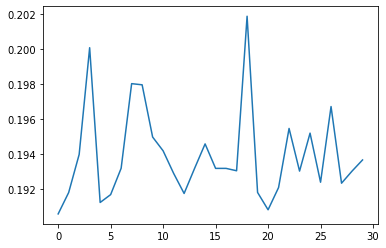

In [157]:
plt.plot(result)

In [170]:
result[18]

0.2018722992156634

In [167]:
params = {'bagging_fraction': 0.9701283751499694,
 'feature_fraction': 0.8084356493839246,
 'lambda_l2': 0.26336088311927874,
 'learning_rate': 0.18325131757446364}

In [168]:
capacity = 1000
dangjin_floating_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10_lgb, verbose_eval=500, early_stopping_rounds=100)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 117.098189
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[125]	valid_0's score: 4.88869


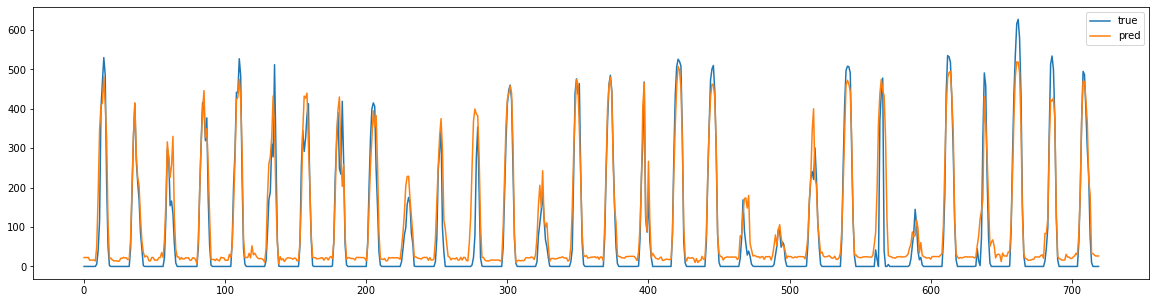

CV Score :  4.888693997255007


In [169]:
# all

pred = dangjin_floating_model.predict(val_x)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='true')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, pred))

#### - 당진자재창고태양광

In [114]:
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_obs, target='dangjin_warehouse', 
                                              sun_target = "sun_dangjin")

train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)

In [115]:
def nmae_10(y_true, y_pred):
    
    y_true = y_true * (train_max - train_min) + train_min
    y_pred = y_pred * (train_max - train_min) + train_min
    
    absolute_error = abs(y_true - y_pred)
    absolute_error = absolute_error / capacity
    
    target_idx = np.where(y_true >= capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx]
    
    return nmae

In [116]:
from sklearn.metrics import r2_score, mean_squared_error

def LGB_cv(learning_rate, 
           feature_fraction, 
           bagging_fraction,
           lambda_l2,
           silent=True, 
           nthread=-1):

    params = {"learning_rate": learning_rate,
                "feature_fraction" : feature_fraction,
                "bagging_fraction" : bagging_fraction, 
               "lambda_l2" : lambda_l2,
               "objective" :  "regression",
              "nthread" : nthread
                }
    
    model = lgb.train(params,
                      train_dataset,
                      feval = nmae_10
                     )

    y_pred = model.predict(val_x)

    mae = np.mean(nmae_10(val_y, y_pred))

    return 1/mae

In [122]:
import scipy.optimize as optimize
from bayes_opt import BayesianOptimization

params = {"learning_rate": (0.0001, 0.2),
            "feature_fraction" : (0.0001, 1),
            "bagging_fraction" : (0.0001, 1), 
           "lambda_l2" : (0 , 1)
            }

capacity = 700
train_max = 1
train_min = 0

bo=BayesianOptimization(f=LGB_cv, 
                            pbounds=params, 
                            verbose=2, 
                            random_state=270 )

bo.maximize(init_points=2, n_iter=200, acq='ei', xi=0.01)


print(bo.max)

|   iter    |  target   | baggin... | featur... | lambda_l2 | learni... |
-------------------------------------------------------------------------
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 92.674681
|  1        |  0.1484   |  0.6942   |  0.8084   |  0.04816  |  0.1807   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info

And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 92.674681
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 92.674681
|  17       |  0.144    |  0.0001   |  1.0      |  0.0      |  0.2      |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 92.674681
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 92.674681
|  27       |  0.1426   |  0.0001   |  1.0      |  0.2798   |  0.2      |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 92.674681
|  28       |  0.1479   |  0.6179   |  1.0      |  0.7898   |  0.2      |
[LightGBM] [Warning] Auto-choosing r

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 92.674681
|  43       |  0.109    |  0.524    |  0.6346   |  0.8669   |  0.02563  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 92.674681
|  44       |  0.1401   |  0.5081   |  0.8555   |  0.5968   |  0.1884   |
[LightGBM] [Warning] Auto-choosing r

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 92.674681
|  56       |  0.1277   |  1.0      |  0.4979   |  0.4814   |  0.2      |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 92.674681
|  57       |  0.1415   |  1.0      |  0.7307   |  1.0      |  0.2      |
[LightGBM] [Warning] Auto-choosing r

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 92.674681
|  66       |  0.147    |  0.5215   |  0.8408   |  0.08529  |  0.2      |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 92.674681
|  67       |  0.1414   |  0.5406   |  0.9934   |  0.6739   |  0.07439  |
[LightGBM] [Warning] Auto-choosing r

|  81       |  0.1402   |  0.6864   |  0.7625   |  0.1004   |  0.1844   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000176 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 92.674681
|  82       |  0.1458   |  0.1443   |  0.8519   |  0.2484   |  0.1955   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 92.674681
|  83       |  0.1474   |  0.0001   

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 92.674681
|  98       |  0.1353   |  0.3527   |  0.995    |  0.4741   |  0.187    |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 92.674681
|  99       |  0.1429   |  0.08022  |  0.8781   |  0.5485   |  0.2      |
[LightGBM] [Warning] Auto-choosing r

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 92.674681
|  106      |  0.1375   |  0.8372   |  0.6935   |  0.9182   |  0.1938   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 92.674681
|  107      |  0.1363   |  0.2835   |  0.5971   |  0.759    |  0.1633   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000131 se

[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 92.674681
|  122      |  0.1197   |  0.07529  |  0.2995   |  0.7525   |  0.07112  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 92.674681
|  123      |  0.1435   |  0.4222   |  0.736    |  0.04505  |  0.2      |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[Li

And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 92.674681
|  133      |  0.1408   |  0.6284   |  0.836    |  0.6517   |  0.0768   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 92.674681
|  134      |  0.1352   |  0.2703   |  0.5731   |  0.2916   |  0.2      |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 92.674681
|  142      |  0.1405   |  0.3327   |  0.7827   |  0.03844  |  0.1956   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 92.674681
|  143      |  0.1403   |  0.01765  |  0.9083   |  0.1453   |  0.1897   |
[LightGBM] [Warning] Auto-choosing r

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 92.674681
|  151      |  0.1313   |  0.0001   |  0.6908   |  0.7166   |  0.2      |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 92.674681
|  152      |  0.04546  |  1.0      |  0.6348   |  1.0      |  0.0001   |
[LightGBM] [Warning] Auto-choosing r

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 92.674681
|  164      |  0.1482   |  0.894    |  0.9417   |  1.0      |  0.1431   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 92.674681
|  165      |  0.1427   |  0.5247   |  1.0      |  0.3719   |  0.06973  |
[LightGBM] [Warning] Auto-choosing r

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 92.674681
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
|  175      |  0.07635  |  0.715    |  0.2051   |  0.006751 |  0.04

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 92.674681
|  190      |  0.1422   |  0.18     |  0.7493   |  0.1441   |  0.1992   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 92.674681
|  191      |  0.156    |  0.5033   |  0.8723   |  0.4325   |  0.1218   |
[LightGBM] [Warning] Auto-choosing r

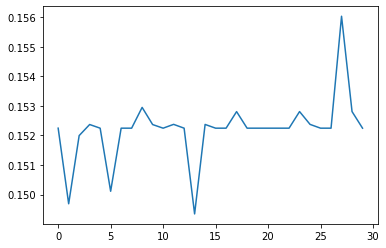

In [118]:
plt.plot(result)

In [121]:
result[27]

0.15603148110635512

In [123]:
params = {"learning_rate": 0.12181485314772855,
            "feature_fraction" : 0.8723163205581398,
            "bagging_fraction" : 0.5032665202644909, 
           "lambda_l2" :  0.4325169667604404,
          "objective" : 'regression'
            }

In [124]:
capacity = 700
dangjin_warehouse_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10_lgb, verbose_eval=500, early_stopping_rounds=100)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 92.674681
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[54]	valid_0's l2: 1395.67	valid_0's score: 6.83632


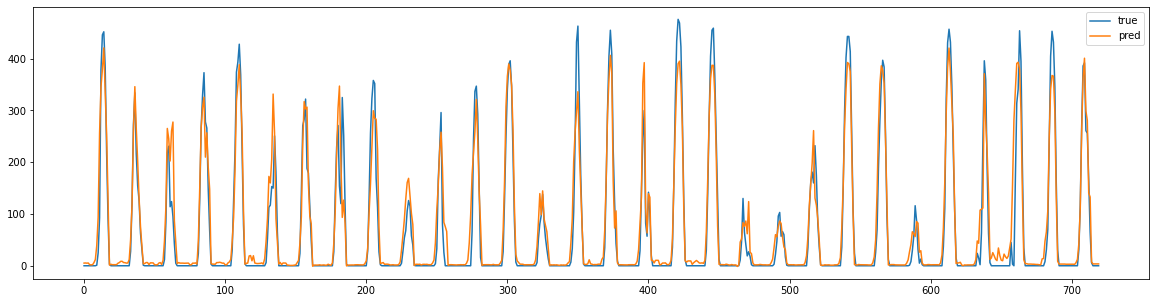

CV Score :  6.8363210649299315


In [125]:
# all

pred = dangjin_warehouse_model.predict(val_x)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='true')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, pred))

#### - 당진태양광

In [126]:
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_obs, target='dangjin', 
                                              sun_target = "sun_dangjin")

train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)

In [127]:
def nmae_10(y_true, y_pred):
    
    y_true = y_true * (train_max - train_min) + train_min
    y_pred = y_pred * (train_max - train_min) + train_min
    
    absolute_error = abs(y_true - y_pred)
    absolute_error = absolute_error / capacity
    
    target_idx = np.where(y_true >= capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx]
    
    return nmae

In [128]:
from sklearn.metrics import r2_score, mean_squared_error

def LGB_cv(learning_rate, 
           feature_fraction, 
           bagging_fraction,
           lambda_l2,
           silent=True, 
           nthread=-1):

    params = {"learning_rate": learning_rate,
                "feature_fraction" : feature_fraction,
                "bagging_fraction" : bagging_fraction, 
               "lambda_l2" : lambda_l2,
               "objective" :  "regression",
              "nthread" : nthread
                }
    
    model = lgb.train(params,
                      train_dataset,
                      feval = nmae_10
                     )

    y_pred = model.predict(val_x)

    mae = np.mean(nmae_10(val_y, y_pred))

    return 1/mae

In [135]:
import scipy.optimize as optimize
from bayes_opt import BayesianOptimization

params = {"learning_rate": (0.0001, 0.2),
            "feature_fraction" : (0.0001, 1),
            "bagging_fraction" : (0.0001, 1), 
           "lambda_l2" : (0 , 1)
            }

capacity = 1000
train_max = 1
train_min = 0

bo=BayesianOptimization(f=LGB_cv, 
                        pbounds=params, 
                        verbose=2, 
                        random_state=80)

bo.maximize(init_points=2, n_iter=200, acq='ei', xi=0.01)

print(bo.max)

|   iter    |  target   | baggin... | featur... | lambda_l2 | learni... |
-------------------------------------------------------------------------
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 138.644267
|  1        |  0.1281   |  0.522    |  0.6994   |  0.2699   |  0.1349   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Inf

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 138.644267
|  14       |  0.1295   |  0.773    |  0.9279   |  0.3456   |  0.2      |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 138.644267
|  15       |  0.03862  |  1.0      |  0.9905   |  0.488    |  0.0001   |
[LightGBM] [Warning] Auto-choosing

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 138.644267
|  29       |  0.1232   |  0.5255   |  0.8719   |  0.3276   |  0.128    |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 138.644267
|  30       |  0.1289   |  0.2929   |  0.9552   |  0.3224   |  0.1887   |
[LightGBM] [Warning] Auto-choosing

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 138.644267
|  38       |  0.1287   |  0.6811   |  0.7232   |  0.3246   |  0.1571   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 138.644267
|  39       |  0.1254   |  0.6205   |  0.7649   |  0.2187   |  0.2      |
[LightGBM] [Warning] Auto-choosing

And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 138.644267
|  46       |  0.126    |  0.8189   |  0.5726   |  0.4153   |  0.1101   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 138.644267
|  47       |  0.1117   |  0.154    |  0.5408   |  0.2784   |  0.04505  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you c

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 138.644267
|  66       |  0.1279   |  0.0001   |  0.8645   |  0.431    |  0.2      |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 138.644267
|  67       |  0.126    |  0.7417   |  0.3836   |  0.9512   |  0.1922   |
[LightGBM] [Warning] Auto-choosing

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 138.644267
|  82       |  0.1293   |  0.5384   |  0.7992   |  0.6638   |  0.1007   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 138.644267
|  83       |  0.1343   |  0.5256   |  0.8257   |  0.7837   |  0.2      |
[LightGBM] [Warning] Auto-choosing

And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 138.644267
|  97       |  0.121    |  0.9607   |  0.2828   |  0.1522   |  0.1374   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 138.644267
|  98       |  0.1344   |  0.4681   |  0.7481   |  0.87     |  0.2      |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you c

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 138.644267
|  113      |  0.1297   |  0.5158   |  0.7867   |  0.9031   |  0.1809   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 138.644267
|  114      |  0.1249   |  0.8979   |  0.5203   |  0.7886   |  0.0779   |
[LightGBM] [Warning] Auto-choosing

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 138.644267
|  121      |  0.1292   |  0.04676  |  0.5517   |  0.1024   |  0.1515   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 138.644267
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 138.644267
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 138.644267
|  144      |  0.1266   |  0.4208   |  0.7613   |  0.9036   |  0.1424   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 138.644267
|  145      |  0.1248   |  0.4472   |  0.8706   |  0.782    |  0.2      |
[LightGBM] [Warning] Auto-choosing

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 138.644267
|  159      |  0.128    |  0.5599   |  0.9129   |  0.6739   |  0.1706   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 138.644267
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 138.644267
|  167      |  0.111    |  0.7065   |  0.6264   |  0.4133   |  0.03776  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 138.644267
|  168      |  0.1317   |  0.7806   |  0.6942   |  0.9014   |  0.166    |
[LightGBM] [Warning] Auto-choosing

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 138.644267
|  178      |  0.1297   |  0.849    |  0.7967   |  0.8445   |  0.1148   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 138.644267
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 138.644267
|  192      |  0.1261   |  0.9962   |  0.8358   |  0.4507   |  0.1283   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 138.644267
|  193      |  0.1322   |  0.08898  |  0.5388   |  0.1669   |  0.1994   |
[LightGBM] [Warning] Auto-choosing

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 138.644267
|  200      |  0.131    |  0.2839   |  0.5273   |  0.2113   |  0.1979   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 138.644267
|  201      |  0.1251   |  0.4546   |  0.6433   |  0.7553   |  0.1861   |
[LightGBM] [Warning] Auto-choosing

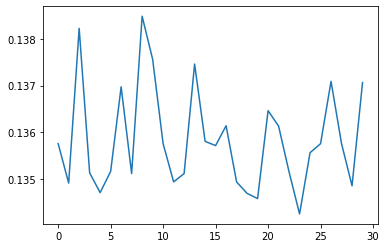

In [131]:
plt.plot(result[30:])

In [136]:
params = {"learning_rate": 0.1923852676688397,
            "feature_fraction" : 0.5444581885363117,
            "bagging_fraction" : 0.06673015278311024, 
           "lambda_l2" : 0.09325832898715902,
          "objective" : 'regression'
            }

In [137]:
capacity = 1000
dangjin_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10_lgb, verbose_eval=500, early_stopping_rounds=100)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 138.644267
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[33]	valid_0's l2: 3046.36	valid_0's score: 8.04361


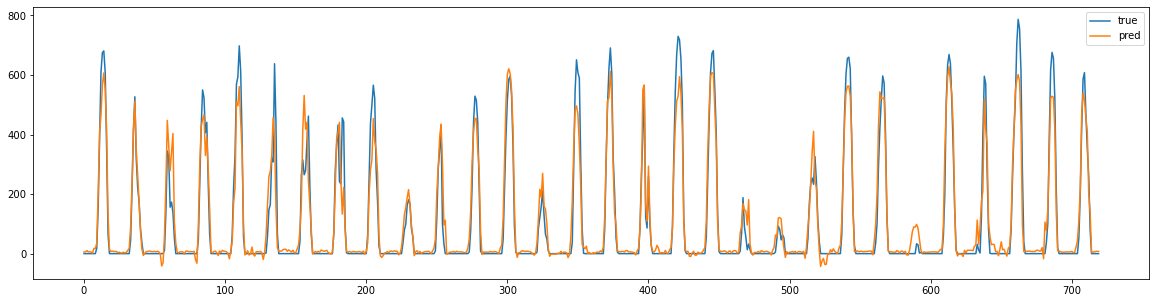

CV Score :  8.043609777112499


In [138]:
pred = dangjin_model.predict(val_x)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='true')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, pred))

#### - 울산태양광

In [139]:
train_x, train_y, val_x, val_y = train_datast(energy, ulsan_obs, 
                                              target='ulsan', 
                                              sun_target = "sun_ulsan")
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)

In [140]:
def nmae_10(y_true, y_pred):
    
    y_true = y_true * (train_max - train_min) + train_min
    y_pred = y_pred * (train_max - train_min) + train_min
    
    absolute_error = abs(y_true - y_pred)
    absolute_error = absolute_error / capacity
    
    target_idx = np.where(y_true >= capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx]
    
    return nmae

In [141]:
from sklearn.metrics import r2_score, mean_squared_error

def LGB_cv(learning_rate, 
           feature_fraction, 
           bagging_fraction,
           lambda_l2,
           silent=True, 
           nthread=-1):

    params = {"learning_rate": learning_rate,
                "feature_fraction" : feature_fraction,
                "bagging_fraction" : bagging_fraction, 
               "lambda_l2" : lambda_l2,
               "objective" :  "regression",
              "nthread" : nthread
                }
    
    model = lgb.train(params,
                      train_dataset,
                      feval = nmae_10
                     )

    y_pred = model.predict(val_x)

    mae = np.mean(nmae_10(val_y, y_pred))

    return 1/mae

In [146]:
import scipy.optimize as optimize
from bayes_opt import BayesianOptimization

params = {"learning_rate": (0.0001, 0.2),
            "feature_fraction" : (0.0001, 1),
            "bagging_fraction" : (0.0001, 1), 
           "lambda_l2" : (0 , 1)
            }

capacity = 500
train_max = 1
train_min = 0

bo=BayesianOptimization(f=LGB_cv, 
                        pbounds=params, 
                        verbose=2, 
                        random_state=40 )

bo.maximize(init_points=2, n_iter=200, acq='ei', xi=0.01)

print(bo.max)

|   iter    |  target   | baggin... | featur... | lambda_l2 | learni... |
-------------------------------------------------------------------------
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 520
[LightGBM] [Info] Number of data points in the train set: 24018, number of used features: 9
[LightGBM] [Info] Start training from score 66.382796
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
|  7        |  0.0739   |  0.5884   |  0.2601   |  0.6401   |  0.05594  |
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 520
[LightGBM] [Info] Number of data points in the train set: 24018, number of used features: 9
[LightGBM] [Info] Start training from score 66.382796
|  8        |  0.1756   |  0.4867   |  0.7075   |  0.4923   |  0.03386  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000142 seconds.
You can set `force_row_wis

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 520
[LightGBM] [Info] Number of data points in the train set: 24018, number of used features: 9
[LightGBM] [Info] Start training from score 66.382796
|  23       |  0.2184   |  0.5933   |  1.0      |  0.0      |  0.2      |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 520
[LightGBM] [Info] Number of data points in the train set: 24018, number of used features: 9
[LightGBM] [Info] Start training from score 66.382796
|  24       |  0.2155   |  0.5209   |  0.7877   |  0.792    |  0.05622  |
[LightGBM] [Warning] Auto-choosing r

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 520
[LightGBM] [Info] Number of data points in the train set: 24018, number of used features: 9
[LightGBM] [Info] Start training from score 66.382796
|  33       |  0.2359   |  0.4878   |  0.9401   |  0.6082   |  0.2      |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 520
[LightGBM] [Info] Number of data points in the train set: 24018, number of used features: 9
[LightGBM] [Info] Start training from score 66.382796
|  34       |  0.2393   |  0.9024   |  0.93     |  0.5093   |  0.2      |
[LightGBM] [Warning] Auto-choosing r

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 520
[LightGBM] [Info] Number of data points in the train set: 24018, number of used features: 9
[LightGBM] [Info] Start training from score 66.382796
|  50       |  0.2205   |  0.4948   |  0.966    |  0.8618   |  0.06125  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 520
[LightGBM] [Info] Number of data points in the train set: 24018, number of used features: 9
[LightGBM] [Info] Start training from score 66.382796
|  51       |  0.2248   |  0.7724   |  0.6309   |  0.9377   |  0.1966   |
[LightGBM] [Warning] Auto-choosing r

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 520
[LightGBM] [Info] Number of data points in the train set: 24018, number of used features: 9
[LightGBM] [Info] Start training from score 66.382796
|  66       |  0.2155   |  0.4969   |  1.0      |  0.7745   |  0.2      |
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 520
[LightGBM] [Info] Number of data points in the train set: 24018, number of used features: 9
[LightGBM] [Info] Start training from score 66.382796
|  67       |  0.2347   |  0.4571   |  0.8592   |  0.436    |  0.1988   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000123 se

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 520
[LightGBM] [Info] Number of data points in the train set: 24018, number of used features: 9
[LightGBM] [Info] Start training from score 66.382796
|  74       |  0.2289   |  0.8364   |  0.511    |  0.5621   |  0.1655   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 520
[LightGBM] [Info] Number of data points in the train set: 24018, number of used features: 9
[LightGBM] [Info] Start training from score 66.382796
|  75       |  0.2115   |  0.7338   |  0.619    |  0.6049   |  0.2      |
[LightGBM] [Warning] Auto-choosing r

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 520
[LightGBM] [Info] Number of data points in the train set: 24018, number of used features: 9
[LightGBM] [Info] Start training from score 66.382796
|  91       |  0.2268   |  0.0001   |  1.0      |  0.5325   |  0.2      |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 520
[LightGBM] [Info] Number of data points in the train set: 24018, number of used features: 9
[LightGBM] [Info] Start training from score 66.382796
|  92       |  0.2239   |  0.2261   |  0.6222   |  0.7652   |  0.2      |
[LightGBM] [Warning] Auto-choosing r

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 520
[LightGBM] [Info] Number of data points in the train set: 24018, number of used features: 9
[LightGBM] [Info] Start training from score 66.382796
|  99       |  0.2128   |  0.7712   |  0.5496   |  0.3482   |  0.2      |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 520
[LightGBM] [Info] Number of data points in the train set: 24018, number of used features: 9
[LightGBM] [Info] Start training from score 66.382796
|  100      |  0.0378   |  0.189    |  0.5098   |  0.0      |  0.0001   |
[LightGBM] [Warning] Auto-choosing r

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 520
[LightGBM] [Info] Number of data points in the train set: 24018, number of used features: 9
[LightGBM] [Info] Start training from score 66.382796
|  108      |  0.2285   |  0.364    |  1.0      |  0.4152   |  0.2      |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 520
[LightGBM] [Info] Number of data points in the train set: 24018, number of used features: 9
[LightGBM] [Info] Start training from score 66.382796
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

|  114      |  0.1398   |  0.4988   |  0.3996   |  0.3      |  0.08133  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 520
[LightGBM] [Info] Number of data points in the train set: 24018, number of used features: 9
[LightGBM] [Info] Start training from score 66.382796
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 520
[LightGBM] [Info] Number of data points in the train set: 24018, number of used features: 9
[LightGBM] [Info] Start training from score 66.382796
|  123      |  0.2142   |  0.1693   |  0.5362   |  0.924    |  0.1092   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 520
[LightGBM] [Info] Number of data points in the train set: 24018, number of used features: 9
[LightGBM] [Info] Start training from score 66.382796
|  124      |  0.2393   |  0.1012   |  0.9178   |  0.3767   |  0.1961   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 520
[LightGBM] [Info] Number of data points in the train set: 24018, number of used features: 9
[LightGBM] [Info] Start training from score 66.382796
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 520
[LightGBM] [Info] Number of data points in the train set: 24018, number of used features: 9
[LightGBM] [Info] Start training from score 66.382796
|  143      |  0.2073   |  0.6843   |  0.6611   |  0.8095   |  0.2      |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 520
[LightGBM] [Info] Number of data points in the train set: 24018, number of used features: 9
[LightGBM] [Info] Start training from score 66.382796
|  144      |  0.2293   |  0.4642   |  0.9258   |  0.7674   |  0.07847  |
[LightGBM] [Warning] Auto-choosing r

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 520
[LightGBM] [Info] Number of data points in the train set: 24018, number of used features: 9
[LightGBM] [Info] Start training from score 66.382796
|  156      |  0.2172   |  0.1252   |  0.8258   |  0.1185   |  0.194    |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 520
[LightGBM] [Info] Number of data points in the train set: 24018, number of used features: 9
[LightGBM] [Info] Start training from score 66.382796
|  157      |  0.2308   |  0.994    |  0.8484   |  0.2947   |  0.1969   |
[LightGBM] [Warning] Auto-choosing r

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 520
[LightGBM] [Info] Number of data points in the train set: 24018, number of used features: 9
[LightGBM] [Info] Start training from score 66.382796
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
|  171      |  0.1338   |  0.9918   |  0.3839   |  0.708    |  0.04369  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 520
[LightGBM] [Info] Number of data points in the train set: 24018, number of used features: 9
[LightGBM] [Info] Start training from score 66.382796
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 520
[LightGBM] [Info] Number of data points in the train set: 24018, number of used features: 9
[LightGBM] [Info] Start training from score 66.382796
|  178      |  0.2375   |  0.7195   |  1.0      |  0.4229   |  0.1106   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 520
[LightGBM] [Info] Number of data points in the train set: 24018, number of used features: 9
[LightGBM] [Info] Start training from score 66.382796
|  179      |  0.2315   |  0.6166   |  0.9289   |  0.06803  |  0.1199   |
[LightGBM] [Warning] Auto-choosing r

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 520
[LightGBM] [Info] Number of data points in the train set: 24018, number of used features: 9
[LightGBM] [Info] Start training from score 66.382796
|  194      |  0.1918   |  0.9335   |  0.3802   |  0.1046   |  0.1353   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 520
[LightGBM] [Info] Number of data points in the train set: 24018, number of used features: 9
[LightGBM] [Info] Start training from score 66.382796
|  195      |  0.2243   |  0.6492   |  0.8275   |  0.01083  |  0.09007  |
[LightGBM] [Warning] Auto-choosing r

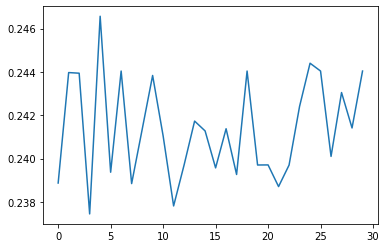

In [144]:
plt.plot(result)

In [145]:
result[4]

0.2465660827798101

In [147]:
params = {"learning_rate": 0.1858985673397385,
            "feature_fraction" : 0.9003475737529653,
            "bagging_fraction" : 0.7086038083826985,
           "lambda_l2" : 0.49634130755970496,
          "objective" : 'regression'
            }

In [148]:
capacity = 500
ulsan_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10_lgb, verbose_eval=500, early_stopping_rounds=100)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 520
[LightGBM] [Info] Number of data points in the train set: 24018, number of used features: 9
[LightGBM] [Info] Start training from score 66.382796
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[89]	valid_0's l2: 272.109	valid_0's score: 4.00036


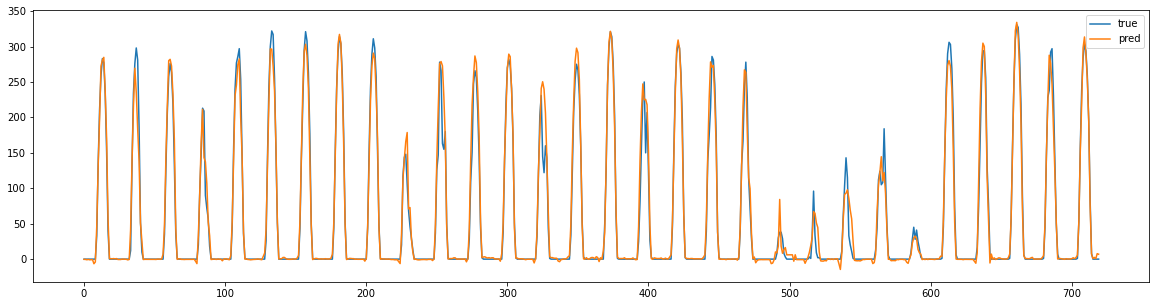

CV Score :  4.000357067637332


In [149]:
#ALL

pred = ulsan_model.predict(val_x)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='true')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, pred))

### (2) 모델 학습

#### - 당진 수상태양광

In [27]:
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_obs, target='dangjin_floating', 
                                              sun_target = "sun_dangjin")

train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)

In [28]:
def nmae_10(y_true, y_pred):
    
    y_true = y_true * (train_max - train_min) + train_min
    y_pred = y_pred * (train_max - train_min) + train_min
    
    absolute_error = abs(y_true - y_pred)
    absolute_error = absolute_error / capacity
    
    target_idx = np.where(y_true >= capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx]
    
    return nmae

In [29]:
params = {'bagging_fraction': 0.9701283751499694,
 'feature_fraction': 0.8084356493839246,
 'lambda_l2': 0.26336088311927874,
 'learning_rate': 0.18325131757446364}

In [30]:
capacity = 1000
dangjin_floating_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10_lgb, verbose_eval=500, early_stopping_rounds=100)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 117.098189
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[125]	valid_0's score: 4.88869


#### - 당진자재창고태양광

In [31]:
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_obs, target='dangjin_warehouse', 
                                              sun_target = "sun_dangjin")

train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)

In [32]:
params = {"learning_rate": 0.12181485314772855,
            "feature_fraction" : 0.8723163205581398,
            "bagging_fraction" : 0.5032665202644909, 
           "lambda_l2" :  0.4325169667604404,
          "objective" : 'regression'
            }

In [33]:
capacity = 700
dangjin_warehouse_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10_lgb, verbose_eval=500, early_stopping_rounds=100)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 92.674681
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[54]	valid_0's l2: 1395.67	valid_0's score: 6.83632


#### - 당진태양광

In [34]:
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_obs, target='dangjin', 
                                              sun_target = "sun_dangjin")

train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)

In [35]:
params = {"learning_rate": 0.1923852676688397,
            "feature_fraction" : 0.5444581885363117,
            "bagging_fraction" : 0.06673015278311024, 
           "lambda_l2" : 0.09325832898715902,
          "objective" : 'regression'
            }

In [36]:
capacity = 1000
dangjin_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10_lgb, verbose_eval=500, early_stopping_rounds=100)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 20878, number of used features: 9
[LightGBM] [Info] Start training from score 138.644267
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[33]	valid_0's l2: 3046.36	valid_0's score: 8.04361


#### - 울산태양광

In [37]:
train_x, train_y, val_x, val_y = train_datast(energy, ulsan_obs, 
                                              target='ulsan', 
                                              sun_target = "sun_ulsan")
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)

In [38]:
params = {"learning_rate": 0.1858985673397385,
            "feature_fraction" : 0.9003475737529653,
            "bagging_fraction" : 0.7086038083826985,
           "lambda_l2" : 0.49634130755970496,
          "objective" : 'regression'
            }

In [39]:
capacity = 500
ulsan_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10_lgb, verbose_eval=500, early_stopping_rounds=100)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 520
[LightGBM] [Info] Number of data points in the train set: 24018, number of used features: 9
[LightGBM] [Info] Start training from score 66.382796
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[89]	valid_0's l2: 272.109	valid_0's score: 4.00036


## 3) NN

### (1) 모델 구축

In [236]:
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_fcst, target='dangjin', 
                                              sun_target = "sun_dangjin")

In [237]:
train_x[:,0] = np.array(pd.Series(train_x[:,0]).astype("str").apply(lambda x : x[2:4]).astype("int"))

val_x[:,0] = np.array(pd.Series(val_x[:,0]).astype("str").apply(lambda x : x[2:4]).astype("int"))

In [238]:
train_min_dangjin = np.min(train_x)
train_max_dangjin = np.max(train_x)

train_x_scaled = (train_x - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)

train_y_scaled = (train_y - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)

val_x_scaled = (val_x - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)

val_y_scaled = (val_y - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)

In [295]:
train_x_scaled[:,-1] = train_x[:,-1]
val_x_scaled[:,-1] = val_x[:,-1]

In [296]:
class auto_encoder(tf.keras.Model):
    def __init__(self, 
                 dense_dim):        
        super(auto_encoder, self).__init__()
        self.dense_dim = dense_dim
     
    def build(self, input_shape):
    
        self.input_dense = tf.keras.layers.Dense(self.dense_dim, 
                                      activation = "relu")
        self.dense_input_1 = tf.keras.layers.Dense(int(self.dense_dim),
                                                  activation = "relu")
        self.dense_input_2 = tf.keras.layers.Dense(int(self.dense_dim),
                                                  activation = "relu")
        self.dense_embedding = tf.keras.layers.Dense(int(self.dense_dim),
                                                    activation = "relu")
        self.dense_output_1 = tf.keras.layers.Dense(int(self.dense_dim),
                                                  activation = "relu")
        self.dense_output_2 = tf.keras.layers.Dense(int(self.dense_dim),
                                          activation = "relu")
        self.output_dense = tf.keras.layers.Dense(self.dense_dim,
                                                 activation = "relu")
        self.ae_output = tf.keras.layers.Dense(1,
                                      activation = "relu")
        self.dropout = tf.keras.layers.Dropout(0.2)
        
        self.layernorm = tf.keras.layers.LayerNormalization()
    
    def call(self, input_tensor):       
        input_output = self.input_dense(input_tensor)        
        output = self.dense_input_1(input_output)
        output = self.dense_input_2(output)
        output = self.dense_embedding(output)
        output = self.dropout(output)
        output = self.dense_output_1(output)        
        output = self.dense_output_2(output)        
        output = self.output_dense(output)
        output = self.dropout(output)
        
        
        output = self.ae_output(output)        
        return output

In [297]:
Auto_Encoder = auto_encoder(300)

In [298]:
def nmae_10(y_true, y_pred):
    
    y_true = y_true * (train_max - train_min) + train_min
    y_pred = y_pred * (train_max - train_min) + train_min
    
    absolute_error = abs(y_true - y_pred)
    
    return absolute_error

In [299]:
@tf.function()
def training_auto_encoder(inp , tar):
    with tf.GradientTape() as tape:
        
        global output
        
        output = Auto_Encoder(inp)

        loss =  loss_function(tar, output)
    
    gradients = tape.gradient(loss, Auto_Encoder.trainable_variables)
    optimizer.apply_gradients(zip(gradients, Auto_Encoder.trainable_variables))
  
    train_loss(loss)
    train_accuracy(tf.numpy_function(nmae_10, 
                                     [tar, output], 
                                     tf.float32))

In [300]:
def val_accuracy(inp, tar, Models):
    output = Auto_Encoder(inp)
    
    tar = tf.reshape(tar, [-1,1])
    
    test_accuracy(tf.numpy_function(nmae_10, 
                                     [tar, output], 
                                     tf.float32))

In [301]:
EPOCHS = 200
batch_size = 10

In [302]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name = "test_loss")
test_accuracy = tf.keras.metrics.Mean(name = "test_accuracy")
 
loss_function = tf.keras.losses.MeanAbsoluteError(reduction = tf.keras.losses.Reduction.NONE)
accuracy_function = tf.keras.metrics.MeanAbsoluteError()
 
optimizer = tf.keras.optimizers.Adam()

train_max = train_max_dangjin.copy()
train_min = train_min_dangjin.copy()

for epoch in range(EPOCHS):
    start = time.time()
    
    i = 1

    while True:

        inp = train_x_scaled[(i - 1) * batch_size : (i * batch_size)].copy()
        inp = tf.Variable(inp, dtype = tf.float32)
        
        tar = tf.Variable(train_y_scaled[(i - 1) * batch_size : (i * batch_size)], dtype = tf.float32)
        tar = tf.reshape(tar, [-1,1])

        i += 1

        training_auto_encoder(inp, tar)

        if i % 100 == 0:
            print(f'Epoch {epoch + 1} Batch {i} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

        if i > int(len(train_x_scaled) / batch_size) :
            print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')
            val_accuracy(val_x_scaled, val_y_scaled, Auto_Encoder)
            print(f'TestLoss {test_loss.result():.4f} TestAccuracy {test_accuracy.result():.4f}')
            break

Epoch 1 Batch 100 Loss 1.0508 Accuracy 114.5357
Epoch 1 Batch 200 Loss 1.0814 Accuracy 117.8695
Epoch 1 Batch 300 Loss 1.0977 Accuracy 119.6508
Epoch 1 Batch 400 Loss 1.0796 Accuracy 117.6802
Epoch 1 Batch 500 Loss 1.0259 Accuracy 111.8253
Epoch 1 Batch 600 Loss 1.0072 Accuracy 109.7822
Epoch 1 Batch 700 Loss 0.9665 Accuracy 105.3492
Epoch 1 Batch 800 Loss 0.9605 Accuracy 104.6930
Epoch 1 Batch 900 Loss 0.9550 Accuracy 104.1002
Epoch 1 Batch 1000 Loss 0.9602 Accuracy 104.6572
Epoch 1 Batch 1100 Loss 0.9636 Accuracy 105.0360
Epoch 1 Batch 1200 Loss 0.9580 Accuracy 104.4206
Epoch 1 Batch 1300 Loss 0.9496 Accuracy 103.5029
Epoch 1 Batch 1400 Loss 0.9385 Accuracy 102.2997
Epoch 1 Batch 1500 Loss 0.9218 Accuracy 100.4804
Epoch 1 Batch 1600 Loss 0.9003 Accuracy 98.1290
Epoch 1 Batch 1700 Loss 0.8845 Accuracy 96.4131
Epoch 1 Batch 1800 Loss 0.8756 Accuracy 95.4439
Epoch 1 Batch 1900 Loss 0.8802 Accuracy 95.9430
Epoch 1 Batch 2000 Loss 0.8844 Accuracy 96.3954
Epoch 1 Batch 2100 Loss 0.8804 Acc

Epoch 7 Batch 500 Loss 0.7589 Accuracy 82.7194
Epoch 7 Batch 600 Loss 0.7574 Accuracy 82.5616
Epoch 7 Batch 700 Loss 0.7555 Accuracy 82.3545
Epoch 7 Batch 800 Loss 0.7538 Accuracy 82.1652
Epoch 7 Batch 900 Loss 0.7524 Accuracy 82.0089
Epoch 7 Batch 1000 Loss 0.7518 Accuracy 81.9494
Epoch 7 Batch 1100 Loss 0.7508 Accuracy 81.8337
Epoch 7 Batch 1200 Loss 0.7491 Accuracy 81.6488
Epoch 7 Batch 1300 Loss 0.7478 Accuracy 81.5083
Epoch 7 Batch 1400 Loss 0.7470 Accuracy 81.4229
Epoch 7 Batch 1500 Loss 0.7448 Accuracy 81.1878
Epoch 7 Batch 1600 Loss 0.7423 Accuracy 80.9063
Epoch 7 Batch 1700 Loss 0.7400 Accuracy 80.6575
Epoch 7 Batch 1800 Loss 0.7379 Accuracy 80.4286
Epoch 7 Batch 1900 Loss 0.7364 Accuracy 80.2723
Epoch 7 Batch 2000 Loss 0.7354 Accuracy 80.1579
Epoch 7 Batch 2100 Loss 0.7344 Accuracy 80.0524
Epoch 7 Batch 2200 Loss 0.7325 Accuracy 79.8467
Epoch 7 Batch 2300 Loss 0.7312 Accuracy 79.7050
Epoch 7 Batch 2400 Loss 0.7297 Accuracy 79.5400
Time taken for 1 epoch: 3.25 secs

TestLoss 0

Epoch 13 Batch 2300 Loss 0.6128 Accuracy 66.7967
Epoch 13 Batch 2400 Loss 0.6121 Accuracy 66.7225
Time taken for 1 epoch: 3.26 secs

TestLoss 0.0000 TestAccuracy 61.9669
Epoch 14 Batch 100 Loss 0.6116 Accuracy 66.6621
Epoch 14 Batch 200 Loss 0.6111 Accuracy 66.6104
Epoch 14 Batch 300 Loss 0.6111 Accuracy 66.6087
Epoch 14 Batch 400 Loss 0.6106 Accuracy 66.5582
Epoch 14 Batch 500 Loss 0.6103 Accuracy 66.5214
Epoch 14 Batch 600 Loss 0.6098 Accuracy 66.4720
Epoch 14 Batch 700 Loss 0.6092 Accuracy 66.4080
Epoch 14 Batch 800 Loss 0.6085 Accuracy 66.3291
Epoch 14 Batch 900 Loss 0.6081 Accuracy 66.2857
Epoch 14 Batch 1000 Loss 0.6081 Accuracy 66.2841
Epoch 14 Batch 1100 Loss 0.6079 Accuracy 66.2598
Epoch 14 Batch 1200 Loss 0.6075 Accuracy 66.2156
Epoch 14 Batch 1300 Loss 0.6070 Accuracy 66.1634
Epoch 14 Batch 1400 Loss 0.6068 Accuracy 66.1400
Epoch 14 Batch 1500 Loss 0.6060 Accuracy 66.0548
Epoch 14 Batch 1600 Loss 0.6051 Accuracy 65.9528
Epoch 14 Batch 1700 Loss 0.6043 Accuracy 65.8671
Epoch 

Epoch 20 Batch 1400 Loss 0.5576 Accuracy 60.7751
Epoch 20 Batch 1500 Loss 0.5571 Accuracy 60.7272
Epoch 20 Batch 1600 Loss 0.5566 Accuracy 60.6654
Epoch 20 Batch 1700 Loss 0.5561 Accuracy 60.6178
Epoch 20 Batch 1800 Loss 0.5557 Accuracy 60.5744
Epoch 20 Batch 1900 Loss 0.5553 Accuracy 60.5324
Epoch 20 Batch 2000 Loss 0.5552 Accuracy 60.5196
Epoch 20 Batch 2100 Loss 0.5551 Accuracy 60.5078
Epoch 20 Batch 2200 Loss 0.5547 Accuracy 60.4661
Epoch 20 Batch 2300 Loss 0.5545 Accuracy 60.4421
Epoch 20 Batch 2400 Loss 0.5541 Accuracy 60.4022
Time taken for 1 epoch: 3.27 secs

TestLoss 0.0000 TestAccuracy 55.8655
Epoch 21 Batch 100 Loss 0.5540 Accuracy 60.3836
Epoch 21 Batch 200 Loss 0.5538 Accuracy 60.3610
Epoch 21 Batch 300 Loss 0.5538 Accuracy 60.3685
Epoch 21 Batch 400 Loss 0.5536 Accuracy 60.3413
Epoch 21 Batch 500 Loss 0.5534 Accuracy 60.3259
Epoch 21 Batch 600 Loss 0.5532 Accuracy 60.3006
Epoch 21 Batch 700 Loss 0.5528 Accuracy 60.2574
Epoch 21 Batch 800 Loss 0.5524 Accuracy 60.2134
Epoch

Epoch 27 Batch 500 Loss 0.5255 Accuracy 57.2751
Epoch 27 Batch 600 Loss 0.5253 Accuracy 57.2561
Epoch 27 Batch 700 Loss 0.5250 Accuracy 57.2295
Epoch 27 Batch 800 Loss 0.5248 Accuracy 57.1987
Epoch 27 Batch 900 Loss 0.5246 Accuracy 57.1837
Epoch 27 Batch 1000 Loss 0.5247 Accuracy 57.1915
Epoch 27 Batch 1100 Loss 0.5247 Accuracy 57.1885
Epoch 27 Batch 1200 Loss 0.5246 Accuracy 57.1816
Epoch 27 Batch 1300 Loss 0.5245 Accuracy 57.1686
Epoch 27 Batch 1400 Loss 0.5244 Accuracy 57.1623
Epoch 27 Batch 1500 Loss 0.5241 Accuracy 57.1291
Epoch 27 Batch 1600 Loss 0.5237 Accuracy 57.0879
Epoch 27 Batch 1700 Loss 0.5234 Accuracy 57.0563
Epoch 27 Batch 1800 Loss 0.5231 Accuracy 57.0235
Epoch 27 Batch 1900 Loss 0.5229 Accuracy 56.9927
Epoch 27 Batch 2000 Loss 0.5228 Accuracy 56.9902
Epoch 27 Batch 2100 Loss 0.5228 Accuracy 56.9840
Epoch 27 Batch 2200 Loss 0.5226 Accuracy 56.9604
Epoch 27 Batch 2300 Loss 0.5225 Accuracy 56.9490
Epoch 27 Batch 2400 Loss 0.5222 Accuracy 56.9208
Time taken for 1 epoch: 3

Epoch 33 Batch 2100 Loss 0.5042 Accuracy 54.9535
Epoch 33 Batch 2200 Loss 0.5040 Accuracy 54.9342
Epoch 33 Batch 2300 Loss 0.5039 Accuracy 54.9240
Epoch 33 Batch 2400 Loss 0.5037 Accuracy 54.9021
Time taken for 1 epoch: 3.28 secs

TestLoss 0.0000 TestAccuracy 50.1711
Epoch 34 Batch 100 Loss 0.5037 Accuracy 54.8995
Epoch 34 Batch 200 Loss 0.5036 Accuracy 54.8899
Epoch 34 Batch 300 Loss 0.5037 Accuracy 54.8986
Epoch 34 Batch 400 Loss 0.5035 Accuracy 54.8843
Epoch 34 Batch 500 Loss 0.5035 Accuracy 54.8814
Epoch 34 Batch 600 Loss 0.5034 Accuracy 54.8685
Epoch 34 Batch 700 Loss 0.5032 Accuracy 54.8522
Epoch 34 Batch 800 Loss 0.5030 Accuracy 54.8298
Epoch 34 Batch 900 Loss 0.5029 Accuracy 54.8184
Epoch 34 Batch 1000 Loss 0.5030 Accuracy 54.8278
Epoch 34 Batch 1100 Loss 0.5030 Accuracy 54.8243
Epoch 34 Batch 1200 Loss 0.5029 Accuracy 54.8202
Epoch 34 Batch 1300 Loss 0.5029 Accuracy 54.8131
Epoch 34 Batch 1400 Loss 0.5028 Accuracy 54.8079
Epoch 34 Batch 1500 Loss 0.5026 Accuracy 54.7819
Epoch 

Epoch 40 Batch 1200 Loss 0.4889 Accuracy 53.2955
Epoch 40 Batch 1300 Loss 0.4889 Accuracy 53.2885
Epoch 40 Batch 1400 Loss 0.4888 Accuracy 53.2841
Epoch 40 Batch 1500 Loss 0.4887 Accuracy 53.2663
Epoch 40 Batch 1600 Loss 0.4884 Accuracy 53.2400
Epoch 40 Batch 1700 Loss 0.4883 Accuracy 53.2216
Epoch 40 Batch 1800 Loss 0.4881 Accuracy 53.2011
Epoch 40 Batch 1900 Loss 0.4879 Accuracy 53.1820
Epoch 40 Batch 2000 Loss 0.4879 Accuracy 53.1822
Epoch 40 Batch 2100 Loss 0.4879 Accuracy 53.1821
Epoch 40 Batch 2200 Loss 0.4878 Accuracy 53.1672
Epoch 40 Batch 2300 Loss 0.4877 Accuracy 53.1595
Epoch 40 Batch 2400 Loss 0.4875 Accuracy 53.1428
Time taken for 1 epoch: 3.25 secs

TestLoss 0.0000 TestAccuracy 48.1404
Epoch 41 Batch 100 Loss 0.4875 Accuracy 53.1377
Epoch 41 Batch 200 Loss 0.4874 Accuracy 53.1289
Epoch 41 Batch 300 Loss 0.4875 Accuracy 53.1367
Epoch 41 Batch 400 Loss 0.4874 Accuracy 53.1264
Epoch 41 Batch 500 Loss 0.4874 Accuracy 53.1272
Epoch 41 Batch 600 Loss 0.4873 Accuracy 53.1167
Epo

Epoch 47 Batch 300 Loss 0.4766 Accuracy 51.9470
Epoch 47 Batch 400 Loss 0.4765 Accuracy 51.9342
Epoch 47 Batch 500 Loss 0.4765 Accuracy 51.9371
Epoch 47 Batch 600 Loss 0.4764 Accuracy 51.9265
Epoch 47 Batch 700 Loss 0.4762 Accuracy 51.9110
Epoch 47 Batch 800 Loss 0.4761 Accuracy 51.8970
Epoch 47 Batch 900 Loss 0.4761 Accuracy 51.8914
Epoch 47 Batch 1000 Loss 0.4761 Accuracy 51.8983
Epoch 47 Batch 1100 Loss 0.4761 Accuracy 51.8981
Epoch 47 Batch 1200 Loss 0.4761 Accuracy 51.8941
Epoch 47 Batch 1300 Loss 0.4760 Accuracy 51.8892
Epoch 47 Batch 1400 Loss 0.4760 Accuracy 51.8871
Epoch 47 Batch 1500 Loss 0.4759 Accuracy 51.8703
Epoch 47 Batch 1600 Loss 0.4757 Accuracy 51.8497
Epoch 47 Batch 1700 Loss 0.4756 Accuracy 51.8359
Epoch 47 Batch 1800 Loss 0.4754 Accuracy 51.8189
Epoch 47 Batch 1900 Loss 0.4753 Accuracy 51.8032
Epoch 47 Batch 2000 Loss 0.4753 Accuracy 51.8058
Epoch 47 Batch 2100 Loss 0.4753 Accuracy 51.8061
Epoch 47 Batch 2200 Loss 0.4752 Accuracy 51.7956
Epoch 47 Batch 2300 Loss 0.

Epoch 53 Batch 1900 Loss 0.4666 Accuracy 50.8556
Epoch 53 Batch 2000 Loss 0.4666 Accuracy 50.8565
Epoch 53 Batch 2100 Loss 0.4666 Accuracy 50.8574
Epoch 53 Batch 2200 Loss 0.4665 Accuracy 50.8471
Epoch 53 Batch 2300 Loss 0.4664 Accuracy 50.8421
Epoch 53 Batch 2400 Loss 0.4663 Accuracy 50.8293
Time taken for 1 epoch: 3.28 secs

TestLoss 0.0000 TestAccuracy 46.2098
Epoch 54 Batch 100 Loss 0.4663 Accuracy 50.8260
Epoch 54 Batch 200 Loss 0.4663 Accuracy 50.8220
Epoch 54 Batch 300 Loss 0.4663 Accuracy 50.8297
Epoch 54 Batch 400 Loss 0.4662 Accuracy 50.8199
Epoch 54 Batch 500 Loss 0.4662 Accuracy 50.8214
Epoch 54 Batch 600 Loss 0.4662 Accuracy 50.8141
Epoch 54 Batch 700 Loss 0.4661 Accuracy 50.8013
Epoch 54 Batch 800 Loss 0.4660 Accuracy 50.7911
Epoch 54 Batch 900 Loss 0.4659 Accuracy 50.7872
Epoch 54 Batch 1000 Loss 0.4660 Accuracy 50.7921
Epoch 54 Batch 1100 Loss 0.4660 Accuracy 50.7932
Epoch 54 Batch 1200 Loss 0.4660 Accuracy 50.7913
Epoch 54 Batch 1300 Loss 0.4659 Accuracy 50.7884
Epoch 

Epoch 60 Batch 1000 Loss 0.4589 Accuracy 50.0208
Epoch 60 Batch 1100 Loss 0.4589 Accuracy 50.0217
Epoch 60 Batch 1200 Loss 0.4589 Accuracy 50.0204
Epoch 60 Batch 1300 Loss 0.4589 Accuracy 50.0181
Epoch 60 Batch 1400 Loss 0.4589 Accuracy 50.0160
Epoch 60 Batch 1500 Loss 0.4587 Accuracy 50.0036
Epoch 60 Batch 1600 Loss 0.4586 Accuracy 49.9884
Epoch 60 Batch 1700 Loss 0.4585 Accuracy 49.9786
Epoch 60 Batch 1800 Loss 0.4584 Accuracy 49.9656
Epoch 60 Batch 1900 Loss 0.4583 Accuracy 49.9540
Epoch 60 Batch 2000 Loss 0.4583 Accuracy 49.9567
Epoch 60 Batch 2100 Loss 0.4583 Accuracy 49.9573
Epoch 60 Batch 2200 Loss 0.4582 Accuracy 49.9491
Epoch 60 Batch 2300 Loss 0.4582 Accuracy 49.9442
Epoch 60 Batch 2400 Loss 0.4581 Accuracy 49.9338
Time taken for 1 epoch: 3.25 secs

TestLoss 0.0000 TestAccuracy 45.7852
Epoch 61 Batch 100 Loss 0.4581 Accuracy 49.9298
Epoch 61 Batch 200 Loss 0.4580 Accuracy 49.9250
Epoch 61 Batch 300 Loss 0.4581 Accuracy 49.9330
Epoch 61 Batch 400 Loss 0.4580 Accuracy 49.9253
E

Epoch 67 Batch 100 Loss 0.4519 Accuracy 49.2565
Epoch 67 Batch 200 Loss 0.4519 Accuracy 49.2523
Epoch 67 Batch 300 Loss 0.4519 Accuracy 49.2588
Epoch 67 Batch 400 Loss 0.4518 Accuracy 49.2505
Epoch 67 Batch 500 Loss 0.4518 Accuracy 49.2510
Epoch 67 Batch 600 Loss 0.4518 Accuracy 49.2443
Epoch 67 Batch 700 Loss 0.4517 Accuracy 49.2362
Epoch 67 Batch 800 Loss 0.4517 Accuracy 49.2314
Epoch 67 Batch 900 Loss 0.4516 Accuracy 49.2275
Epoch 67 Batch 1000 Loss 0.4517 Accuracy 49.2329
Epoch 67 Batch 1100 Loss 0.4517 Accuracy 49.2328
Epoch 67 Batch 1200 Loss 0.4517 Accuracy 49.2307
Epoch 67 Batch 1300 Loss 0.4516 Accuracy 49.2286
Epoch 67 Batch 1400 Loss 0.4516 Accuracy 49.2278
Epoch 67 Batch 1500 Loss 0.4515 Accuracy 49.2166
Epoch 67 Batch 1600 Loss 0.4514 Accuracy 49.2030
Epoch 67 Batch 1700 Loss 0.4513 Accuracy 49.1955
Epoch 67 Batch 1800 Loss 0.4512 Accuracy 49.1852
Epoch 67 Batch 1900 Loss 0.4511 Accuracy 49.1740
Epoch 67 Batch 2000 Loss 0.4511 Accuracy 49.1756
Epoch 67 Batch 2100 Loss 0.45

Epoch 73 Batch 1700 Loss 0.4462 Accuracy 48.6360
Epoch 73 Batch 1800 Loss 0.4461 Accuracy 48.6258
Epoch 73 Batch 1900 Loss 0.4460 Accuracy 48.6158
Epoch 73 Batch 2000 Loss 0.4460 Accuracy 48.6181
Epoch 73 Batch 2100 Loss 0.4460 Accuracy 48.6195
Epoch 73 Batch 2200 Loss 0.4460 Accuracy 48.6133
Epoch 73 Batch 2300 Loss 0.4460 Accuracy 48.6099
Epoch 73 Batch 2400 Loss 0.4459 Accuracy 48.6022
Time taken for 1 epoch: 3.29 secs

TestLoss 0.0000 TestAccuracy 45.8503
Epoch 74 Batch 100 Loss 0.4459 Accuracy 48.5987
Epoch 74 Batch 200 Loss 0.4458 Accuracy 48.5950
Epoch 74 Batch 300 Loss 0.4459 Accuracy 48.6017
Epoch 74 Batch 400 Loss 0.4458 Accuracy 48.5938
Epoch 74 Batch 500 Loss 0.4458 Accuracy 48.5955
Epoch 74 Batch 600 Loss 0.4458 Accuracy 48.5898
Epoch 74 Batch 700 Loss 0.4457 Accuracy 48.5833
Epoch 74 Batch 800 Loss 0.4457 Accuracy 48.5796
Epoch 74 Batch 900 Loss 0.4457 Accuracy 48.5765
Epoch 74 Batch 1000 Loss 0.4457 Accuracy 48.5816
Epoch 74 Batch 1100 Loss 0.4457 Accuracy 48.5817
Epoch 

Epoch 80 Batch 800 Loss 0.4411 Accuracy 48.0787
Epoch 80 Batch 900 Loss 0.4411 Accuracy 48.0749
Epoch 80 Batch 1000 Loss 0.4411 Accuracy 48.0799
Epoch 80 Batch 1100 Loss 0.4411 Accuracy 48.0806
Epoch 80 Batch 1200 Loss 0.4411 Accuracy 48.0803
Epoch 80 Batch 1300 Loss 0.4411 Accuracy 48.0789
Epoch 80 Batch 1400 Loss 0.4411 Accuracy 48.0793
Epoch 80 Batch 1500 Loss 0.4410 Accuracy 48.0711
Epoch 80 Batch 1600 Loss 0.4409 Accuracy 48.0605
Epoch 80 Batch 1700 Loss 0.4409 Accuracy 48.0547
Epoch 80 Batch 1800 Loss 0.4408 Accuracy 48.0459
Epoch 80 Batch 1900 Loss 0.4407 Accuracy 48.0377
Epoch 80 Batch 2000 Loss 0.4407 Accuracy 48.0387
Epoch 80 Batch 2100 Loss 0.4407 Accuracy 48.0404
Epoch 80 Batch 2200 Loss 0.4407 Accuracy 48.0355
Epoch 80 Batch 2300 Loss 0.4407 Accuracy 48.0324
Epoch 80 Batch 2400 Loss 0.4406 Accuracy 48.0254
Time taken for 1 epoch: 3.26 secs

TestLoss 0.0000 TestAccuracy 46.0545
Epoch 81 Batch 100 Loss 0.4406 Accuracy 48.0209
Epoch 81 Batch 200 Loss 0.4405 Accuracy 48.0186
E

Epoch 86 Batch 2400 Loss 0.4366 Accuracy 47.5858
Time taken for 1 epoch: 3.25 secs

TestLoss 0.0000 TestAccuracy 46.5809
Epoch 87 Batch 100 Loss 0.4365 Accuracy 47.5815
Epoch 87 Batch 200 Loss 0.4365 Accuracy 47.5786
Epoch 87 Batch 300 Loss 0.4366 Accuracy 47.5843
Epoch 87 Batch 400 Loss 0.4365 Accuracy 47.5785
Epoch 87 Batch 500 Loss 0.4365 Accuracy 47.5790
Epoch 87 Batch 600 Loss 0.4365 Accuracy 47.5747
Epoch 87 Batch 700 Loss 0.4364 Accuracy 47.5689
Epoch 87 Batch 800 Loss 0.4364 Accuracy 47.5662
Epoch 87 Batch 900 Loss 0.4364 Accuracy 47.5634
Epoch 87 Batch 1000 Loss 0.4364 Accuracy 47.5689
Epoch 87 Batch 1100 Loss 0.4364 Accuracy 47.5697
Epoch 87 Batch 1200 Loss 0.4364 Accuracy 47.5696
Epoch 87 Batch 1300 Loss 0.4364 Accuracy 47.5689
Epoch 87 Batch 1400 Loss 0.4364 Accuracy 47.5692
Epoch 87 Batch 1500 Loss 0.4363 Accuracy 47.5618
Epoch 87 Batch 1600 Loss 0.4363 Accuracy 47.5521
Epoch 87 Batch 1700 Loss 0.4362 Accuracy 47.5476
Epoch 87 Batch 1800 Loss 0.4361 Accuracy 47.5392
Epoch 

Epoch 93 Batch 1500 Loss 0.4328 Accuracy 47.1714
Epoch 93 Batch 1600 Loss 0.4327 Accuracy 47.1627
Epoch 93 Batch 1700 Loss 0.4326 Accuracy 47.1587
Epoch 93 Batch 1800 Loss 0.4326 Accuracy 47.1516
Epoch 93 Batch 1900 Loss 0.4325 Accuracy 47.1446
Epoch 93 Batch 2000 Loss 0.4325 Accuracy 47.1461
Epoch 93 Batch 2100 Loss 0.4325 Accuracy 47.1476
Epoch 93 Batch 2200 Loss 0.4325 Accuracy 47.1438
Epoch 93 Batch 2300 Loss 0.4325 Accuracy 47.1423
Epoch 93 Batch 2400 Loss 0.4324 Accuracy 47.1355
Time taken for 1 epoch: 3.26 secs

TestLoss 0.0000 TestAccuracy 47.2466
Epoch 94 Batch 100 Loss 0.4324 Accuracy 47.1334
Epoch 94 Batch 200 Loss 0.4324 Accuracy 47.1310
Epoch 94 Batch 300 Loss 0.4324 Accuracy 47.1362
Epoch 94 Batch 400 Loss 0.4324 Accuracy 47.1313
Epoch 94 Batch 500 Loss 0.4324 Accuracy 47.1327
Epoch 94 Batch 600 Loss 0.4324 Accuracy 47.1284
Epoch 94 Batch 700 Loss 0.4323 Accuracy 47.1231
Epoch 94 Batch 800 Loss 0.4323 Accuracy 47.1211
Epoch 94 Batch 900 Loss 0.4323 Accuracy 47.1183
Epoch 

Epoch 100 Batch 600 Loss 0.4291 Accuracy 46.7766
Epoch 100 Batch 700 Loss 0.4291 Accuracy 46.7712
Epoch 100 Batch 800 Loss 0.4291 Accuracy 46.7702
Epoch 100 Batch 900 Loss 0.4291 Accuracy 46.7679
Epoch 100 Batch 1000 Loss 0.4291 Accuracy 46.7721
Epoch 100 Batch 1100 Loss 0.4291 Accuracy 46.7727
Epoch 100 Batch 1200 Loss 0.4291 Accuracy 46.7715
Epoch 100 Batch 1300 Loss 0.4291 Accuracy 46.7706
Epoch 100 Batch 1400 Loss 0.4291 Accuracy 46.7701
Epoch 100 Batch 1500 Loss 0.4290 Accuracy 46.7636
Epoch 100 Batch 1600 Loss 0.4289 Accuracy 46.7553
Epoch 100 Batch 1700 Loss 0.4289 Accuracy 46.7524
Epoch 100 Batch 1800 Loss 0.4289 Accuracy 46.7455
Epoch 100 Batch 1900 Loss 0.4288 Accuracy 46.7389
Epoch 100 Batch 2000 Loss 0.4288 Accuracy 46.7402
Epoch 100 Batch 2100 Loss 0.4288 Accuracy 46.7411
Epoch 100 Batch 2200 Loss 0.4288 Accuracy 46.7377
Epoch 100 Batch 2300 Loss 0.4288 Accuracy 46.7358
Epoch 100 Batch 2400 Loss 0.4287 Accuracy 46.7298
Time taken for 1 epoch: 3.26 secs

TestLoss 0.0000 Tes

Epoch 106 Batch 2000 Loss 0.4259 Accuracy 46.4275
Epoch 106 Batch 2100 Loss 0.4259 Accuracy 46.4285
Epoch 106 Batch 2200 Loss 0.4259 Accuracy 46.4255
Epoch 106 Batch 2300 Loss 0.4259 Accuracy 46.4234
Epoch 106 Batch 2400 Loss 0.4259 Accuracy 46.4178
Time taken for 1 epoch: 3.28 secs

TestLoss 0.0000 TestAccuracy 48.6670
Epoch 107 Batch 100 Loss 0.4258 Accuracy 46.4150
Epoch 107 Batch 200 Loss 0.4258 Accuracy 46.4128
Epoch 107 Batch 300 Loss 0.4259 Accuracy 46.4180
Epoch 107 Batch 400 Loss 0.4258 Accuracy 46.4135
Epoch 107 Batch 500 Loss 0.4258 Accuracy 46.4141
Epoch 107 Batch 600 Loss 0.4258 Accuracy 46.4112
Epoch 107 Batch 700 Loss 0.4257 Accuracy 46.4060
Epoch 107 Batch 800 Loss 0.4257 Accuracy 46.4033
Epoch 107 Batch 900 Loss 0.4257 Accuracy 46.4006
Epoch 107 Batch 1000 Loss 0.4257 Accuracy 46.4049
Epoch 107 Batch 1100 Loss 0.4257 Accuracy 46.4051
Epoch 107 Batch 1200 Loss 0.4257 Accuracy 46.4045
Epoch 107 Batch 1300 Loss 0.4257 Accuracy 46.4039
Epoch 107 Batch 1400 Loss 0.4257 Accu

Epoch 113 Batch 700 Loss 0.4233 Accuracy 46.1345
Epoch 113 Batch 800 Loss 0.4232 Accuracy 46.1321
Epoch 113 Batch 900 Loss 0.4232 Accuracy 46.1302
Epoch 113 Batch 1000 Loss 0.4233 Accuracy 46.1347
Epoch 113 Batch 1100 Loss 0.4233 Accuracy 46.1360
Epoch 113 Batch 1200 Loss 0.4233 Accuracy 46.1353
Epoch 113 Batch 1300 Loss 0.4233 Accuracy 46.1351
Epoch 113 Batch 1400 Loss 0.4233 Accuracy 46.1360
Epoch 113 Batch 1500 Loss 0.4232 Accuracy 46.1301
Epoch 113 Batch 1600 Loss 0.4232 Accuracy 46.1233
Epoch 113 Batch 1700 Loss 0.4231 Accuracy 46.1204
Epoch 113 Batch 1800 Loss 0.4231 Accuracy 46.1146
Epoch 113 Batch 1900 Loss 0.4230 Accuracy 46.1085
Epoch 113 Batch 2000 Loss 0.4230 Accuracy 46.1094
Epoch 113 Batch 2100 Loss 0.4230 Accuracy 46.1101
Epoch 113 Batch 2200 Loss 0.4230 Accuracy 46.1073
Epoch 113 Batch 2300 Loss 0.4230 Accuracy 46.1054
Epoch 113 Batch 2400 Loss 0.4229 Accuracy 46.1002
Time taken for 1 epoch: 3.27 secs

TestLoss 0.0000 TestAccuracy 49.4612
Epoch 114 Batch 100 Loss 0.4229

Epoch 119 Batch 2100 Loss 0.4206 Accuracy 45.8474
Epoch 119 Batch 2200 Loss 0.4206 Accuracy 45.8450
Epoch 119 Batch 2300 Loss 0.4206 Accuracy 45.8432
Epoch 119 Batch 2400 Loss 0.4205 Accuracy 45.8384
Time taken for 1 epoch: 3.28 secs

TestLoss 0.0000 TestAccuracy 50.1688
Epoch 120 Batch 100 Loss 0.4205 Accuracy 45.8357
Epoch 120 Batch 200 Loss 0.4205 Accuracy 45.8334
Epoch 120 Batch 300 Loss 0.4205 Accuracy 45.8379
Epoch 120 Batch 400 Loss 0.4205 Accuracy 45.8339
Epoch 120 Batch 500 Loss 0.4205 Accuracy 45.8347
Epoch 120 Batch 600 Loss 0.4205 Accuracy 45.8320
Epoch 120 Batch 700 Loss 0.4204 Accuracy 45.8279
Epoch 120 Batch 800 Loss 0.4204 Accuracy 45.8259
Epoch 120 Batch 900 Loss 0.4204 Accuracy 45.8239
Epoch 120 Batch 1000 Loss 0.4204 Accuracy 45.8272
Epoch 120 Batch 1100 Loss 0.4204 Accuracy 45.8277
Epoch 120 Batch 1200 Loss 0.4204 Accuracy 45.8270
Epoch 120 Batch 1300 Loss 0.4204 Accuracy 45.8268
Epoch 120 Batch 1400 Loss 0.4204 Accuracy 45.8279
Epoch 120 Batch 1500 Loss 0.4204 Accu

Epoch 126 Batch 800 Loss 0.4181 Accuracy 45.5775
Epoch 126 Batch 900 Loss 0.4181 Accuracy 45.5757
Epoch 126 Batch 1000 Loss 0.4181 Accuracy 45.5787
Epoch 126 Batch 1100 Loss 0.4182 Accuracy 45.5790
Epoch 126 Batch 1200 Loss 0.4181 Accuracy 45.5784
Epoch 126 Batch 1300 Loss 0.4181 Accuracy 45.5782
Epoch 126 Batch 1400 Loss 0.4181 Accuracy 45.5785
Epoch 126 Batch 1500 Loss 0.4181 Accuracy 45.5734
Epoch 126 Batch 1600 Loss 0.4180 Accuracy 45.5674
Epoch 126 Batch 1700 Loss 0.4180 Accuracy 45.5653
Epoch 126 Batch 1800 Loss 0.4180 Accuracy 45.5599
Epoch 126 Batch 1900 Loss 0.4179 Accuracy 45.5547
Epoch 126 Batch 2000 Loss 0.4179 Accuracy 45.5556
Epoch 126 Batch 2100 Loss 0.4179 Accuracy 45.5570
Epoch 126 Batch 2200 Loss 0.4179 Accuracy 45.5544
Epoch 126 Batch 2300 Loss 0.4179 Accuracy 45.5529
Epoch 126 Batch 2400 Loss 0.4179 Accuracy 45.5489
Time taken for 1 epoch: 3.29 secs

TestLoss 0.0000 TestAccuracy 50.8339
Epoch 127 Batch 100 Loss 0.4179 Accuracy 45.5473
Epoch 127 Batch 200 Loss 0.4178

Epoch 132 Batch 2200 Loss 0.4158 Accuracy 45.3248
Epoch 132 Batch 2300 Loss 0.4158 Accuracy 45.3235
Epoch 132 Batch 2400 Loss 0.4158 Accuracy 45.3193
Time taken for 1 epoch: 3.27 secs

TestLoss 0.0000 TestAccuracy 51.5628
Epoch 133 Batch 100 Loss 0.4158 Accuracy 45.3172
Epoch 133 Batch 200 Loss 0.4157 Accuracy 45.3156
Epoch 133 Batch 300 Loss 0.4158 Accuracy 45.3197
Epoch 133 Batch 400 Loss 0.4157 Accuracy 45.3156
Epoch 133 Batch 500 Loss 0.4157 Accuracy 45.3155
Epoch 133 Batch 600 Loss 0.4157 Accuracy 45.3132
Epoch 133 Batch 700 Loss 0.4157 Accuracy 45.3097
Epoch 133 Batch 800 Loss 0.4157 Accuracy 45.3072
Epoch 133 Batch 900 Loss 0.4156 Accuracy 45.3055
Epoch 133 Batch 1000 Loss 0.4157 Accuracy 45.3083
Epoch 133 Batch 1100 Loss 0.4157 Accuracy 45.3085
Epoch 133 Batch 1200 Loss 0.4157 Accuracy 45.3078
Epoch 133 Batch 1300 Loss 0.4157 Accuracy 45.3075
Epoch 133 Batch 1400 Loss 0.4157 Accuracy 45.3078
Epoch 133 Batch 1500 Loss 0.4156 Accuracy 45.3031
Epoch 133 Batch 1600 Loss 0.4156 Accu

Epoch 139 Batch 1100 Loss 0.4137 Accuracy 45.0936
Epoch 139 Batch 1200 Loss 0.4137 Accuracy 45.0929
Epoch 139 Batch 1300 Loss 0.4137 Accuracy 45.0928
Epoch 139 Batch 1400 Loss 0.4137 Accuracy 45.0929
Epoch 139 Batch 1500 Loss 0.4136 Accuracy 45.0879
Epoch 139 Batch 1600 Loss 0.4136 Accuracy 45.0830
Epoch 139 Batch 1700 Loss 0.4136 Accuracy 45.0810
Epoch 139 Batch 1800 Loss 0.4135 Accuracy 45.0763
Epoch 139 Batch 1900 Loss 0.4135 Accuracy 45.0718
Epoch 139 Batch 2000 Loss 0.4135 Accuracy 45.0728
Epoch 139 Batch 2100 Loss 0.4135 Accuracy 45.0740
Epoch 139 Batch 2200 Loss 0.4135 Accuracy 45.0718
Epoch 139 Batch 2300 Loss 0.4135 Accuracy 45.0706
Epoch 139 Batch 2400 Loss 0.4135 Accuracy 45.0665
Time taken for 1 epoch: 3.37 secs

TestLoss 0.0000 TestAccuracy 52.4496
Epoch 140 Batch 100 Loss 0.4134 Accuracy 45.0646
Epoch 140 Batch 200 Loss 0.4134 Accuracy 45.0629
Epoch 140 Batch 300 Loss 0.4135 Accuracy 45.0668
Epoch 140 Batch 400 Loss 0.4134 Accuracy 45.0633
Epoch 140 Batch 500 Loss 0.4134 

Time taken for 1 epoch: 3.30 secs

TestLoss 0.0000 TestAccuracy 53.0843
Epoch 146 Batch 100 Loss 0.4115 Accuracy 44.8582
Epoch 146 Batch 200 Loss 0.4115 Accuracy 44.8567
Epoch 146 Batch 300 Loss 0.4116 Accuracy 44.8605
Epoch 146 Batch 400 Loss 0.4115 Accuracy 44.8570
Epoch 146 Batch 500 Loss 0.4115 Accuracy 44.8573
Epoch 146 Batch 600 Loss 0.4115 Accuracy 44.8558
Epoch 146 Batch 700 Loss 0.4115 Accuracy 44.8522
Epoch 146 Batch 800 Loss 0.4115 Accuracy 44.8495
Epoch 146 Batch 900 Loss 0.4114 Accuracy 44.8483
Epoch 146 Batch 1000 Loss 0.4115 Accuracy 44.8508
Epoch 146 Batch 1100 Loss 0.4115 Accuracy 44.8510
Epoch 146 Batch 1200 Loss 0.4115 Accuracy 44.8506
Epoch 146 Batch 1300 Loss 0.4115 Accuracy 44.8504
Epoch 146 Batch 1400 Loss 0.4115 Accuracy 44.8508
Epoch 146 Batch 1500 Loss 0.4114 Accuracy 44.8463
Epoch 146 Batch 1600 Loss 0.4114 Accuracy 44.8410
Epoch 146 Batch 1700 Loss 0.4114 Accuracy 44.8393
Epoch 146 Batch 1800 Loss 0.4113 Accuracy 44.8352
Epoch 146 Batch 1900 Loss 0.4113 Accu

Epoch 152 Batch 1400 Loss 0.4097 Accuracy 44.6572
Epoch 152 Batch 1500 Loss 0.4097 Accuracy 44.6529
Epoch 152 Batch 1600 Loss 0.4096 Accuracy 44.6477
Epoch 152 Batch 1700 Loss 0.4096 Accuracy 44.6463
Epoch 152 Batch 1800 Loss 0.4096 Accuracy 44.6425
Epoch 152 Batch 1900 Loss 0.4095 Accuracy 44.6386
Epoch 152 Batch 2000 Loss 0.4095 Accuracy 44.6395
Epoch 152 Batch 2100 Loss 0.4095 Accuracy 44.6407
Epoch 152 Batch 2200 Loss 0.4095 Accuracy 44.6387
Epoch 152 Batch 2300 Loss 0.4095 Accuracy 44.6377
Epoch 152 Batch 2400 Loss 0.4095 Accuracy 44.6342
Time taken for 1 epoch: 3.28 secs

TestLoss 0.0000 TestAccuracy 53.7280
Epoch 153 Batch 100 Loss 0.4095 Accuracy 44.6319
Epoch 153 Batch 200 Loss 0.4095 Accuracy 44.6304
Epoch 153 Batch 300 Loss 0.4095 Accuracy 44.6340
Epoch 153 Batch 400 Loss 0.4095 Accuracy 44.6304
Epoch 153 Batch 500 Loss 0.4095 Accuracy 44.6309
Epoch 153 Batch 600 Loss 0.4094 Accuracy 44.6291
Epoch 153 Batch 700 Loss 0.4094 Accuracy 44.6258
Epoch 153 Batch 800 Loss 0.4094 Acc

Epoch 159 Batch 100 Loss 0.4078 Accuracy 44.4515
Epoch 159 Batch 200 Loss 0.4078 Accuracy 44.4502
Epoch 159 Batch 300 Loss 0.4078 Accuracy 44.4534
Epoch 159 Batch 400 Loss 0.4078 Accuracy 44.4505
Epoch 159 Batch 500 Loss 0.4078 Accuracy 44.4506
Epoch 159 Batch 600 Loss 0.4078 Accuracy 44.4486
Epoch 159 Batch 700 Loss 0.4077 Accuracy 44.4453
Epoch 159 Batch 800 Loss 0.4077 Accuracy 44.4435
Epoch 159 Batch 900 Loss 0.4077 Accuracy 44.4431
Epoch 159 Batch 1000 Loss 0.4078 Accuracy 44.4455
Epoch 159 Batch 1100 Loss 0.4078 Accuracy 44.4461
Epoch 159 Batch 1200 Loss 0.4078 Accuracy 44.4459
Epoch 159 Batch 1300 Loss 0.4078 Accuracy 44.4460
Epoch 159 Batch 1400 Loss 0.4078 Accuracy 44.4467
Epoch 159 Batch 1500 Loss 0.4077 Accuracy 44.4429
Epoch 159 Batch 1600 Loss 0.4077 Accuracy 44.4379
Epoch 159 Batch 1700 Loss 0.4077 Accuracy 44.4361
Epoch 159 Batch 1800 Loss 0.4076 Accuracy 44.4324
Epoch 159 Batch 1900 Loss 0.4076 Accuracy 44.4287
Epoch 159 Batch 2000 Loss 0.4076 Accuracy 44.4297
Epoch 159

Epoch 165 Batch 1500 Loss 0.4062 Accuracy 44.2722
Epoch 165 Batch 1600 Loss 0.4061 Accuracy 44.2675
Epoch 165 Batch 1700 Loss 0.4061 Accuracy 44.2658
Epoch 165 Batch 1800 Loss 0.4061 Accuracy 44.2623
Epoch 165 Batch 1900 Loss 0.4060 Accuracy 44.2589
Epoch 165 Batch 2000 Loss 0.4060 Accuracy 44.2596
Epoch 165 Batch 2100 Loss 0.4061 Accuracy 44.2605
Epoch 165 Batch 2200 Loss 0.4060 Accuracy 44.2585
Epoch 165 Batch 2300 Loss 0.4060 Accuracy 44.2578
Epoch 165 Batch 2400 Loss 0.4060 Accuracy 44.2547
Time taken for 1 epoch: 3.29 secs

TestLoss 0.0000 TestAccuracy 54.5637
Epoch 166 Batch 100 Loss 0.4060 Accuracy 44.2518
Epoch 166 Batch 200 Loss 0.4060 Accuracy 44.2505
Epoch 166 Batch 300 Loss 0.4060 Accuracy 44.2536
Epoch 166 Batch 400 Loss 0.4060 Accuracy 44.2513
Epoch 166 Batch 500 Loss 0.4060 Accuracy 44.2512
Epoch 166 Batch 600 Loss 0.4060 Accuracy 44.2495
Epoch 166 Batch 700 Loss 0.4059 Accuracy 44.2465
Epoch 166 Batch 800 Loss 0.4059 Accuracy 44.2453
Epoch 166 Batch 900 Loss 0.4059 Accu

Epoch 172 Batch 200 Loss 0.4045 Accuracy 44.0920
Epoch 172 Batch 300 Loss 0.4045 Accuracy 44.0952
Epoch 172 Batch 400 Loss 0.4045 Accuracy 44.0934
Epoch 172 Batch 500 Loss 0.4045 Accuracy 44.0934
Epoch 172 Batch 600 Loss 0.4045 Accuracy 44.0917
Epoch 172 Batch 700 Loss 0.4045 Accuracy 44.0889
Epoch 172 Batch 800 Loss 0.4045 Accuracy 44.0878
Epoch 172 Batch 900 Loss 0.4045 Accuracy 44.0876
Epoch 172 Batch 1000 Loss 0.4045 Accuracy 44.0899
Epoch 172 Batch 1100 Loss 0.4045 Accuracy 44.0904
Epoch 172 Batch 1200 Loss 0.4045 Accuracy 44.0902
Epoch 172 Batch 1300 Loss 0.4045 Accuracy 44.0899
Epoch 172 Batch 1400 Loss 0.4045 Accuracy 44.0903
Epoch 172 Batch 1500 Loss 0.4045 Accuracy 44.0867
Epoch 172 Batch 1600 Loss 0.4044 Accuracy 44.0824
Epoch 172 Batch 1700 Loss 0.4044 Accuracy 44.0812
Epoch 172 Batch 1800 Loss 0.4044 Accuracy 44.0775
Epoch 172 Batch 1900 Loss 0.4043 Accuracy 44.0740
Epoch 172 Batch 2000 Loss 0.4043 Accuracy 44.0748
Epoch 172 Batch 2100 Loss 0.4044 Accuracy 44.0760
Epoch 17

Epoch 178 Batch 1600 Loss 0.4030 Accuracy 43.9260
Epoch 178 Batch 1700 Loss 0.4030 Accuracy 43.9248
Epoch 178 Batch 1800 Loss 0.4029 Accuracy 43.9215
Epoch 178 Batch 1900 Loss 0.4029 Accuracy 43.9184
Epoch 178 Batch 2000 Loss 0.4029 Accuracy 43.9191
Epoch 178 Batch 2100 Loss 0.4029 Accuracy 43.9199
Epoch 178 Batch 2200 Loss 0.4029 Accuracy 43.9183
Epoch 178 Batch 2300 Loss 0.4029 Accuracy 43.9176
Epoch 178 Batch 2400 Loss 0.4029 Accuracy 43.9149
Time taken for 1 epoch: 3.28 secs

TestLoss 0.0000 TestAccuracy 55.1559
Epoch 179 Batch 100 Loss 0.4029 Accuracy 43.9128
Epoch 179 Batch 200 Loss 0.4028 Accuracy 43.9117
Epoch 179 Batch 300 Loss 0.4029 Accuracy 43.9145
Epoch 179 Batch 400 Loss 0.4029 Accuracy 43.9121
Epoch 179 Batch 500 Loss 0.4028 Accuracy 43.9116
Epoch 179 Batch 600 Loss 0.4028 Accuracy 43.9100
Epoch 179 Batch 700 Loss 0.4028 Accuracy 43.9070
Epoch 179 Batch 800 Loss 0.4028 Accuracy 43.9052
Epoch 179 Batch 900 Loss 0.4028 Accuracy 43.9046
Epoch 179 Batch 1000 Loss 0.4028 Accu

Epoch 185 Batch 300 Loss 0.4015 Accuracy 43.7671
Epoch 185 Batch 400 Loss 0.4015 Accuracy 43.7647
Epoch 185 Batch 500 Loss 0.4015 Accuracy 43.7650
Epoch 185 Batch 600 Loss 0.4015 Accuracy 43.7632
Epoch 185 Batch 700 Loss 0.4015 Accuracy 43.7605
Epoch 185 Batch 800 Loss 0.4015 Accuracy 43.7592
Epoch 185 Batch 900 Loss 0.4014 Accuracy 43.7589
Epoch 185 Batch 1000 Loss 0.4015 Accuracy 43.7611
Epoch 185 Batch 1100 Loss 0.4015 Accuracy 43.7615
Epoch 185 Batch 1200 Loss 0.4015 Accuracy 43.7611
Epoch 185 Batch 1300 Loss 0.4015 Accuracy 43.7613
Epoch 185 Batch 1400 Loss 0.4015 Accuracy 43.7619
Epoch 185 Batch 1500 Loss 0.4014 Accuracy 43.7584
Epoch 185 Batch 1600 Loss 0.4014 Accuracy 43.7544
Epoch 185 Batch 1700 Loss 0.4014 Accuracy 43.7531
Epoch 185 Batch 1800 Loss 0.4014 Accuracy 43.7499
Epoch 185 Batch 1900 Loss 0.4013 Accuracy 43.7464
Epoch 185 Batch 2000 Loss 0.4013 Accuracy 43.7471
Epoch 185 Batch 2100 Loss 0.4013 Accuracy 43.7479
Epoch 185 Batch 2200 Loss 0.4013 Accuracy 43.7463
Epoch 1

Epoch 191 Batch 1700 Loss 0.4001 Accuracy 43.6136
Epoch 191 Batch 1800 Loss 0.4001 Accuracy 43.6104
Epoch 191 Batch 1900 Loss 0.4001 Accuracy 43.6076
Epoch 191 Batch 2000 Loss 0.4001 Accuracy 43.6086
Epoch 191 Batch 2100 Loss 0.4001 Accuracy 43.6094
Epoch 191 Batch 2200 Loss 0.4001 Accuracy 43.6079
Epoch 191 Batch 2300 Loss 0.4001 Accuracy 43.6073
Epoch 191 Batch 2400 Loss 0.4000 Accuracy 43.6047
Time taken for 1 epoch: 3.26 secs

TestLoss 0.0000 TestAccuracy 55.5037
Epoch 192 Batch 100 Loss 0.4000 Accuracy 43.6022
Epoch 192 Batch 200 Loss 0.4000 Accuracy 43.6008
Epoch 192 Batch 300 Loss 0.4000 Accuracy 43.6035
Epoch 192 Batch 400 Loss 0.4000 Accuracy 43.6012
Epoch 192 Batch 500 Loss 0.4000 Accuracy 43.6013
Epoch 192 Batch 600 Loss 0.4000 Accuracy 43.5999
Epoch 192 Batch 700 Loss 0.4000 Accuracy 43.5973
Epoch 192 Batch 800 Loss 0.4000 Accuracy 43.5964
Epoch 192 Batch 900 Loss 0.4000 Accuracy 43.5963
Epoch 192 Batch 1000 Loss 0.4000 Accuracy 43.5988
Epoch 192 Batch 1100 Loss 0.4000 Accu

Epoch 198 Batch 400 Loss 0.3988 Accuracy 43.4712
Epoch 198 Batch 500 Loss 0.3988 Accuracy 43.4713
Epoch 198 Batch 600 Loss 0.3988 Accuracy 43.4698
Epoch 198 Batch 700 Loss 0.3988 Accuracy 43.4672
Epoch 198 Batch 800 Loss 0.3988 Accuracy 43.4662
Epoch 198 Batch 900 Loss 0.3988 Accuracy 43.4663
Epoch 198 Batch 1000 Loss 0.3988 Accuracy 43.4692
Epoch 198 Batch 1100 Loss 0.3988 Accuracy 43.4696
Epoch 198 Batch 1200 Loss 0.3988 Accuracy 43.4693
Epoch 198 Batch 1300 Loss 0.3988 Accuracy 43.4689
Epoch 198 Batch 1400 Loss 0.3988 Accuracy 43.4694
Epoch 198 Batch 1500 Loss 0.3988 Accuracy 43.4662
Epoch 198 Batch 1600 Loss 0.3987 Accuracy 43.4624
Epoch 198 Batch 1700 Loss 0.3987 Accuracy 43.4615
Epoch 198 Batch 1800 Loss 0.3987 Accuracy 43.4582
Epoch 198 Batch 1900 Loss 0.3987 Accuracy 43.4552
Epoch 198 Batch 2000 Loss 0.3987 Accuracy 43.4560
Epoch 198 Batch 2100 Loss 0.3987 Accuracy 43.4568
Epoch 198 Batch 2200 Loss 0.3987 Accuracy 43.4554
Epoch 198 Batch 2300 Loss 0.3987 Accuracy 43.4546
Epoch 

# 5. 평가

## 1) 데이터 전처리

### (1) 테스트 데이터 전처리

In [80]:
def test_datast(fcst_df, sun_target):
    start = '2021-02-01 00:00:00'
    end = '2021-02-28 23:00:00'
    
    start_idx = fcst_df[fcst_df['Forecast_time']==start].index[0]
    end_idx = fcst_df[fcst_df['Forecast_time']==end].index[0]
    
    test_df = fcst_df.loc[start_idx:end_idx, :].copy()
    
    test_df['date'] = test_df['Forecast_time'].str.split(' ').str[0]
    test_df['hour'] = test_df['Forecast_time'].str.split(' ').str[1].str.split(':').str[0].astype(int)
    
    test_df['year'] = test_df['date'].str.split('-').str[0].astype(int)
    test_df['month'] = test_df['date'].str.split('-').str[1].astype(int)
    test_df['day'] = test_df['date'].str.split('-').str[2].astype(int)
    
    test_df["WindDirection"] = test_df["WindDirection"].apply(lambda x : direction_label(x))
    
    test_df = pd.get_dummies(test_df, prefix = "WindDirection", columns = ["WindDirection"])
    
    test_df = pd.merge(test_df, sun_result, how = "left")
    
    # 예보 시간, 날짜, 기상 예보 및 발전량 선택
    test_df = test_df[['year', 
                            'month', 
                            'day', 
                            'hour', 
                            'Temperature',
                            'Humidity', 
                            'WindSpeed', 
                            'Cloud',
                            sun_target]]
    
    test_x = test_df.to_numpy()
    
    return test_x

### (2)각 발전소 발전량 추론

In [103]:
dangjin_test = test_datast(dangjin_fcst, sun_target = "sun_dangjin")
ulsan_test = test_datast(ulsan_fcst, sun_target = "sun_ulsan")

In [82]:
dangjin_test[:,0] = np.array(pd.Series(dangjin_test[:,0]).astype("str").apply(lambda x : x[2:4]).astype("int"))
ulsan_test[:,0] = np.array(pd.Series(ulsan_test[:,0]).astype("str").apply(lambda x : x[2:4]).astype("int"))

In [83]:
Auto_Encoder.load_weights("Auto_Encoder.h5")

In [84]:
train_min_dangjin = -9
train_max_dangjin = 100

train_x_scaled = (np.array(dangjin_test) - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)

In [85]:
ae_result = Auto_Encoder(train_x_scaled) * (train_max_dangjin - train_min_dangjin) + train_min_dangjin

dangjin_test[:,7] = np.reshape(np.array(ae_result), [-1])


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [86]:
Auto_Encoder.load_weights("Auto_Encoder_ulsan.h5")

In [87]:
train_min_dangjin = -8
train_max_dangjin = 100

train_x_scaled = (np.array(ulsan_test) - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)

In [88]:
ae_result = Auto_Encoder(train_x_scaled) * (train_max_dangjin - train_min_dangjin) + train_min_dangjin

ulsan_test[:,7] = np.reshape(np.array(ae_result), [-1])

In [104]:
dangjin_floating_pred = dangjin_floating_model.predict(dangjin_test)
dangjin_warehouse_pred = dangjin_warehouse_model.predict(dangjin_test)
dangjin_pred = dangjin_model.predict(dangjin_test)
ulsan_pred = ulsan_model.predict(ulsan_test)

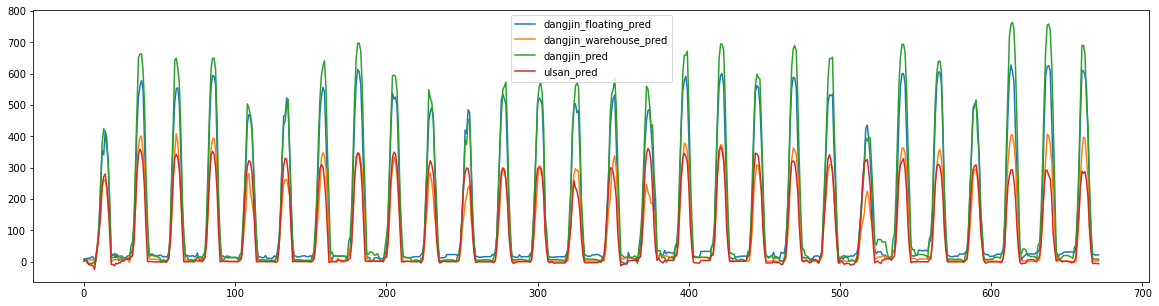

In [105]:
plt.figure(figsize=(20,5))
plt.plot(dangjin_floating_pred, label = 'dangjin_floating_pred')
plt.plot(dangjin_warehouse_pred, label = 'dangjin_warehouse_pred')
plt.plot(dangjin_pred, label = 'dangjin_pred')
plt.plot(ulsan_pred, label = 'ulsan_pred')
plt.legend()
plt.show()

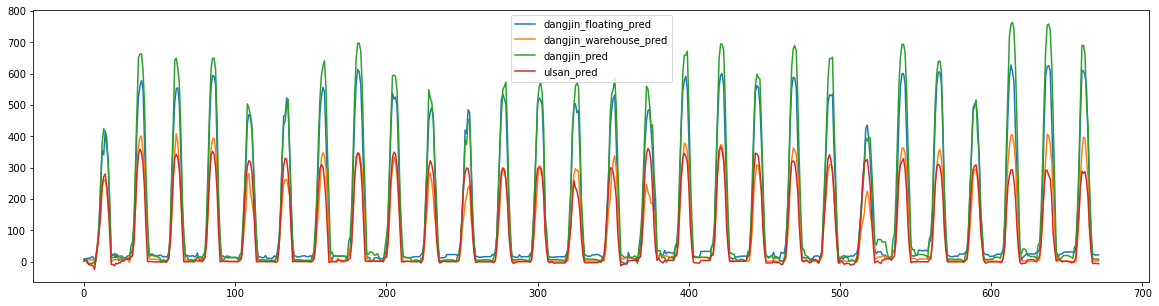

In [43]:
plt.figure(figsize=(20,5))
plt.plot(dangjin_floating_pred, label = 'dangjin_floating_pred')
plt.plot(dangjin_warehouse_pred, label = 'dangjin_warehouse_pred')
plt.plot(dangjin_pred, label = 'dangjin_pred')
plt.plot(ulsan_pred, label = 'ulsan_pred')
plt.legend()
plt.show()

# 5.제출

In [106]:
submission = pd.read_csv('./data/sample_submission.csv')

In [107]:
submission.iloc[:24*28, 1] = dangjin_floating_pred
submission.iloc[:24*28, 2] = dangjin_warehouse_pred
submission.iloc[:24*28, 3] = dangjin_pred
submission.iloc[:24*28, 4] = ulsan_pred

In [108]:
def zero_replacer(x):
    x[x < 0] = 0
    
    return x

In [109]:
submission.iloc[:,1:] = submission.iloc[:,1:].apply(lambda x : zero_replacer(x))

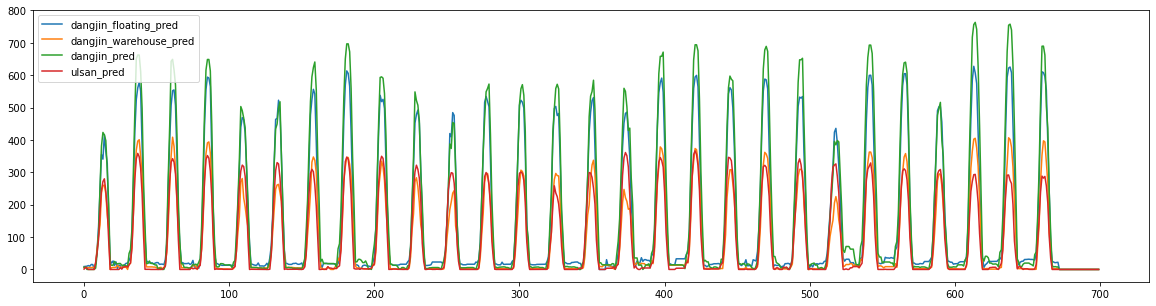

In [110]:
plt.figure(figsize=(20,5))
plt.plot(submission.iloc[0:700,1], label = 'dangjin_floating_pred')
plt.plot(submission.iloc[0:700,2], label = 'dangjin_warehouse_pred')
plt.plot(submission.iloc[0:700,3], label = 'dangjin_pred')
plt.plot(submission.iloc[0:700,4], label = 'ulsan_pred')
plt.legend()
plt.show()

In [49]:
submission.to_csv('dacon_baseline_2.csv', index=False)

dacon_baseline : BO Random_state 선별 + obs 학습

dacon_baseline_2 : BO random_state 선별 + obs 학습 + fcst 오토인코딩

# 6. 기타

In [96]:
submission_2 = pd.read_csv("dacon_baseline_base.csv")

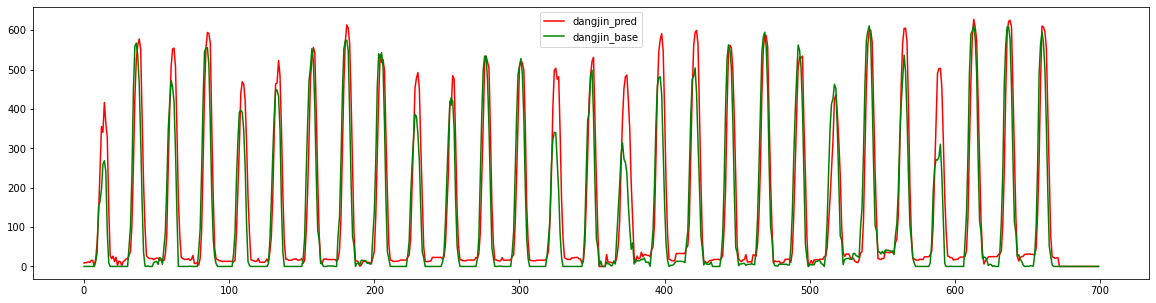

In [114]:
#동일성 확인
# 20시 예보 기준 변수 선별 없음 데이터 기준
# BeysianSearch : random_state = 42, init_point = 2

plt.figure(figsize = (20,5))
plt.plot(submission.iloc[0:700,1], label = 'dangjin_pred', color = "red")
plt.plot(submission_2.iloc[0:700,1], label = 'dangjin_base', color = "green")
plt.legend()

In [837]:
#backup

params = {"learning_rate": 0.10783739951020056,
            "feature_fraction" : 0.9531933606724133,
            "bagging_fraction" : 0.23847236804056848, 
           "lambda_l2" :  0.9702675891773067,
          "objective" : 'regression'
            }

capacity = 700
dangjin_warehouse_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10_lgb, verbose_eval=500, early_stopping_rounds=100)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 522
[LightGBM] [Info] Number of data points in the train set: 24888, number of used features: 9
[LightGBM] [Info] Start training from score 93.029010
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	valid_0's l2: 2813.18	valid_0's score: 9.06898


In [834]:
#back up

params = {"learning_rate": 0.06507179848450581,
            "feature_fraction" : 0.9710740235438662,
            "bagging_fraction" : 0.17788315317879033,
           "lambda_l2" : 0.8256623374071288,
          "objective" : 'regression'
            }

capacity = 1000
dangjin_floating_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10_lgb, verbose_eval=500, early_stopping_rounds=100)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 522
[LightGBM] [Info] Number of data points in the train set: 24888, number of used features: 9
[LightGBM] [Info] Start training from score 123.016594
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[106]	valid_0's l2: 4573.35	valid_0's score: 7.7931


In [840]:
#backup

params = {"learning_rate": 0.14177916409413205,
            "feature_fraction" : 0.9238503938274579,
            "bagging_fraction" : 0.0008585105355720257, 
           "lambda_l2" : 0.8774269737406408,
          "objective" : 'regression'
            }

capacity = 1000
dangjin_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10_lgb, verbose_eval=500, early_stopping_rounds=100)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 522
[LightGBM] [Info] Number of data points in the train set: 24888, number of used features: 9
[LightGBM] [Info] Start training from score 140.637898
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[32]	valid_0's l2: 6895.19	valid_0's score: 9.75751


In [852]:
#backup

params = {"learning_rate": 0.14181791897769322,
            "feature_fraction" : 0.7992881685934967,
            "bagging_fraction" : 0.023206948634535547,
           "lambda_l2" : 0.9641537271274845,
          "objective" : 'regression'
            }


capacity = 500
ulsan_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10_lgb, verbose_eval=500, early_stopping_rounds=100)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 24888, number of used features: 9
[LightGBM] [Info] Start training from score 64.331887
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[53]	valid_0's l2: 686.849	valid_0's score: 6.24438
